In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro, skew, kurtosis
import re
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [17]:
##############################################################################
# 0. DEFINE COLUMN NAME LISTS FOR CRASH, FLAG, PERSON, VEHICLE
# (Using the 'keep' lists derived from domain_driven_filter as the base)
##############################################################################

FLAG_KEEP = [ # Renamed from FLAG to avoid confusion with df_flag
    'CRN','ALCOHOL_RELATED','DRUG_RELATED','DRUGGED_DRIVER','OPIOID_RELATED',
    'ILLEGAL_DRUG_RELATED','MARIJUANA_DRUGGED_DRIVER','MARIJUANA_RELATED','FATAL','INJURY',
    'INJURY_OR_FATAL','FATAL_OR_SUSP_SERIOUS_INJ','POSSIBLE_INJURY',
    'SUSPECTED_MINOR_INJURY','SUSPECTED_SERIOUS_INJURY','PROPERTY_DAMAGE_ONLY',
    'AGGRESSIVE_DRIVING','CELL_PHONE','DISTRACTED','FATIGUE_ASLEEP',
    'SPEEDING','SPEEDING_RELATED','IMPAIRED_DRIVER','DRIVER_16YR','DRIVER_17YR',
    'DRIVER_18YR','DRIVER_19YR','DRIVER_20YR','DRIVER_50_64YR','DRIVER_65_74YR',
    'DRIVER_75PLUS','YOUNG_DRIVER','MATURE_DRIVER','INTERSECTION','NON_INTERSECTION',
    'RURAL','URBAN','LOCAL_ROAD','STATE_ROAD','INTERSTATE', 'UNBELTED' # Added UNBELTED for Figure 8
]

CRASH_KEEP = [ # Renamed from CRASH
    'CRN','CRASH_MONTH','CRASH_YEAR','DAY_OF_WEEK','HOUR_OF_DAY','TIME_OF_DAY',
    'COUNTY','MUNICIPALITY','DISTRICT','DEC_LAT','DEC_LONG','MAX_SEVERITY_LEVEL',
    'COLLISION_TYPE','INTERSECTION_RELATED','RELATION_TO_ROAD','ROAD_CONDITION',
    'ILLUMINATION','URBAN_RURAL','DRIVER_COUNT_16YR','DRIVER_COUNT_17YR','DRIVER_COUNT_18YR',
    'DRIVER_COUNT_19YR','DRIVER_COUNT_20YR','DRIVER_COUNT_50_64YR','DRIVER_COUNT_65_74YR',
    'DRIVER_COUNT_75PLUS','FATAL_COUNT','INJURY_COUNT','TOT_INJ_COUNT','VEHICLE_COUNT',
    'TOTAL_UNITS','AUTOMOBILE_COUNT','BICYCLE_COUNT','BUS_COUNT','COMM_VEH_COUNT',
    'HEAVY_TRUCK_COUNT','MOTORCYCLE_COUNT','SMALL_TRUCK_COUNT','SUV_COUNT','VAN_COUNT',
    'PERSON_COUNT' # Included from original CRASH list
]

PERSON_KEEP = [ # Renamed from PERSON
    'CRN','UNIT_NUM','AGE','SEX','INJ_SEVERITY','PERSON_TYPE','SEAT_POSITION',
    'RESTRAINT_HELMET','TRANSPORTED','DVR_PED_CONDITION','VULNERABLE_ROAD_USER'
]

VEHICLE_KEEP = [ # Renamed from VEHICLE
    'CRN','UNIT_NUM','VEH_TYPE','BODY_TYPE','MODEL_YR','MAKE_CD','COMM_VEH','VEH_ROLE',
    'VEH_MOVEMENT','TRAVEL_SPD','UNIT_TYPE'
]

In [18]:
##############################################################################
# 1. HELPER FUNCTIONS
##############################################################################

def redundant_columns(df):
    """Identify columns that have only one unique value (redundant)."""
    return [col for col in df.columns if df[col].nunique(dropna=False) <= 1] # count NaN as a value

def standardize_boolean(series):
    """Convert a series with potential boolean values to 0/1 (e.g. 'YES','NO','Y','N'). Handles numeric input too."""
    if pd.api.types.is_numeric_dtype(series):
        # If already numeric (like 0/1), return as is, maybe ensure it's int
         return series.astype(int)
    elif pd.api.types.is_object_dtype(series):
         # Handle string representations explicitly
         mapping = {"yes": 1, "y": 1, "true": 1, "1": 1, 1: 1,
                   "no": 0,  "n": 0, "false": 0, "0": 0, 0: 0}
         # Convert to string, lower, strip, then map
         return series.astype(str).str.lower().str.strip().map(mapping)
    else:
         # For other types (like bool), convert directly
         return series.astype(int)


def check_placeholder_values(series, placeholders=[9999, 99, "UNKNOWN", "unknown", "", " ", -1]): # Added -1 and space
    """Count occurrences of typical placeholder values in a series."""
    counts = {}
    # Convert series to string temporarily for consistent checking if it's object type
    is_object = pd.api.types.is_object_dtype(series)
    temp_series = series.astype(str) if is_object else series

    for ph in placeholders:
        try:
            if is_object or isinstance(ph, str):
                 # String comparison for object types or string placeholders
                 counts[ph] = (temp_series == str(ph)).sum()
            else:
                 # Numeric comparison for numeric types and numeric placeholders
                 counts[ph] = (temp_series == ph).sum()
        except TypeError:
             # Handle cases where comparison might fail (e.g., comparing numbers and strings directly)
             counts[ph] = 0 # Assume 0 count if comparison is invalid
    return counts


def convert_datetime_columns(df):
    """
    Convert columns containing 'date' or 'time' in their names to datetime.
    Handles potential HHMM format for time.
    Returns a list of columns successfully converted.
    """
    converted = []
    for col in df.columns:
        if "DATE" in col.upper(): # More robust check for date columns
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce')
                if not df[col].isnull().all(): # Check if conversion was successful for at least one value
                     converted.append(col)
            except Exception as e:
                print(f"Could not convert date column {col}: {e}")
        elif "TIME" in col.upper() or "TM" in col.upper(): # More robust check for time columns
             try:
                 # Attempt standard conversion first
                 converted_series = pd.to_datetime(df[col], errors='coerce')
                 if not converted_series.isnull().all():
                     df[col] = converted_series
                     converted.append(col)
                 else:
                     # Try converting from HHMM format (assuming numeric or string)
                     time_str = df[col].astype(str).str.zfill(4)
                     converted_series_hhmm = pd.to_datetime(time_str, format='%H%M', errors='coerce').dt.time
                     if not converted_series_hhmm.isnull().all():
                         df[col] = converted_series_hhmm # Store as time object
                         converted.append(col)
             except Exception as e:
                 print(f"Could not convert time column {col}: {e}")
    return converted

In [19]:
##############################################################################
# 2. DATA ANALYSIS FUNCTIONS FOR EACH FILE TYPE (Minor adjustments possible)
##############################################################################

def analyze_flag_file(df):
    print("FLAG File Analysis")
    print("-------------------")
    print("Data Shape:", df.shape)
    # print("Columns:", df.columns.tolist()) # Keep concise for figure output
    # print("\nFirst 5 rows:")
    # print(df.head())
    # print("\nData Types:")
    # print(df.dtypes)

    # Missing values analysis
    missing_counts = df.isnull().sum()
    missing_percent = 100 * missing_counts / len(df)
    missing_df = pd.DataFrame({'Missing Count': missing_counts, 'Missing Percent': missing_percent})
    print("\nMissing Values Analysis (showing > 0%):")
    print(missing_df[missing_df['Missing Percent'] > 0])

    # No need for heatmap in this context
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
    # plt.title("Missing Data Heatmap (FLAG File)")
    # plt.show()

    # Duplicate rows
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicate rows:", duplicate_count)

    # Redundant columns
    redun_cols = redundant_columns(df)
    print("\nRedundant columns (constant values):", redun_cols)

    # Standardize boolean fields
    print("\nStandardizing boolean fields...")
    standardized_count = 0
    for col in df.columns:
        # Check if column looks boolean (0/1, Y/N etc.) - simplistic check
        unique_vals_clean = df[col].dropna().unique()
        looks_boolean = len(unique_vals_clean) <= 2 or \
                        all(str(v).lower() in ['0','1','y','n','yes','no','true','false'] for v in unique_vals_clean)

        if looks_boolean and col != 'CRN': # Don't standardize CRN
            print(f"Standardizing potential boolean field: {col}")
            original_dtype = df[col].dtype
            df[col] = standardize_boolean(df[col].copy()) # Ensure modification happens on the DataFrame
            new_unique = df[col].dropna().unique()
            print(f" -> Original Dtype: {original_dtype}, New Dtype: {df[col].dtype}, New unique values: {new_unique}")
            standardized_count += 1
            # Check if conversion resulted in NaNs where it shouldn't have
            if df[col].isnull().sum() > missing_counts.get(col, 0):
                 print(f"      Warning: Standardization may have introduced NaNs in {col}")

    if standardized_count == 0:
        print("No obvious boolean fields needed standardization.")


    # Check for placeholder values in numeric/boolean columns
    print("\nChecking for placeholder values...")
    placeholders = [99, 9999, -1, '99', '9999', '-1', "UNKNOWN", "unknown", "", " "]
    placeholders_found = False
    for col in df.columns:
        # Only check numeric or columns just standardized to numeric
        if pd.api.types.is_numeric_dtype(df[col]):
            ph_counts = check_placeholder_values(df[col], placeholders)
            filtered_ph_counts = {k: v for k, v in ph_counts.items() if v > 0}
            if filtered_ph_counts:
                print(f"Column '{col}' has placeholder values: {filtered_ph_counts}")
                placeholders_found = True
    if not placeholders_found:
        print("No significant placeholder values detected in numeric columns.")

    # Linkage check
    if 'CRN' in df.columns:
        unique_crn = df['CRN'].nunique()
        total_rows = len(df)
        print(f"\nLinkage Check: CRN column has {unique_crn} unique values out of {total_rows} rows.")
        if unique_crn < total_rows:
            print("Warning: There might be duplicate CRNs in FLAG file.")
    else:
        print("CRN column not found in FLAG file.")

    return df

def analyze_crash_file(df):
    print("CRASH File Analysis")
    print("---------------------")
    print("Data Shape:", df.shape)

    # Check Crash ID uniqueness
    if 'CRN' in df.columns:
        unique_crn = df['CRN'].nunique()
        print(f"\nUnique Crash IDs (CRN): {unique_crn} out of {len(df)} rows.")
        if unique_crn < len(df):
            print("Warning: Duplicate Crash IDs detected.")
    else:
        print("CRN column not found in CRASH file.")

    # Convert date/time columns
    converted_cols = convert_datetime_columns(df)
    if converted_cols:
        print("Converted columns to datetime/time:", converted_cols)
    else:
        print("No date/time columns detected for conversion.")

    # Check numeric columns for negative values/placeholders
    print("\nChecking numeric columns for negative values/placeholders...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    placeholders = [-1, 9999, 99, '99', '9999', '-1', "UNKNOWN", "unknown", "", " "]
    neg_found = False
    ph_found = False
    for col in numeric_cols:
        if col == 'DEC_LONG': continue # Longitude is expected to be negative
        try:
             min_val = df[col].min()
             if min_val < 0:
                 print(f"Column '{col}' has negative values: min = {min_val}")
                 neg_found = True
        except TypeError:
             pass # Skip if min fails (e.g., on object columns accidentally included)

        ph_counts = check_placeholder_values(df[col], placeholders)
        filtered_ph_counts = {k: v for k, v in ph_counts.items() if v > 0}
        if filtered_ph_counts:
            print(f"Column '{col}' placeholder values: {filtered_ph_counts}")
            ph_found = True

    if not neg_found: print("No unexpected negative values found.")
    if not ph_found: print("No significant placeholder values detected.")

    # Duplicate rows
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicate rows:", duplicate_count)

    return df

def analyze_person_file(df):
    print("PERSON File Analysis")
    print("----------------------")
    print("Data Shape:", df.shape)

    # Age checks
    if 'AGE' in df.columns:
        # Convert AGE to numeric, coercing errors. Handle 99 as potentially 'Unknown' later if needed.
        df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')
        age_min = df['AGE'].min()
        age_max = df['AGE'].max()
        print(f"Age range (numeric): {age_min} to {age_max}")
        # Check for biologically unlikely ages, excluding NaN and common placeholders like 99
        unlikely_age_count = df['AGE'][(df['AGE'] < 0) | ((df['AGE'] > 120) & (df['AGE'] != 9999))].count()
        if unlikely_age_count > 0:
            print(f"Warning: AGE column has {unlikely_age_count} biologically unlikely values (e.g., < 0 or > 120).")
        if 99 in df['AGE'].unique():
             print("Note: AGE column contains 99, which may represent 'Unknown'.")

    # Convert INJ_SEVERITY to numeric if it's not
    if 'INJ_SEVERITY' in df.columns and not pd.api.types.is_numeric_dtype(df['INJ_SEVERITY']):
         df['INJ_SEVERITY'] = pd.to_numeric(df['INJ_SEVERITY'], errors='coerce')
         print("Converted INJ_SEVERITY to numeric.")

    # Missing values
    missing_counts = df.isnull().sum()
    print("\nMissing Values in PERSON File (showing > 0):")
    print(missing_counts[missing_counts > 0])

    # Duplicate rows
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicate rows:", duplicate_count)

    # CRN check
    if 'CRN' in df.columns:
        unique_crn = df['CRN'].nunique()
        print(f"\nLinkage Check: CRN column has {unique_crn} unique values.")
        print(f"Total rows in PERSON file: {len(df)}. (Multiple people per CRN is expected)")
    else:
        print("CRN column not found in PERSON file.")

    # Potential PII check - remove for safety
    # pii_keywords = ['name', 'phone', 'address', 'ssn']
    # for col in df.columns:
    #     for keyword in pii_keywords:
    #         if keyword in col.lower():
    #             print(f"Warning: Column '{col}' might contain PII.")

    # Ensure UNIT_NUM is suitable type if exists
    if 'UNIT_NUM' in df.columns and not pd.api.types.is_numeric_dtype(df['UNIT_NUM']):
        df['UNIT_NUM'] = pd.to_numeric(df['UNIT_NUM'], errors='coerce')
        print("Converted UNIT_NUM to numeric.")

    return df


def analyze_vehicle_file(df):
    print("VEHICLE File Analysis")
    print("-----------------------")
    print("Data Shape:", df.shape)

    # MODEL_YEAR checks
    if 'MODEL_YR' in df.columns:
        # Convert to numeric, coercing errors
        df['MODEL_YR'] = pd.to_numeric(df['MODEL_YR'], errors='coerce')
        current_year = datetime.now().year
        min_year = df['MODEL_YR'].min()
        max_year = df['MODEL_YR'].max()
        print(f"Model Year range (numeric): {min_year} to {max_year}")
        # Check for clearly invalid years (excluding NaN and placeholders like 9999)
        unlikely_year_count = df['MODEL_YR'][ (df['MODEL_YR'] < 1900) | ((df['MODEL_YR'] > current_year + 2) & (df['MODEL_YR'] != 9999)) ].count()
        if unlikely_year_count > 0:
             print(f"Warning: MODEL_YEAR contains {unlikely_year_count} unlikely values (e.g., < 1900 or > {current_year + 2}).")
        if 9999 in df['MODEL_YR'].unique():
             print("Note: MODEL_YEAR contains 9999, likely placeholder.")

    # Check TRAVEL_SPD
    if 'TRAVEL_SPD' in df.columns:
         df['TRAVEL_SPD'] = pd.to_numeric(df['TRAVEL_SPD'], errors='coerce')
         print(f"Travel Speed range (numeric, excluding codes like 999): {df['TRAVEL_SPD'][df['TRAVEL_SPD'] < 998].min()} to {df['TRAVEL_SPD'][df['TRAVEL_SPD'] < 998].max()}")
         if 999 in df['TRAVEL_SPD'].unique():
              print("Note: TRAVEL_SPD contains 999 (Unknown/Not Applicable).")

    # Make/Model standardization - Skip printing unique values for brevity
    for col in ['MAKE_CD', 'BODY_TYPE']: # Using codes instead of MAKE/MODEL text
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.upper() # Ensure codes are consistent strings

    # Numeric placeholders
    print("\nChecking numeric columns for negative values/placeholders...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    placeholders = [-1, 9999, 99, '99', '9999', '-1', "UNKNOWN", "unknown", "", " "]
    neg_found = False
    ph_found = False
    for col in numeric_cols:
        try:
            min_val = df[col].min()
            if min_val < 0:
                print(f"Column '{col}' has negative values: min = {min_val}")
                neg_found = True
        except TypeError:
            pass

        ph_counts = check_placeholder_values(df[col], placeholders)
        filtered_ph_counts = {k: v for k, v in ph_counts.items() if v > 0}
        if filtered_ph_counts:
            print(f"Column '{col}' placeholder counts: {filtered_ph_counts}")
            ph_found = True

    if not neg_found: print("No negative values found.")
    if not ph_found: print("No significant placeholder values detected.")

    # Duplicates
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicate rows:", duplicate_count)

    # CRN check
    if 'CRN' in df.columns:
        unique_crn = df['CRN'].nunique()
        print(f"\nLinkage Check: CRN column has {unique_crn} unique values.")
        print(f"Total rows in VEHICLE file: {len(df)}. (Multiple vehicles per CRN is expected)")
    else:
        print("CRN column not found in VEHICLE file.")

    # Ensure UNIT_NUM is suitable type if exists
    if 'UNIT_NUM' in df.columns and not pd.api.types.is_numeric_dtype(df['UNIT_NUM']):
        df['UNIT_NUM'] = pd.to_numeric(df['UNIT_NUM'], errors='coerce')
        print("Converted UNIT_NUM to numeric.")

    return df

In [20]:
##############################################################################
# 3. KEEP LISTS + ADVANCED FEATURE IMPORTANCE (Not used for figure generation)
##############################################################################
# These functions are kept for context but not directly used for plotting the 8 figures.
# They were part of the previous step's analysis.

def domain_driven_filter(crash_df, flag_df, person_df, vehicle_df):
    """ Domain-based 'keep' sets for each table, based on project KPIs. """
    crash_keep_cols = [col for col in CRASH_KEEP if col in crash_df.columns]
    flag_keep_cols = [col for col in FLAG_KEEP if col in flag_df.columns]
    person_keep_cols = [col for col in PERSON_KEEP if col in person_df.columns]
    vehicle_keep_cols = [col for col in VEHICLE_KEEP if col in vehicle_df.columns]
    return set(crash_keep_cols), set(flag_keep_cols), set(person_keep_cols), set(vehicle_keep_cols)

# [advanced_feature_importance and find_excess_columns_for_kpis_advanced functions kept here for reference but not called in the plotting flow]
def advanced_feature_importance(df, target_col='OPIOID_RELATED',
                                method='random_forest',
                                importance_threshold=0.01):
    """ For a given DataFrame 'df' and a binary target_col, do a quick feature importance check. """
    if target_col not in df.columns: return set()
    df = df.dropna(subset=[target_col])
    if df.empty: return set()

    y_series = df[target_col].copy()
    if not pd.api.types.is_numeric_dtype(y_series):
        le_t = LabelEncoder()
        y_series = le_t.fit_transform(y_series.astype(str))
        if len(le_t.classes_) != 2: return set()

    exclude_cols = {target_col, 'CRN', 'UNIT_NUM'}
    all_candidates = [c for c in df.columns if c not in exclude_cols]
    if not all_candidates: return set()

    X = df[all_candidates].copy()
    for col in X.columns:
        if X[col].dtype == object or pd.api.types.is_categorical_dtype(X[col]): # Include categorical
             X[col] = X[col].fillna('missing_cat').astype(str) # Ensure string type before encoding
             le = LabelEncoder()
             X[col] = le.fit_transform(X[col])
        elif pd.api.types.is_datetime64_any_dtype(X[col]): # Handle datetime
             X[col] = X[col].fillna(X[col].median()).astype(np.int64) // 10**9 # Convert to epoch seconds
        else: # Assume numeric
             X[col] = X[col].fillna(X[col].median())

    y = np.array(y_series)

    if method == 'random_forest':
        clf = RandomForestClassifier(n_estimators=50, random_state=42, # Reduced estimators for speed
                                     max_depth=8, class_weight='balanced_subsample', n_jobs=-1)
        clf.fit(X, y)
        importances = clf.feature_importances_
    else: # mutual info fallback
        importances = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

    important_features = set()
    for col, imp in zip(X.columns, importances):
        if imp >= importance_threshold:
             important_features.add(col)
    # Return the set of features to *KEEP* based on importance
    return important_features


def find_excess_columns_for_kpis_advanced(df_crash, df_flag, df_person, df_vehicle):
    """ 1) Keep domain-important columns, 2) optional advanced check, 3) unify => drop sets. """
    keep_crash_domain, keep_flag_domain, keep_person_domain, keep_vehicle_domain = \
        domain_driven_filter(df_crash, df_flag, df_person, df_vehicle)

    # Merge CRASH and FLAG for importance check on combined data
    df_merged_cf = pd.merge(df_crash[list(keep_crash_domain)].copy(),
                            df_flag[list(keep_flag_domain)].copy(),
                            on='CRN', how='inner') # Use inner merge to ensure target exists

    # Advanced approach on merged CRASH+FLAG data if target exists
    if 'OPIOID_RELATED' in df_merged_cf.columns:
        important_cf = advanced_feature_importance(
            df_merged_cf, target_col='OPIOID_RELATED', method='random_forest', importance_threshold=0.01
        )
        # Keep domain + important + keys
        keep_cf_final = keep_crash_domain.union(keep_flag_domain).intersection(important_cf.union({'CRN'}))
        print(f"Advanced Check kept {len(keep_cf_final)} features from CRASH+FLAG.")
    else:
        keep_cf_final = keep_crash_domain.union(keep_flag_domain) # Fallback to just domain
        print("OPIOID_RELATED not found in merged CRASH+FLAG, using domain keep lists only.")


    # Determine final drop lists based on what's *not* in the final keep lists
    final_crash_drop = set(df_crash.columns) - keep_cf_final
    final_flag_drop = set(df_flag.columns) - keep_cf_final
    # For PERSON/VEHICLE, just use domain drop for now as importance wasn't run on them directly
    final_person_drop = set(df_person.columns) - keep_person_domain
    final_vehicle_drop = set(df_vehicle.columns) - keep_vehicle_domain

    # Ensure linking keys are never dropped
    final_crash_drop -= {'CRN'}
    final_flag_drop -= {'CRN'}
    final_person_drop -= {'CRN', 'UNIT_NUM'}
    final_vehicle_drop -= {'CRN', 'UNIT_NUM'}


    # Get final keep lists by subtracting drop lists from original columns
    crash_keep_final   = [c for c in df_crash.columns   if c not in final_crash_drop]
    flag_keep_final    = [c for c in df_flag.columns    if c not in final_flag_drop]
    person_keep_final  = [c for c in df_person.columns  if c not in final_person_drop]
    vehicle_keep_final = [c for c in df_vehicle.columns if c not in final_vehicle_drop]


    return {
        'CRASH':   {'keep': crash_keep_final,   'drop': sorted(list(final_crash_drop))},
        'FLAG':    {'keep': flag_keep_final,    'drop': sorted(list(final_flag_drop))},
        'PERSON':  {'keep': person_keep_final,  'drop': sorted(list(final_person_drop))},
        'VEHICLE': {'keep': vehicle_keep_final, 'drop': sorted(list(final_vehicle_drop))}
    }

In [21]:
##############################################################################
# 4. CORRECTIVE ACTIONS + ADDITIONAL CHECKS (Reporting only, less critical for figures)
##############################################################################

def report_corrective_actions(df, file_type):
    """ Summarize potential corrective actions for each file. """
    actions = {}
    bool_cols = [col for col in df.columns if df[col].dropna().nunique() <= 2 and col != 'CRN'] # Simplified check
    actions['Potential Boolean Fields'] = bool_cols if bool_cols else "None obvious."

    date_time_cols = [col for col in df.columns if "DATE" in col.upper() or "TIME" in col.upper() or "TM" in col.upper()]
    actions['Potential Date/Time Fields'] = date_time_cols if date_time_cols else "None obvious."

    placeholder_cols = {}
    placeholders_to_check = [9999, 99, -1, "UNKNOWN", "unknown", "", " ", '99', '9999', '-1']
    numeric_cols_for_check = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols_for_check:
         ph_counts = check_placeholder_values(df[col], placeholders_to_check)
         filtered_ph_counts = {k: v for k, v in ph_counts.items() if v > 0}
         if filtered_ph_counts:
             placeholder_cols[col] = filtered_ph_counts
    actions['Placeholders Found (Numeric Cols)'] = placeholder_cols if placeholder_cols else "None detected."

    negative_cols = {}
    for col in numeric_cols_for_check:
         if col == 'DEC_LONG': continue # Skip longitude
         try:
             min_val = df[col].min()
             if min_val < 0:
                 negative_cols[col] = min_val
         except TypeError:
              pass
    actions['Unexpected Negative Values'] = negative_cols if negative_cols else "None detected."

    print(f"\n--- Corrective Actions Report for {file_type} file ---")
    for key, value in actions.items():
        print(f"* {key}: {value}")
    return actions


# [check_text_case_consistency, check_encoding, report_location_consistency functions kept for reference]
def check_text_case_consistency(df):
    consistency_report = {}
    for col in df.select_dtypes(include=['object']).columns:
        unique_vals = df[col].dropna().unique()
        cases = set()
        for val in unique_vals:
            s = str(val)
            if s.islower(): cases.add('lower')
            elif s.isupper(): cases.add('upper')
            # Check for mixed case only if not purely lower or upper
            elif any(c.islower() for c in s) and any(c.isupper() for c in s): cases.add('mixed')
            else: cases.add('other') # E.g., numbers as strings, punctuation only

        # Report if more than one type is present (e.g., upper and mixed)
        if len(cases) > 1 and 'other' not in cases: # Ignore 'other' for typical consistency check
            consistency_report[col] = cases
        elif len(cases) > 1 and cases != {'upper', 'other'} and cases != {'lower', 'other'}: # Allow pure case + other
             consistency_report[col] = cases
    return consistency_report

def check_encoding(df):
    encoding_issues = {}
    for col in df.select_dtypes(include=['object']).columns:
        issues = []
        for val in df[col].dropna().unique():
            try:
                str(val).encode('utf-8')
            except UnicodeEncodeError:
                issues.append(str(val)[:50]) # Show sample of problematic string
        if issues:
            encoding_issues[col] = issues[:5] # Limit number of examples shown
    return encoding_issues

def report_location_consistency(df, location_cols):
    report = {}
    for col in location_cols:
        if col in df.columns:
            report[col] = {'UniqueCount': df[col].dropna().nunique()}
    return report

In [22]:
##############################################################################
# 5. PLOTTING FUNCTIONS (Exploratory - Not the main 8 figures)
##############################################################################
# These functions are kept for context but not directly used for plotting the 8 figures.

# [plot_numeric_distributions, plot_categorical_distributions, correlation_and_vif, extended_exploratory_plots, plot_scatter_relationships functions kept here]
def plot_numeric_distributions(df, numeric_cols, file_tag=""):
    print(f"\n--- Plotting Numeric Distributions for {file_tag} ({len(numeric_cols)} cols) ---")
    # Simplified: Just show histograms for brevity
    for col in numeric_cols:
        col_data = df[col].dropna()
        if col_data.empty: continue
        # Limit plots for high-cardinality IDs like CRN
        if col in ['CRN', 'UNIT_NUM', 'PERSON_NUM'] and col_data.nunique() > 1000: continue

        plt.figure(figsize=(7, 4))
        sns.histplot(col_data, kde=True, bins=min(50, col_data.nunique())) # Adjust bins
        plt.title(f"{file_tag} - Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()


def plot_categorical_distributions(df, categorical_cols, file_tag=""):
    print(f"\n--- Plotting Categorical Distributions for {file_tag} ({len(categorical_cols)} cols) ---")
    # Simplified: Only plot if cardinality is reasonable
    for col in categorical_cols:
        if col not in df.columns: continue
        val_counts = df[col].value_counts(dropna=False)
        if 1 < val_counts.shape[0] <= 30: # Only plot if 2-30 unique values
             print(f"\n[{file_tag}] Categorical Column: {col}")
             # print(val_counts) # Reduce print output
             plt.figure(figsize=(max(6, val_counts.shape[0]*0.5), 4)) # Dynamic width
             sns.countplot(data=df, y=col, order=val_counts.index, palette='viridis') # Use y for better labels
             plt.title(f"{file_tag} - Count Plot of {col}")
             plt.xlabel("Count")
             plt.ylabel(col)
             plt.tight_layout()
             plt.show()
        # else: print(f"[{file_tag}] Skipping plot for '{col}' (Cardinality: {val_counts.shape[0]})")

def correlation_and_vif(df, numeric_cols, file_tag=""):
     print(f"\n--- Correlation and VIF for {file_tag} ({len(numeric_cols)} cols) ---")
     if len(numeric_cols) < 2:
         print(f"[{file_tag}] Not enough numeric columns ({len(numeric_cols)}) for correlation.")
         return

     # Select only numeric cols that actually exist in df
     valid_numeric_cols = [col for col in numeric_cols if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
     if len(valid_numeric_cols) < 2:
         print(f"[{file_tag}] Not enough valid numeric columns found in DataFrame for correlation.")
         return

     # Use only non-constant columns for VIF/Corr
     non_constant_cols = [col for col in valid_numeric_cols if df[col].nunique(dropna=False) > 1]
     if len(non_constant_cols) < 2:
          print(f"[{file_tag}] Not enough non-constant numeric columns for correlation.")
          return

     df_clean = df[non_constant_cols].dropna()
     if df_clean.shape[0] < 2:
         print(f"[{file_tag}] Not enough valid rows after dropna for correlation.")
         return

     corr_matrix = df_clean.corr()
     plt.figure(figsize=(min(12, len(non_constant_cols)), min(10, len(non_constant_cols))))
     sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
     plt.title(f"{file_tag} - Correlation Matrix (Non-Constant Numeric Cols)")
     plt.xticks(rotation=45, ha='right')
     plt.yticks(rotation=0)
     plt.tight_layout()
     plt.show()

     # VIF - Calculate only if there are >= 2 non-constant columns
     if len(non_constant_cols) >= 2:
         vif_data = []
         X_values = df_clean.values
         for i, col_name in enumerate(non_constant_cols):
             try:
                 # VIF requires variance, handle constant columns implicitly excluded earlier
                 vif_value = variance_inflation_factor(X_values, i)
             except Exception as e: # Catch potential errors like LinAlgError or constant columns sneaking through
                  # print(f"Could not calculate VIF for {col_name}: {e}") # Debugging
                  vif_value = np.inf # Assign infinity if VIF fails

             vif_data.append((col_name, vif_value))

         vif_df = pd.DataFrame(vif_data, columns=["Feature", "VIF"])
         print(f"\n[{file_tag}] Variance Inflation Factors (Non-Constant Numeric Cols):")
         print(vif_df.round(2))


def extended_exploratory_plots(df, file_tag=""):
    """ Wrapper for basic distribution and correlation plots """
    print(f"\n=== Running Extended Exploratory Plots for {file_tag} ===")
    numeric_cols = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
    categorical_cols = [col for col in df.columns if not pd.api.types.is_numeric_dtype(df[col])]
    plot_numeric_distributions(df, numeric_cols, file_tag=file_tag)
    plot_categorical_distributions(df, categorical_cols, file_tag=file_tag)
    correlation_and_vif(df, numeric_cols, file_tag=file_tag)

def plot_scatter_relationships(df_merged, df_person, df_vehicle):
    """ Example scatter plots exploring relationships """
    print("\n=== SCATTER PLOT RELATIONSHIP ANALYSIS (Limited Sample) ===")
    required_merged_cols = ['HOUR_OF_DAY', 'MAX_SEVERITY_LEVEL', 'OPIOID_RELATED', 'VEHICLE_COUNT', 'FATAL_COUNT', 'PERSON_COUNT', 'INJURY_COUNT', 'DEC_LAT', 'DEC_LONG']
    if not all(col in df_merged.columns for col in required_merged_cols):
        print("Warning: Not all required columns in df_merged for scatter plots. Skipping some plots.")
        return # Skip if essential columns missing

    # Ensure OPIOID_RELATED is numeric 0/1
    if 'OPIOID_RELATED' in df_merged.columns and not pd.api.types.is_numeric_dtype(df_merged['OPIOID_RELATED']):
        df_merged['OPIOID_RELATED'] = standardize_boolean(df_merged['OPIOID_RELATED'].copy())

    print("\n--- Scatter Plots: Merged Crash & Flag Data (Sampled) ---")
    sample_size = min(5000, len(df_merged)) # Smaller sample for faster plotting
    df_merged_sample = df_merged.sample(sample_size, random_state=42)

    # 1: Severity vs Hour (color by Opioid)
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=df_merged_sample, x='HOUR_OF_DAY', y='MAX_SEVERITY_LEVEL', hue='OPIOID_RELATED', alpha=0.6, palette='coolwarm')
    plt.title('Crash Severity vs. Hour of Day (Color by Opioid)')
    plt.xlabel('Hour of Day (0-23)')
    plt.ylabel('Max Severity Level')
    plt.grid(True)
    plt.show()

    # 2: Geo Plot (color by Opioid)
    df_geo = df_merged_sample[(df_merged_sample['DEC_LAT'].notna()) & (df_merged_sample['DEC_LONG'].notna()) &
                              (df_merged_sample['DEC_LAT'] > 39) & (df_merged_sample['DEC_LAT'] < 43) & # PA Lat bounds
                              (df_merged_sample['DEC_LONG'] < -74) & (df_merged_sample['DEC_LONG'] > -81)].copy() # PA Lon bounds
    if not df_geo.empty:
        plt.figure(figsize=(8, 7))
        sns.scatterplot(data=df_geo, x='DEC_LONG', y='DEC_LAT', hue='OPIOID_RELATED', alpha=0.4, s=15, palette='coolwarm')
        plt.title(f'Geographic Distribution (Sample {len(df_geo)}), Colored by Opioid')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid(True)
        plt.show()
    else:
        print("No valid geo-data found in sample for plotting.")

    # 3: Person Age vs Injury Severity (using original df_person)
    if 'AGE' in df_person.columns and 'INJ_SEVERITY' in df_person.columns and 'SEX' in df_person.columns:
         print("\n--- Scatter Plot: Person Data (Sampled) ---")
         df_person_plot = df_person[['AGE', 'INJ_SEVERITY', 'SEX']].dropna().copy()
         # Ensure INJ_SEVERITY is numeric
         df_person_plot['INJ_SEVERITY'] = pd.to_numeric(df_person_plot['INJ_SEVERITY'], errors='coerce')
         df_person_plot.dropna(inplace=True)

         if not df_person_plot.empty:
              sample_size_person = min(5000, len(df_person_plot))
              df_person_sample = df_person_plot.sample(sample_size_person, random_state=42)
              plt.figure(figsize=(10, 5))
              sns.scatterplot(data=df_person_sample, x='AGE', y='INJ_SEVERITY', hue='SEX', alpha=0.5, palette='muted')
              plt.title('Injury Severity vs. Age (Color by Sex)')
              plt.xlabel('Age')
              plt.ylabel('Injury Severity (Numeric)')
              plt.grid(True)
              plt.show()
         else: print("Not enough valid Person data for scatter plot.")
    else: print("Required columns missing in Person data for scatter plot.")

    # 4: Vehicle Speed vs Model Year (using original df_vehicle)
    if 'MODEL_YR' in df_vehicle.columns and 'TRAVEL_SPD' in df_vehicle.columns and 'VEH_ROLE' in df_vehicle.columns:
        print("\n--- Scatter Plot: Vehicle Data (Sampled) ---")
        df_vehicle_plot = df_vehicle[['MODEL_YR', 'TRAVEL_SPD', 'VEH_ROLE']].dropna().copy()
        # Ensure numeric types and filter unlikely values
        df_vehicle_plot['MODEL_YR'] = pd.to_numeric(df_vehicle_plot['MODEL_YR'], errors='coerce')
        df_vehicle_plot['TRAVEL_SPD'] = pd.to_numeric(df_vehicle_plot['TRAVEL_SPD'], errors='coerce')
        df_vehicle_plot['VEH_ROLE'] = pd.to_numeric(df_vehicle_plot['VEH_ROLE'], errors='coerce')
        df_vehicle_plot = df_vehicle_plot[
            (df_vehicle_plot['MODEL_YR'] > 1950) & (df_vehicle_plot['MODEL_YR'] < 9999) &
            (df_vehicle_plot['TRAVEL_SPD'] >= 0) & (df_vehicle_plot['TRAVEL_SPD'] < 200) # Filter extreme speeds
        ].dropna()

        if not df_vehicle_plot.empty:
             role_map = {0.0:'Non-Collision', 1.0:'Striking', 2.0:'Struck', 3.0:'Striking & Struck'}
             df_vehicle_plot['VEH_ROLE_DESC'] = df_vehicle_plot['VEH_ROLE'].map(role_map).fillna('Unknown')

             sample_size_vehicle = min(5000, len(df_vehicle_plot))
             df_vehicle_sample = df_vehicle_plot.sample(sample_size_vehicle, random_state=42)
             plt.figure(figsize=(10, 5))
             sns.scatterplot(data=df_vehicle_sample, x='MODEL_YR', y='TRAVEL_SPD', hue='VEH_ROLE_DESC', alpha=0.5)
             plt.title('Travel Speed vs. Model Year (Color by Vehicle Role)')
             plt.xlabel('Model Year')
             plt.ylabel('Estimated Travel Speed (mph)')
             plt.grid(True)
             plt.show()
        else: print("Not enough valid Vehicle data for scatter plot.")
    else: print("Required columns missing in Vehicle data for scatter plot.")


##############################################################################
# 6. FIGURES 1--8 DEFINITIONS (Copied from user prompt)
##############################################################################

def figure_1_crash_severity_distribution(crash_flag_df):
    """Creates a bar chart of crash counts by MAX_SEVERITY_LEVEL."""
    severity_map = {
        0: 'Property Damage Only', 1: 'Fatal', 2: 'Serious Injury',
        3: 'Minor Injury', 4: 'Possible Injury', 8: 'Unknown Severity',
        9: 'Unknown if Injured'
    }
    # Ensure MAX_SEVERITY_LEVEL is numeric for mapping
    if 'MAX_SEVERITY_LEVEL' not in crash_flag_df.columns:
        print("figure_1_crash_severity_distribution: 'MAX_SEVERITY_LEVEL' not found.")
        return
    if not pd.api.types.is_numeric_dtype(crash_flag_df['MAX_SEVERITY_LEVEL']):
         crash_flag_df['MAX_SEVERITY_LEVEL'] = pd.to_numeric(crash_flag_df['MAX_SEVERITY_LEVEL'], errors='coerce')


    # Create label, handling potential NaNs from coercion or missing map keys
    crash_flag_df['SEVERITY_LABEL'] = crash_flag_df['MAX_SEVERITY_LEVEL'].map(severity_map).fillna('Unknown/Invalid Code')
    sev_counts = crash_flag_df['SEVERITY_LABEL'].value_counts()

    # Define the desired order based on severity
    severity_order = [
        'Fatal', 'Serious Injury', 'Minor Injury', 'Possible Injury',
        'Property Damage Only', 'Unknown if Injured', 'Unknown Severity',
        'Unknown/Invalid Code'
     ]
    # Reindex to ensure order and inclusion of all categories, fill missing with 0
    sev_counts = sev_counts.reindex(severity_order, fill_value=0)

    plt.figure(figsize=(8,6))
    sns.barplot(x=sev_counts.index, y=sev_counts.values, palette='Blues_d', order=severity_order)
    plt.title("Figure 1: Distribution of Crash Severity Outcomes")
    plt.xlabel("Max Severity Level")
    plt.ylabel("Number of Crashes")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

def figure_2_opioid_vs_alcohol_counts(crash_flag_df):
    """Bar chart comparing total opioid-related crashes vs. alcohol-related crashes, plus overlap."""
    if 'OPIOID_RELATED' not in crash_flag_df.columns or 'ALCOHOL_RELATED' not in crash_flag_df.columns:
        print("figure_2_opioid_vs_alcohol_counts: 'OPIOID_RELATED' or 'ALCOHOL_RELATED' missing.")
        return

    # Ensure flags are numeric 0/1
    crash_flag_df['OPIOID_RELATED'] = standardize_boolean(crash_flag_df['OPIOID_RELATED'].copy())
    crash_flag_df['ALCOHOL_RELATED'] = standardize_boolean(crash_flag_df['ALCOHOL_RELATED'].copy())


    opioid_count = (crash_flag_df['OPIOID_RELATED'] == 1).sum()
    alcohol_count = (crash_flag_df['ALCOHOL_RELATED'] == 1).sum()
    overlap_count = ((crash_flag_df['OPIOID_RELATED']==1) & (crash_flag_df['ALCOHOL_RELATED']==1)).sum()

    cat = ['Opioid-Related','Alcohol-Related','Overlap (Both)']
    counts = [opioid_count, alcohol_count, overlap_count]

    plt.figure(figsize=(7,6))
    bars = sns.barplot(x=cat, y=counts, palette='RdBu')
    plt.title("Figure 2: Opioid vs. Alcohol-Related Crash Counts")
    plt.ylabel("Number of Crashes")

    # Add text labels above bars
    for bar in bars.patches:
        bars.annotate(format(bar.get_height(), '.0f'),
                      (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                      ha='center', va='bottom', size=10, xytext=(0, 8),
                      textcoords='offset points', fontweight='bold')

    plt.tight_layout()
    # Adjust y-limit to make space for labels
    plt.ylim(0, max(counts) * 1.15) # Add 15% margin at the top
    plt.show()

def figure_3_age_distribution_opioid(drivers_df):
    """Overlaid histograms/density for driver age, opioid vs non-opioid drivers."""
    if 'OPIOID_RELATED' not in drivers_df.columns or 'AGE' not in drivers_df.columns:
        print("figure_3_age_distribution_opioid: 'OPIOID_RELATED' or 'AGE' missing in drivers_df.")
        return
    if drivers_df.empty:
         print("figure_3_age_distribution_opioid: drivers_df is empty.")
         return

    # Ensure OPIOID_RELATED is 0/1 and AGE is numeric
    drivers_df['OPIOID_RELATED'] = standardize_boolean(drivers_df['OPIOID_RELATED'].copy())
    drivers_df['AGE'] = pd.to_numeric(drivers_df['AGE'], errors='coerce')

    # Exclude placeholder ages like 99 and NaNs
    drivers_filtered = drivers_df[(drivers_df['AGE'].notna()) & (drivers_df['AGE'] != 99) & (drivers_df['AGE'] < 120) & (drivers_df['AGE'] >= 16)] # Filter for valid driver ages

    if drivers_filtered.empty:
         print("figure_3_age_distribution_opioid: No valid driver ages found after filtering.")
         return

    opioid_drivers = drivers_filtered.loc[drivers_filtered['OPIOID_RELATED']==1, 'AGE']
    non_opioid_drivers = drivers_filtered.loc[drivers_filtered['OPIOID_RELATED']==0, 'AGE']

    if opioid_drivers.empty and non_opioid_drivers.empty:
        print("figure_3_age_distribution_opioid: No opioid or non-opioid drivers found in the filtered data.")
        return

    plt.figure(figsize=(10,6))
    # Plot non-opioid first (usually larger group)
    if not non_opioid_drivers.empty:
        sns.histplot(non_opioid_drivers, color='blue', label=f'Non-Opioid Drivers (n={len(non_opioid_drivers)})', kde=True, alpha=0.5, bins=30) # More bins
    # Plot opioid drivers on top
    if not opioid_drivers.empty:
        sns.histplot(opioid_drivers, color='red', label=f'Opioid Drivers (n={len(opioid_drivers)})', kde=True, alpha=0.6, bins=30) # Ensure alpha allows visibility

    plt.title("Figure 3: Age Distribution (Opioid vs. Non-Opioid Drivers, Age 16-119)")
    plt.xlabel("Driver Age")
    plt.ylabel("Count")
    # Only show legend if both groups have data
    if not opioid_drivers.empty and not non_opioid_drivers.empty:
        plt.legend()
    elif opioid_drivers.empty:
         print("Warning: No opioid-related drivers found for Figure 3.")
    elif non_opioid_drivers.empty:
         print("Warning: No non-opioid-related drivers found for Figure 3.")

    plt.tight_layout()
    plt.show()


def figure_4_county_opioid_bar(crash_flag_df):
    """Bar chart: number of opioid-related crashes by county (Top N)."""
    if 'COUNTY' not in crash_flag_df.columns or 'OPIOID_RELATED' not in crash_flag_df.columns:
        print("figure_4_county_opioid_bar: 'COUNTY' or 'OPIOID_RELATED' not found.")
        return

    # Ensure OPIOID_RELATED is numeric
    crash_flag_df['OPIOID_RELATED'] = standardize_boolean(crash_flag_df['OPIOID_RELATED'].copy())

    df_county = crash_flag_df.groupby('COUNTY')['OPIOID_RELATED'].sum().reset_index()
    df_county.columns = ['COUNTY','OpioidCrashes']
    # Filter out counties with 0 opioid crashes for clarity
    df_county = df_county[df_county['OpioidCrashes'] > 0]
    df_county = df_county.sort_values('OpioidCrashes', ascending=False)

    # Limit to Top N counties if there are too many
    top_n = 30
    if len(df_county) > top_n:
        df_county = df_county.head(top_n)
        plot_title = f"Figure 4: Top {top_n} Counties by Opioid-Related Crashes"
    else:
         plot_title = "Figure 4: Opioid-Related Crashes by County"

    if df_county.empty:
         print("figure_4_county_opioid_bar: No counties with opioid-related crashes found.")
         return

    plt.figure(figsize=(12,7)) # Wider figure for potentially many counties
    sns.barplot(data=df_county, x='COUNTY', y='OpioidCrashes', palette='magma')
    plt.title(plot_title)
    plt.xlabel("County Code")
    plt.ylabel("Number of Opioid-Related Crashes")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def figure_5_correlation_heatmap(crash_flag_df):
    """Heatmap of correlation among selected numeric/flag columns."""
    needed_cols = [ # Using columns likely available after CRASH+FLAG merge
        'OPIOID_RELATED','ALCOHOL_RELATED','FATAL','INJURY_COUNT',
        'FATAL_COUNT','VEHICLE_COUNT', 'PERSON_COUNT', # Added PERSON_COUNT
        'YOUNG_DRIVER','MATURE_DRIVER', 'SPEEDING_RELATED', # Added SPEEDING_RELATED
        'AGGRESSIVE_DRIVING', 'DISTRACTED' # Added some behavior flags
    ]
    # Filter to columns actually present in the dataframe
    available_cols = [c for c in needed_cols if c in crash_flag_df.columns]

    if len(available_cols) < 2: # Need at least 2 columns to correlate
        print(f"figure_5_correlation_heatmap: Not enough columns ({len(available_cols)}) found to correlate.")
        return

    print(f"Figure 5: Correlating columns: {available_cols}")

    # Ensure all selected columns are numeric
    df_corr = crash_flag_df[available_cols].copy()
    for c in available_cols:
        if not pd.api.types.is_numeric_dtype(df_corr[c]):
            # Attempt standardization/conversion
            df_corr[c] = standardize_boolean(df_corr[c]) # Handles bools, 0/1 strings
            df_corr[c] = pd.to_numeric(df_corr[c], errors='coerce') # Coerce remaining non-numeric

    # Drop rows with NaNs *after* conversion attempt
    df_corr.dropna(inplace=True)

    if df_corr.shape[0] < 2 or df_corr.shape[1] < 2:
         print("figure_5_correlation_heatmap: Not enough valid data after cleaning for correlation.")
         return

    corr_matrix = df_corr.corr(method='pearson') # Pearson is common, could use spearman for ordinal

    plt.figure(figsize=(10,8)) # Adjusted size
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1) # Set vmin/vmax
    plt.title("Figure 5: Correlation Heatmap of Key Variables")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def figure_6_injury_boxplot(crash_flag_df):
    """Boxplot comparing 'INJURY_COUNT' in opioid vs non-opioid crashes."""
    if 'INJURY_COUNT' not in crash_flag_df.columns or 'OPIOID_RELATED' not in crash_flag_df.columns:
        print("figure_6_injury_boxplot: 'INJURY_COUNT' or 'OPIOID_RELATED' missing.")
        return

    # Ensure flags/counts are numeric
    crash_flag_df['OPIOID_RELATED'] = standardize_boolean(crash_flag_df['OPIOID_RELATED'].copy())
    crash_flag_df['INJURY_COUNT'] = pd.to_numeric(crash_flag_df['INJURY_COUNT'], errors='coerce')

    # Create label after ensuring numeric type
    crash_flag_df['OPIOID_LABEL'] = crash_flag_df['OPIOID_RELATED'].map({1: 'Opioid-Related', 0: 'Non-Opioid'}).fillna('Unknown')

    # Filter out NaN injury counts
    plot_df = crash_flag_df.dropna(subset=['INJURY_COUNT'])

    if plot_df.empty:
         print("figure_6_injury_boxplot: No valid data after dropping NaN injury counts.")
         return

    plt.figure(figsize=(8,6))
    sns.boxplot(data=plot_df, x='OPIOID_LABEL', y='INJURY_COUNT', palette='Set2', showfliers=False) # Turn off outliers for cleaner look initially
    # Optionally add swarmplot for detail, but can be slow for large data
    # sns.swarmplot(data=plot_df.sample(min(1000, len(plot_df))), x='OPIOID_LABEL', y='INJURY_COUNT', color=".25", size=3, alpha=0.5)

    plt.title("Figure 6: Injury Count by Opioid Involvement (Outliers Hidden)")
    plt.xlabel("")
    plt.ylabel("Number of Injuries in Crash")
    plt.tight_layout()
    plt.show()

def figure_7_monthly_opioid_trend(crash_flag_df):
    """Line plot: monthly counts of opioid-related crashes. CRASH_MONTH should be 1..12."""
    if 'CRASH_MONTH' not in crash_flag_df.columns or 'OPIOID_RELATED' not in crash_flag_df.columns:
        print("figure_7_monthly_opioid_trend: 'CRASH_MONTH' or 'OPIOID_RELATED' missing.")
        return

    # Ensure types are correct
    crash_flag_df['OPIOID_RELATED'] = standardize_boolean(crash_flag_df['OPIOID_RELATED'].copy())
    crash_flag_df['CRASH_MONTH'] = pd.to_numeric(crash_flag_df['CRASH_MONTH'], errors='coerce')

    # Filter out invalid months
    plot_df = crash_flag_df[(crash_flag_df['CRASH_MONTH'] >= 1) & (crash_flag_df['CRASH_MONTH'] <= 12)]

    if plot_df.empty:
         print("figure_7_monthly_opioid_trend: No valid month data found.")
         return

    df_month = plot_df.groupby('CRASH_MONTH')['OPIOID_RELATED'].sum().reset_index()
    df_month.columns = ['Month','OpioidCrashes']
    # Ensure all months 1-12 are present, filling missing with 0
    df_month = df_month.set_index('Month').reindex(range(1,13), fill_value=0).reset_index()

    plt.figure(figsize=(10,5)) # Wider figure
    sns.lineplot(data=df_month, x='Month', y='OpioidCrashes', marker='o', color='red', sort=False) # sort=False since already sorted 1-12
    plt.title("Figure 7: Monthly Opioid-Related Crash Trend") # Removed year assumption
    plt.xlabel("Month (1=Jan ... 12=Dec)")
    plt.ylabel("Opioid-Related Crashes")
    plt.grid(True, linestyle='--')
    plt.xticks(range(1,13))
    plt.xlim(0.5, 12.5) # Set limits for better spacing
    plt.tight_layout()
    plt.show()

def figure_8_opioid_contributing_factors(crash_flag_df):
    """ Bar chart of selected factor flags among opioid-related crashes """
    factor_cols = [ # Using flags likely available in FLAG data
        'SPEEDING_RELATED', 'DISTRACTED', 'AGGRESSIVE_DRIVING',
        'IMPAIRED_DRIVER', # Check if opioid crashes also flagged as impaired generally
        'FATIGUE_ASLEEP', 'CELL_PHONE', 'UNBELTED' # Added UNBELTED as per definition
    ]
    # Make sure these columns exist and OPIOID_RELATED exists
    available_factors = [c for c in factor_cols if c in crash_flag_df.columns]
    if 'OPIOID_RELATED' not in crash_flag_df.columns:
        print("figure_8_opioid_contributing_factors: 'OPIOID_RELATED' missing.")
        return
    if not available_factors:
        print("figure_8_opioid_contributing_factors: None of the specified factor columns found.")
        return

    print(f"Figure 8: Analyzing factors: {available_factors}")

    # Ensure all relevant flags are numeric 0/1
    crash_flag_df['OPIOID_RELATED'] = standardize_boolean(crash_flag_df['OPIOID_RELATED'].copy())
    for col in available_factors:
         crash_flag_df[col] = standardize_boolean(crash_flag_df[col].copy())


    # Subset only opioid-related crashes
    opioid_df = crash_flag_df[crash_flag_df['OPIOID_RELATED'] == 1]

    if opioid_df.empty:
         print("figure_8_opioid_contributing_factors: No opioid-related crashes found to analyze factors.")
         return

    # Count how many times each factor == 1 in the opioid subset
    factor_counts = {}
    for col in available_factors:
        factor_counts[col] = opioid_df[col].sum() # Assumes cols are 0/1 numeric now

    # Sort factors in descending order of counts
    factor_items = sorted(factor_counts.items(), key=lambda x: x[1], reverse=True)
    factors = [f[0] for f in factor_items]
    counts = [f[1] for f in factor_items]

    plt.figure(figsize=(10, 6)) # Adjusted size
    bars = sns.barplot(x=factors, y=counts, palette='Spectral')
    plt.title("Figure 8: Contributing Factors Recorded in Opioid-Related Crashes")
    plt.xlabel("Contributing Factor Flag")
    plt.ylabel("Number of Opioid-Related Crashes Where Flag=1")
    plt.xticks(rotation=45, ha='right')

    # Add text labels
    for bar in bars.patches:
         height = bar.get_height()
         if height > 0: # Only label non-zero bars
             bars.annotate(f'{height:.0f}',
                           (bar.get_x() + bar.get_width() / 2, height),
                           ha='center', va='bottom', size=9, xytext=(0, 5),
                           textcoords='offset points')

    plt.tight_layout()
    plt.ylim(0, max(counts) * 1.1 if counts else 1) # Adjust y limit slightly
    plt.show()


##############################################################################
# 7. WRAPPER FUNCTION TO OUTPUT ALL 8 FIGURES
##############################################################################
def output_all_figures(crash_flag_df, drivers_df):
    """
    Calls each of the eight figure functions in sequence.

    :param crash_flag_df: DataFrame containing merged CRASH + FLAG data.
                          Requires columns: MAX_SEVERITY_LEVEL, OPIOID_RELATED,
                          ALCOHOL_RELATED, COUNTY, INJURY_COUNT, FATAL_COUNT,
                          VEHICLE_COUNT, PERSON_COUNT, YOUNG_DRIVER, MATURE_DRIVER,
                          CRASH_MONTH, SPEEDING_RELATED, DISTRACTED,
                          AGGRESSIVE_DRIVING, IMPAIRED_DRIVER, FATIGUE_ASLEEP,
                          CELL_PHONE, UNBELTED.
    :param drivers_df: DataFrame focusing on driver-level records.
                       Requires columns: OPIOID_RELATED, AGE.
    """
    print("\n\n" + "="*60)
    print("           GENERATING PROJECT FIGURES 1-8")
    print("="*60 + "\n")

    # Input Validation
    if not isinstance(crash_flag_df, pd.DataFrame) or crash_flag_df.empty:
         print("Error: crash_flag_df is not a valid or non-empty DataFrame. Cannot generate figures.")
         return
    if not isinstance(drivers_df, pd.DataFrame): # Allow empty drivers_df, figure 3 will handle it
         print("Warning: drivers_df is not a valid DataFrame. Figure 3 might fail.")
         # Create an empty df with required columns to prevent errors later if needed
         drivers_df = pd.DataFrame(columns=['OPIOID_RELATED', 'AGE'])


    print("Generating Figure 1: Crash Severity Distribution...")
    figure_1_crash_severity_distribution(crash_flag_df.copy()) # Pass copy to avoid modifying original

    print("\nGenerating Figure 2: Opioid vs. Alcohol Crash Counts...")
    figure_2_opioid_vs_alcohol_counts(crash_flag_df.copy())

    print("\nGenerating Figure 3: Age Distribution (Opioid vs. Non-Opioid Drivers)...")
    figure_3_age_distribution_opioid(drivers_df.copy()) # Pass the prepared drivers_df

    print("\nGenerating Figure 4: County Bar Chart of Opioid-Related Crashes...")
    figure_4_county_opioid_bar(crash_flag_df.copy())

    print("\nGenerating Figure 5: Correlation Heatmap...")
    figure_5_correlation_heatmap(crash_flag_df.copy())

    print("\nGenerating Figure 6: Box Plot of INJURY_COUNT by Opioid Involvement...")
    figure_6_injury_boxplot(crash_flag_df.copy())

    print("\nGenerating Figure 7: Monthly Trend of Opioid-Related Crashes...")
    figure_7_monthly_opioid_trend(crash_flag_df.copy())

    print("\nGenerating Figure 8: Contributing Factors in Opioid-Related Crashes...")
    figure_8_opioid_contributing_factors(crash_flag_df.copy())

    print("\n" + "="*60)
    print("           ALL 8 FIGURES HAVE BEEN DISPLAYED.")
    print("="*60 + "\n")

Loading data...
Initial Data Shapes after filtering:
  FLAG: (116118, 41)
  CRASH: (116118, 41)
  PERSON: (254031, 11)
  VEHICLE: (206630, 11)

--- Running Initial Analysis & Cleaning ---
FLAG File Analysis
-------------------
Data Shape: (116118, 41)

Missing Values Analysis (showing > 0%):
Empty DataFrame
Columns: [Missing Count, Missing Percent]
Index: []

Number of duplicate rows: 0

Redundant columns (constant values): []

Standardizing boolean fields...
Standardizing potential boolean field: ALCOHOL_RELATED
 -> Original Dtype: int64, New Dtype: int32, New unique values: [0 1]
Standardizing potential boolean field: DRUG_RELATED
 -> Original Dtype: int64, New Dtype: int32, New unique values: [0 1]
Standardizing potential boolean field: DRUGGED_DRIVER
 -> Original Dtype: int64, New Dtype: int32, New unique values: [0 1]
Standardizing potential boolean field: OPIOID_RELATED
 -> Original Dtype: int64, New Dtype: int32, New unique values: [0 1]
Standardizing potential boolean field: IL

C:\Users\jason\AppData\Local\Temp\ipykernel_158168\3341429793.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  drivers_df['OPIOID_RELATED'].fillna(0, inplace=True)
C:\Users\jason\AppData\Local\Temp\ipykernel_158168\997078625.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sev_counts.index, y=sev_counts.values, palette='Blues_d', order=severity_order)


Created drivers_df with shape: (187773, 3)
Columns in drivers_df: ['CRN', 'AGE', 'OPIOID_RELATED']


           GENERATING PROJECT FIGURES 1-8

Generating Figure 1: Crash Severity Distribution...


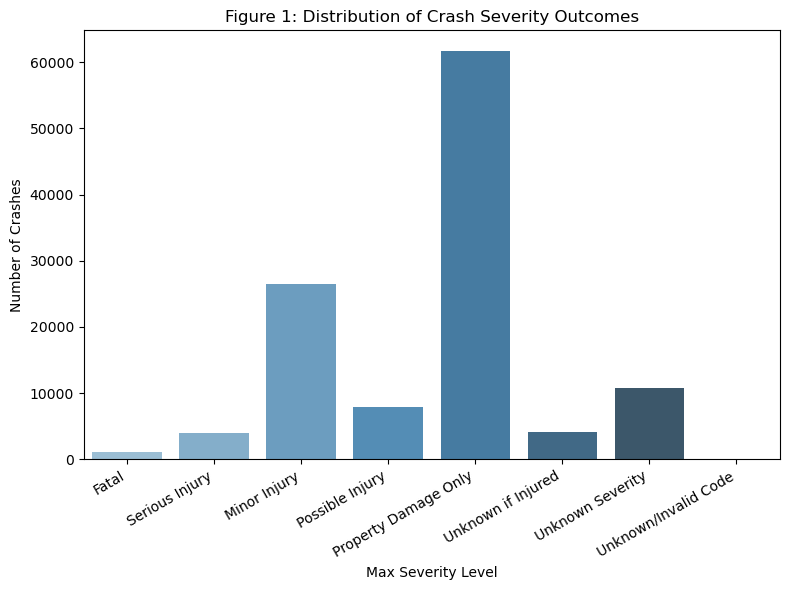


Generating Figure 2: Opioid vs. Alcohol Crash Counts...


C:\Users\jason\AppData\Local\Temp\ipykernel_158168\997078625.py:254: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=cat, y=counts, palette='RdBu')


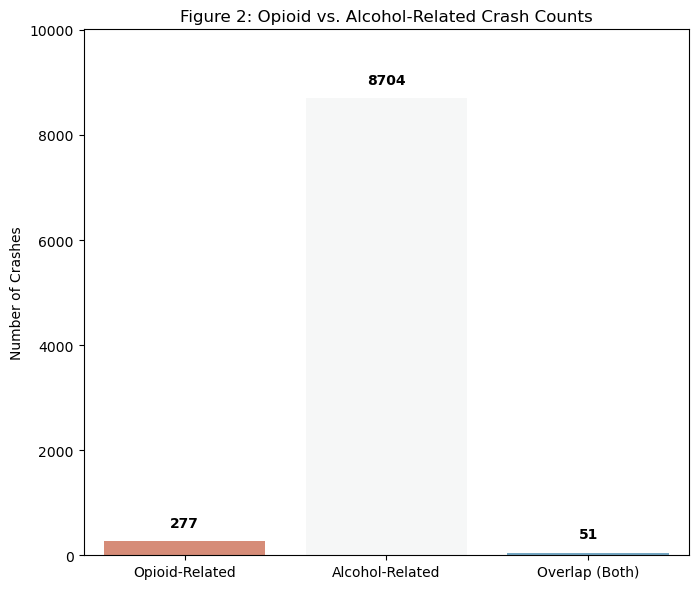


Generating Figure 3: Age Distribution (Opioid vs. Non-Opioid Drivers)...



Generating Figure 4: County Bar Chart of Opioid-Related Crashes...


C:\Users\jason\AppData\Local\Temp\ipykernel_158168\997078625.py:348: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_county, x='COUNTY', y='OpioidCrashes', palette='magma')


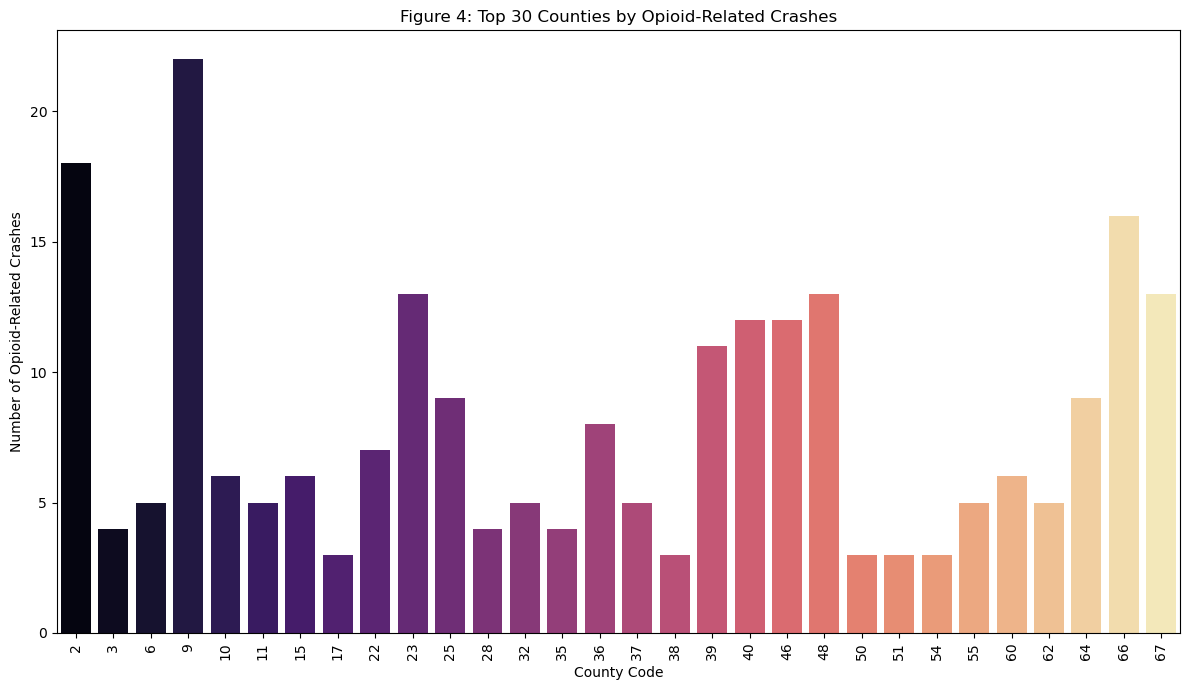


Generating Figure 5: Correlation Heatmap...
Figure 5: Correlating columns: ['OPIOID_RELATED', 'ALCOHOL_RELATED', 'FATAL', 'INJURY_COUNT', 'FATAL_COUNT', 'VEHICLE_COUNT', 'PERSON_COUNT', 'YOUNG_DRIVER', 'MATURE_DRIVER', 'SPEEDING_RELATED', 'AGGRESSIVE_DRIVING', 'DISTRACTED']



Generating Figure 6: Box Plot of INJURY_COUNT by Opioid Involvement...


C:\Users\jason\AppData\Local\Temp\ipykernel_158168\997078625.py:420: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x='OPIOID_LABEL', y='INJURY_COUNT', palette='Set2', showfliers=False) # Turn off outliers for cleaner look initially



Generating Figure 7: Monthly Trend of Opioid-Related Crashes...



Generating Figure 8: Contributing Factors in Opioid-Related Crashes...
Figure 8: Analyzing factors: ['SPEEDING_RELATED', 'DISTRACTED', 'AGGRESSIVE_DRIVING', 'IMPAIRED_DRIVER', 'FATIGUE_ASLEEP', 'CELL_PHONE', 'UNBELTED']


C:\Users\jason\AppData\Local\Temp\ipykernel_158168\997078625.py:505: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=factors, y=counts, palette='Spectral')


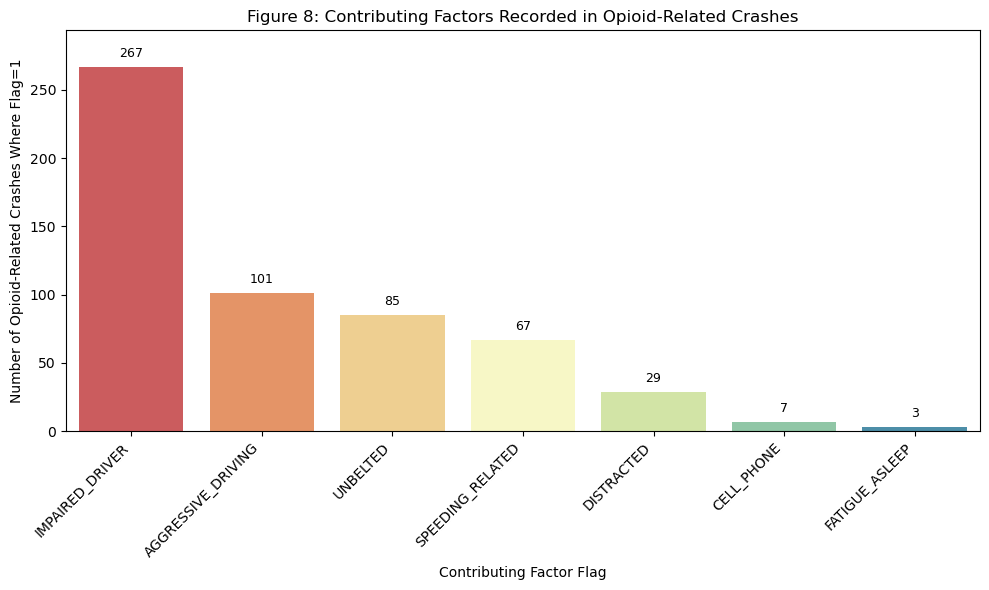


           ALL 8 FIGURES HAVE BEEN DISPLAYED.


Script Execution Finished.


In [23]:
# Main Analysis
if __name__ == "__main__":

    # --- Define File Paths ---
    # *** IMPORTANT: Update these paths to the actual location of your CSV files ***
    base_path = "C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/PA/Statewide_2022/"
    flag_file_path = os.path.join(base_path, "FLAG_2022.csv")
    crash_file_path = os.path.join(base_path, "CRASH_2022.csv")
    person_file_path = os.path.join(base_path, "PERSON_2022.csv")
    vehicle_file_path = os.path.join(base_path, "VEHICLE_2022.csv")

    # --- Load Data (Using 'KEEP' lists for initial filtering) ---
    print("Loading data...")
    try:
        df_flag_raw = pd.read_csv(flag_file_path, low_memory=False)
        df_crash_raw = pd.read_csv(crash_file_path, low_memory=False)
        df_person_raw = pd.read_csv(person_file_path, low_memory=False)
        df_vehicle_raw = pd.read_csv(vehicle_file_path, low_memory=False)
    except FileNotFoundError as e:
        print(f"Error loading files: {e}. Please check file paths.")
        # Exit or handle error appropriately
        exit() # Stop execution if files not found

    # Filter using KEEP lists (ensure columns exist)
    df_flag = df_flag_raw[[col for col in FLAG_KEEP if col in df_flag_raw.columns]].copy()
    df_crash = df_crash_raw[[col for col in CRASH_KEEP if col in df_crash_raw.columns]].copy()
    df_person = df_person_raw[[col for col in PERSON_KEEP if col in df_person_raw.columns]].copy()
    df_vehicle = df_vehicle_raw[[col for col in VEHICLE_KEEP if col in df_vehicle_raw.columns]].copy()

    print("Initial Data Shapes after filtering:")
    print(f"  FLAG: {df_flag.shape}")
    print(f"  CRASH: {df_crash.shape}")
    print(f"  PERSON: {df_person.shape}")
    print(f"  VEHICLE: {df_vehicle.shape}")

    # --- Basic Analysis & Cleaning ---
    print("\n--- Running Initial Analysis & Cleaning ---")
    df_flag = analyze_flag_file(df_flag)
    df_crash = analyze_crash_file(df_crash)
    df_person = analyze_person_file(df_person)
    df_vehicle = analyze_vehicle_file(df_vehicle)

    # --- Prepare DataFrames for Plotting ---
    print("\n--- Preparing DataFrames for Figure Generation ---")

    # 1. Create crash_flag_df (Merged CRASH and FLAG)
    # Ensure CRN is the same type for merging (use string)
    df_crash['CRN'] = df_crash['CRN'].astype(str)
    df_flag['CRN'] = df_flag['CRN'].astype(str)
    # Select flag columns to merge (excluding CRN itself)
    flag_cols_to_merge = [col for col in df_flag.columns if col != 'CRN']
    df_merged_crash_flag = pd.merge(df_crash, df_flag[['CRN'] + flag_cols_to_merge], on='CRN', how='left')
    print(f"Shape of merged CRASH+FLAG data: {df_merged_crash_flag.shape}")
    # Check if essential columns for figures exist in merged df
    print(f"OPIOID_RELATED in merged: {'OPIOID_RELATED' in df_merged_crash_flag.columns}")
    print(f"ALCOHOL_RELATED in merged: {'ALCOHOL_RELATED' in df_merged_crash_flag.columns}")
    print(f"MAX_SEVERITY_LEVEL in merged: {'MAX_SEVERITY_LEVEL' in df_merged_crash_flag.columns}")


    # 2. Create drivers_df (Driver Subset from PERSON merged with FLAG's OPIOID_RELATED)
    if 'PERSON_TYPE' in df_person.columns and 'AGE' in df_person.columns:
        # Filter for drivers (PERSON_TYPE == 1)
        df_person['PERSON_TYPE'] = pd.to_numeric(df_person['PERSON_TYPE'], errors='coerce')
        drivers_only = df_person[df_person['PERSON_TYPE'] == 1].copy()
        print(f"Filtered PERSON data to {len(drivers_only)} driver records.")

        # Ensure CRN is string type for merging
        drivers_only['CRN'] = drivers_only['CRN'].astype(str)

        # Select only needed columns from drivers_only and the OPIOID flag from df_flag
        if 'OPIOID_RELATED' in df_flag.columns:
             drivers_df = pd.merge(
                 drivers_only[['CRN', 'AGE']], # Select needed columns
                 df_flag[['CRN', 'OPIOID_RELATED']],
                 on='CRN',
                 how='left' # Keep all drivers, add opioid flag if available
             )
             # Fill NaN in OPIOID_RELATED with 0 (assuming no flag means non-opioid for this driver context)
             if 'OPIOID_RELATED' in drivers_df.columns: # Check if merge was successful
                  drivers_df['OPIOID_RELATED'].fillna(0, inplace=True)
                  drivers_df['OPIOID_RELATED'] = standardize_boolean(drivers_df['OPIOID_RELATED']) # Ensure 0/1
             print(f"Created drivers_df with shape: {drivers_df.shape}")
             print(f"Columns in drivers_df: {drivers_df.columns.tolist()}")
        else:
             print("Warning: 'OPIOID_RELATED' not in df_flag. Cannot create drivers_df with opioid info.")
             drivers_df = drivers_only[['CRN', 'AGE']].copy() # Create df without opioid flag
             drivers_df['OPIOID_RELATED'] = 0 # Add dummy column to prevent error in figure 3

    else:
        print("Warning: 'PERSON_TYPE' or 'AGE' missing in PERSON data. Cannot create drivers_df.")
        # Create an empty df with required columns for figure 3 to avoid error
        drivers_df = pd.DataFrame(columns=['CRN', 'AGE', 'OPIOID_RELATED'])


    # --- Generate the 8 Figures ---
    # Now call the wrapper function with the prepared dataframes
    output_all_figures(df_merged_crash_flag, drivers_df)

    # --- Optional: Run Advanced Feature Selection/Excess Column Identification ---
    # This part is optional and generates the keep/drop lists based on importance
    # print("\n=== Running Advanced Feature Importance (Optional) ===")
    # advanced_results = find_excess_columns_for_kpis_advanced(df_crash, df_flag, df_person, df_vehicle)
    # for table_name in ['CRASH','FLAG','PERSON','VEHICLE']:
    #     print(f"\n===== {table_name} table advanced keep/drop =====")
    #     print(f"KEEP ({len(advanced_results[table_name]['keep'])}): {advanced_results[table_name]['keep']}")
    #     print(f"DROP ({len(advanced_results[table_name]['drop'])}): {advanced_results[table_name]['drop']}")

    # --- Optional: Exploratory Plots (Can be commented out if not needed) ---
    # print("\n=== Running Original Exploratory Plots (Optional) ===")
    # extended_exploratory_plots(df_crash, file_tag="CRASH (Filtered)")
    # extended_exploratory_plots(df_flag, file_tag="FLAG (Filtered)")
    # extended_exploratory_plots(df_person, file_tag="PERSON (Filtered)")
    # extended_exploratory_plots(df_vehicle, file_tag="VEHICLE (Filtered)")
    # plot_scatter_relationships(df_merged_crash_flag, df_person, df_vehicle)


    print("\nScript Execution Finished.")


Numeric columns in FLAG file: ['ALCOHOL_RELATED', 'DRUG_RELATED', 'DRUGGED_DRIVER', 'OPIOID_RELATED', 'ILLEGAL_DRUG_RELATED', 'MARIJUANA_DRUGGED_DRIVER', 'MARIJUANA_RELATED', 'FATAL', 'INJURY', 'INJURY_OR_FATAL', 'FATAL_OR_SUSP_SERIOUS_INJ', 'POSSIBLE_INJURY', 'SUSPECTED_MINOR_INJURY', 'SUSPECTED_SERIOUS_INJURY', 'PROPERTY_DAMAGE_ONLY', 'AGGRESSIVE_DRIVING', 'CELL_PHONE', 'DISTRACTED', 'FATIGUE_ASLEEP', 'SPEEDING', 'SPEEDING_RELATED', 'IMPAIRED_DRIVER', 'DRIVER_16YR', 'DRIVER_17YR', 'DRIVER_18YR', 'DRIVER_19YR', 'DRIVER_20YR', 'DRIVER_50_64YR', 'DRIVER_65_74YR', 'DRIVER_75PLUS', 'YOUNG_DRIVER', 'MATURE_DRIVER', 'INTERSECTION', 'NON_INTERSECTION', 'RURAL', 'URBAN', 'LOCAL_ROAD', 'STATE_ROAD', 'INTERSTATE']

Outlier Summary for FLAG file:
                           Outlier Count  Lower Bound  Upper Bound
ALCOHOL_RELATED                   8704.0          0.0          0.0
DRUG_RELATED                      3454.0          0.0          0.0
DRUGGED_DRIVER                    3368.0          0

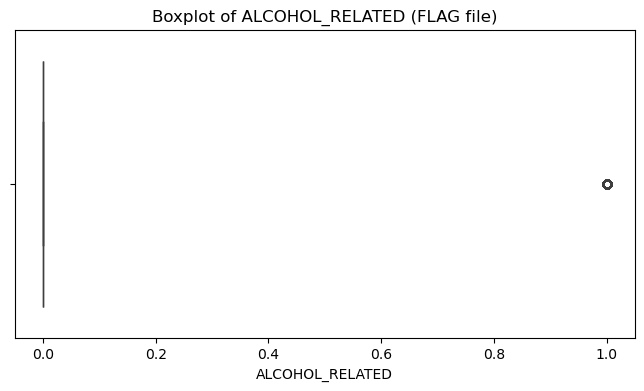

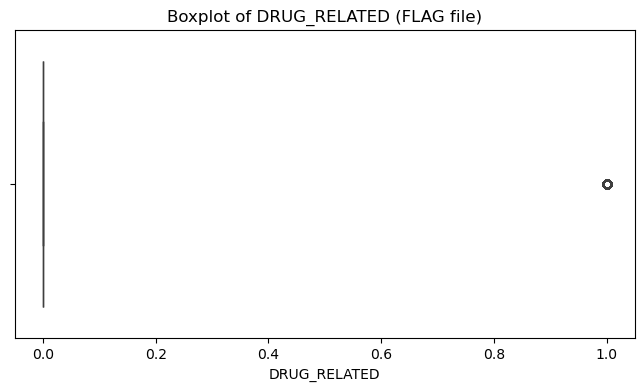

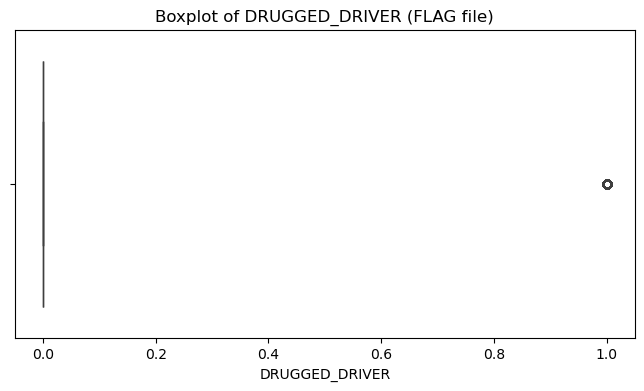

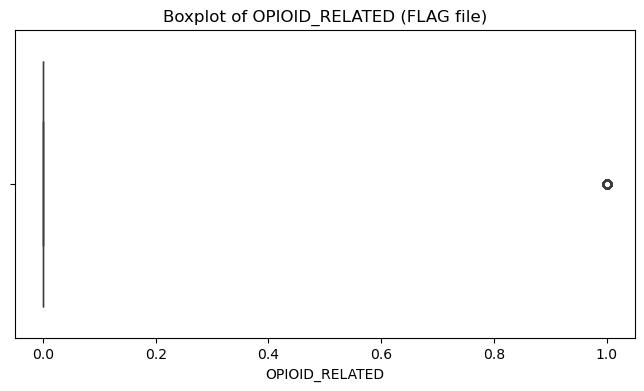

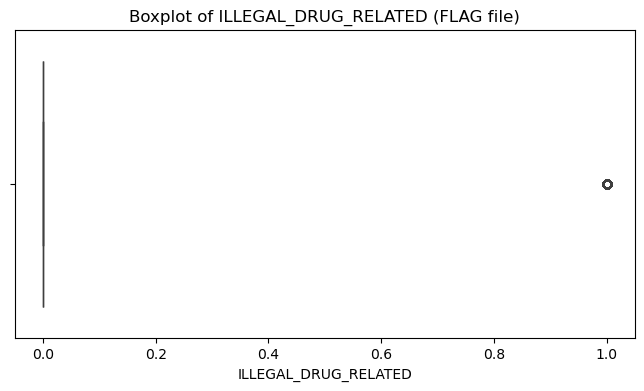

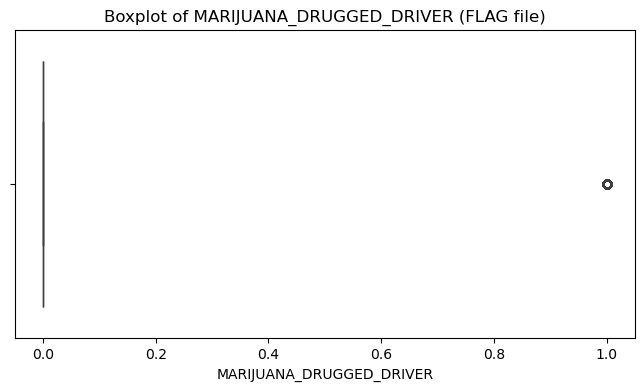

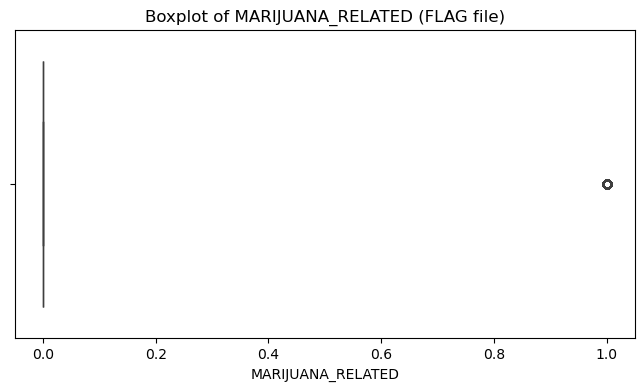

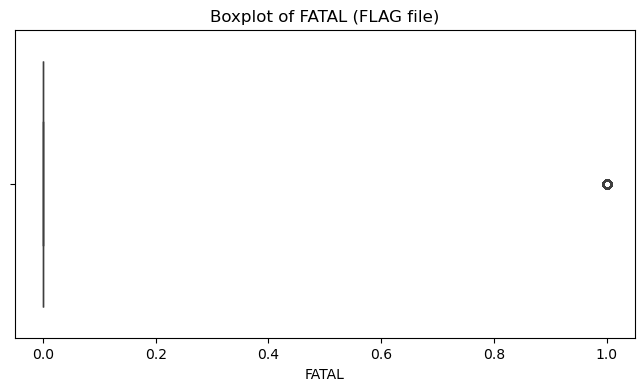

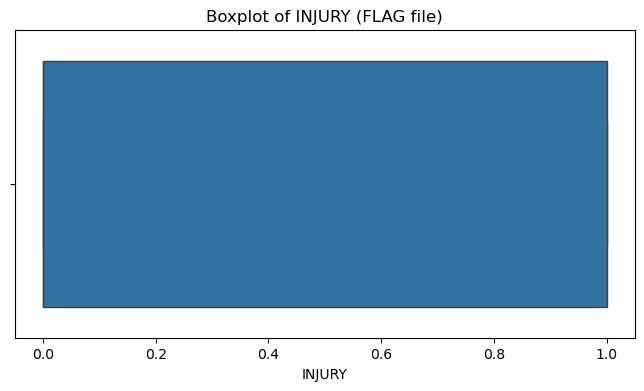

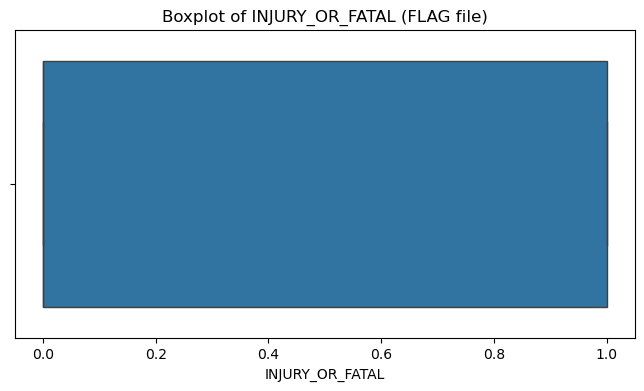

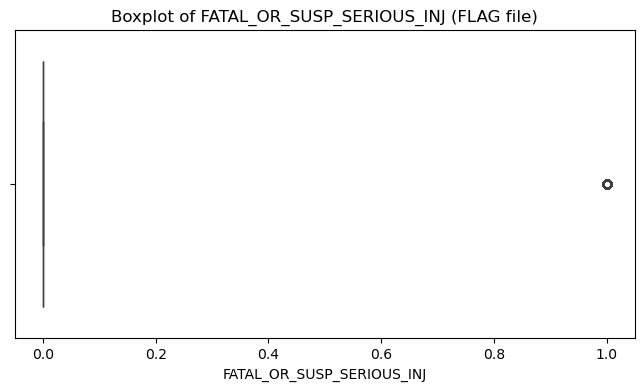

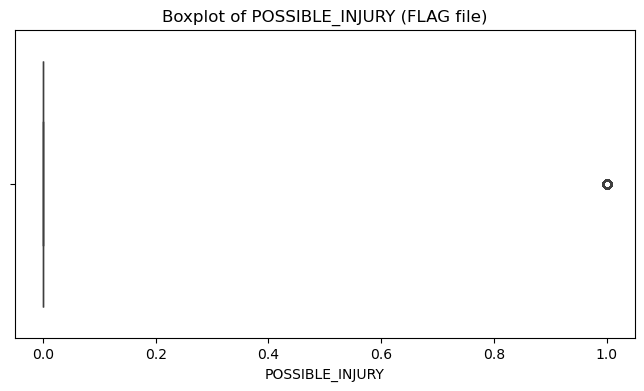

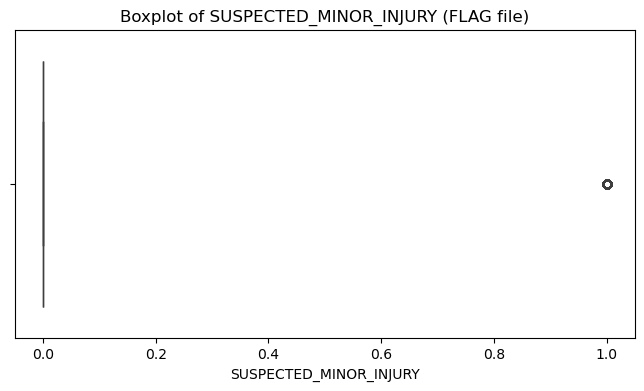

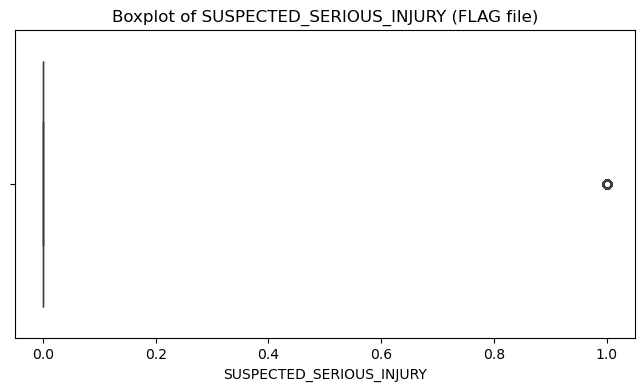

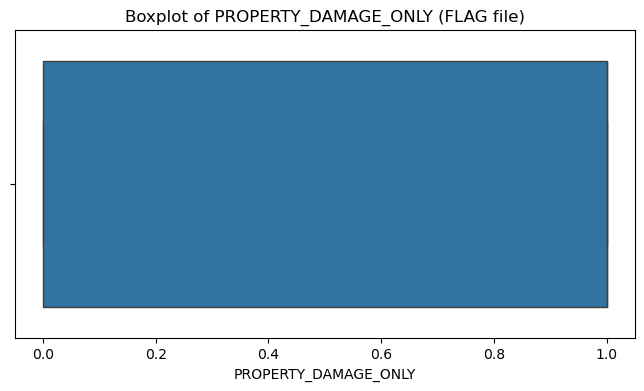

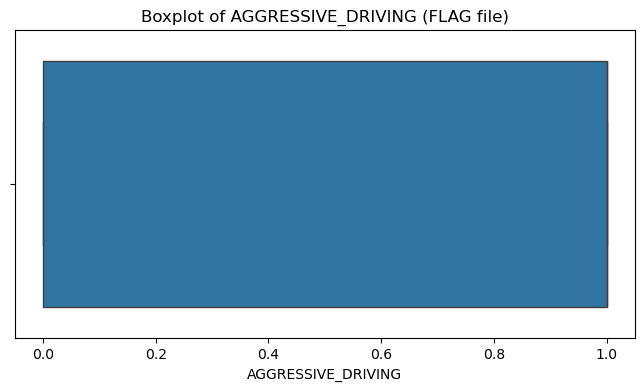

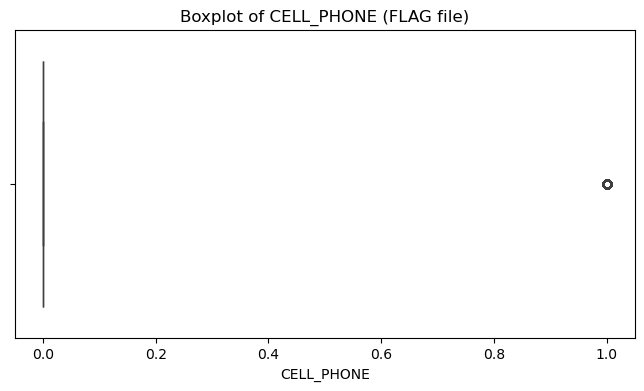

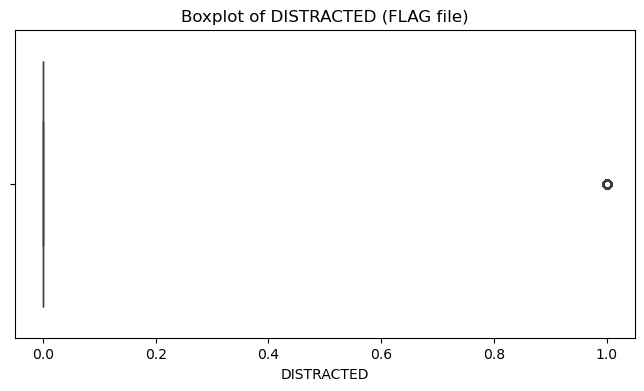

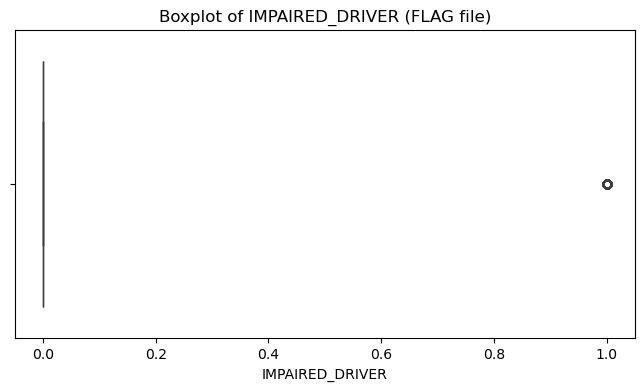

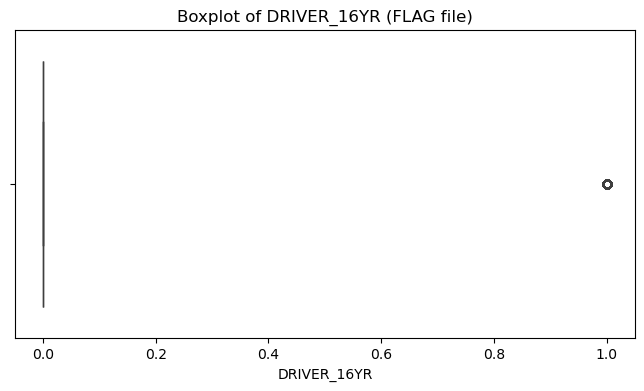

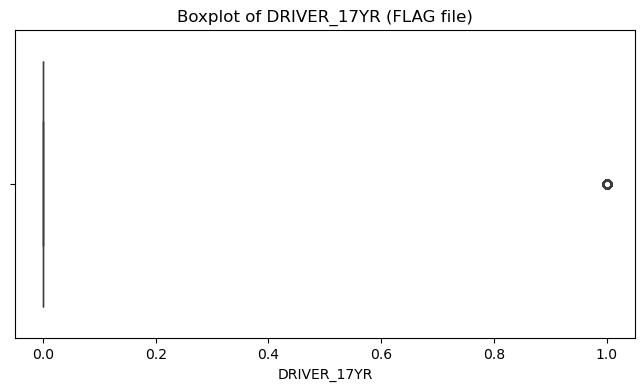

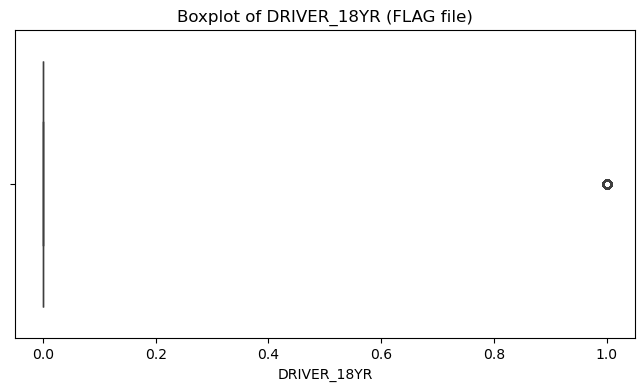

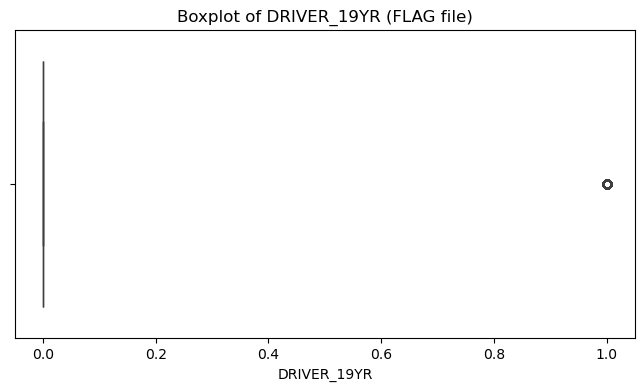

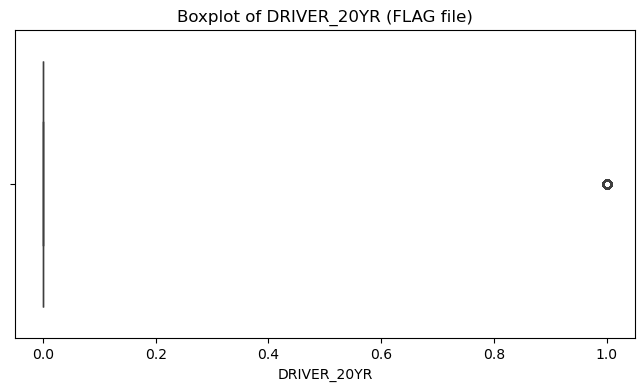

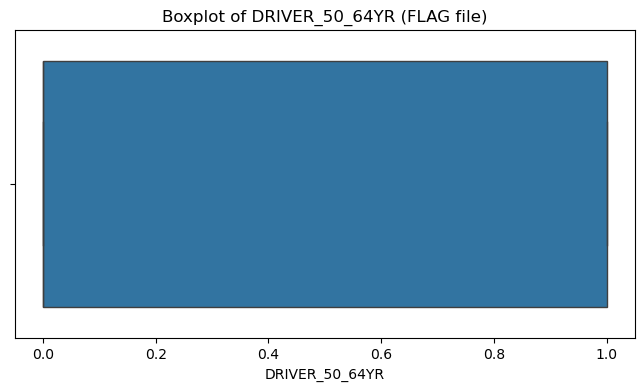

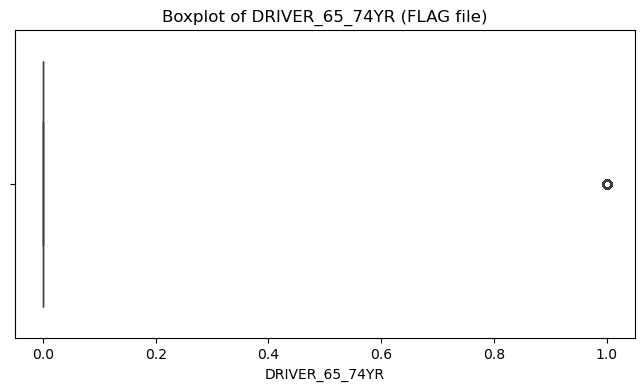

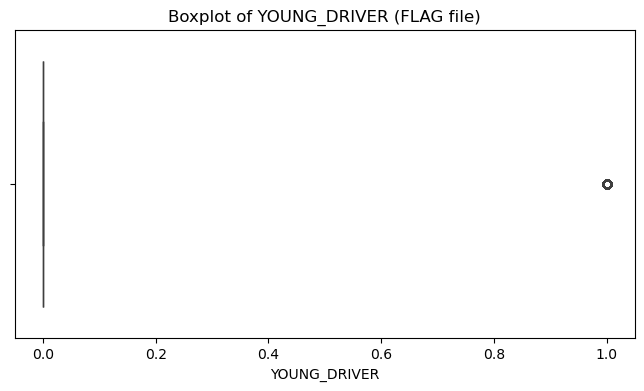

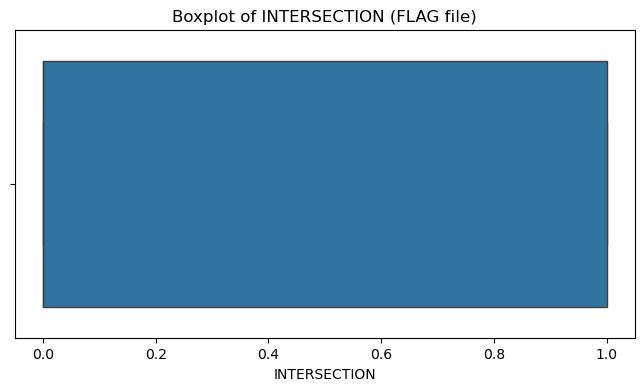

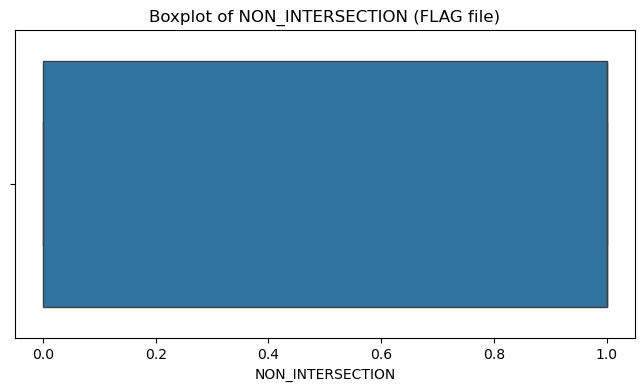

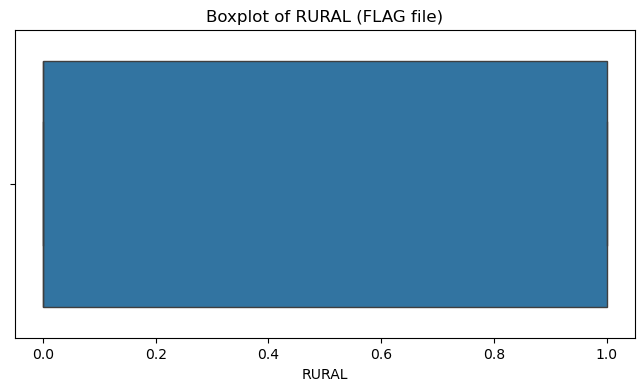

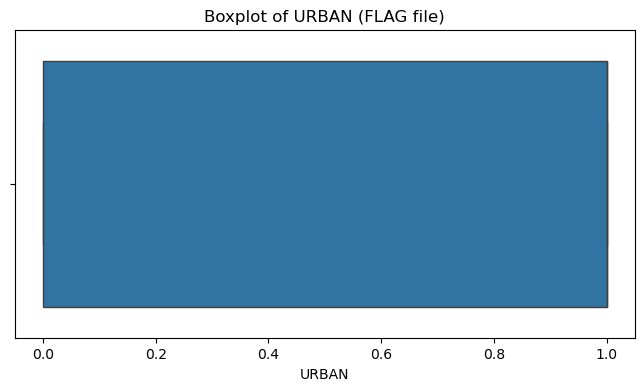

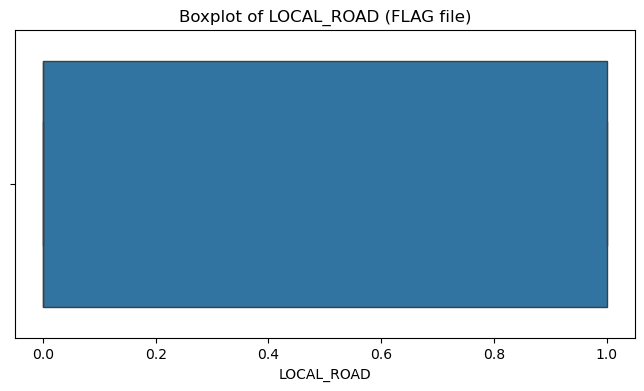

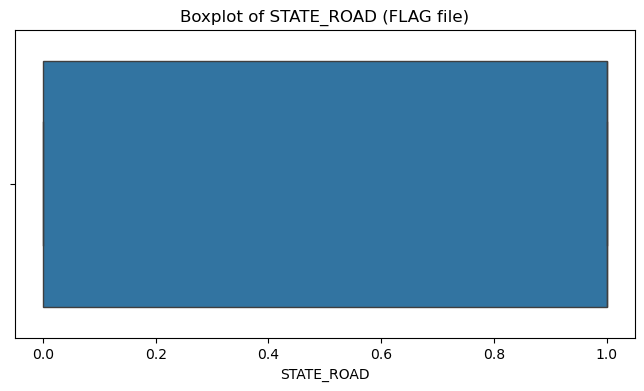

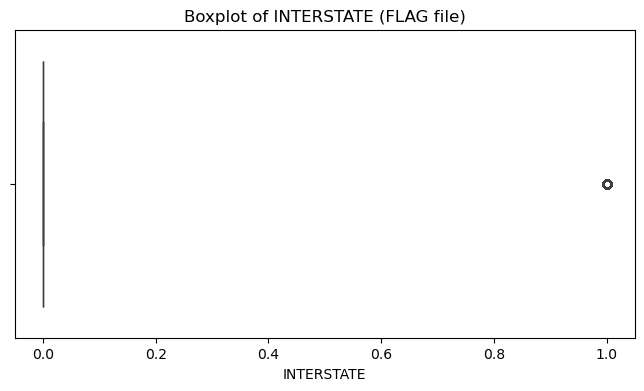

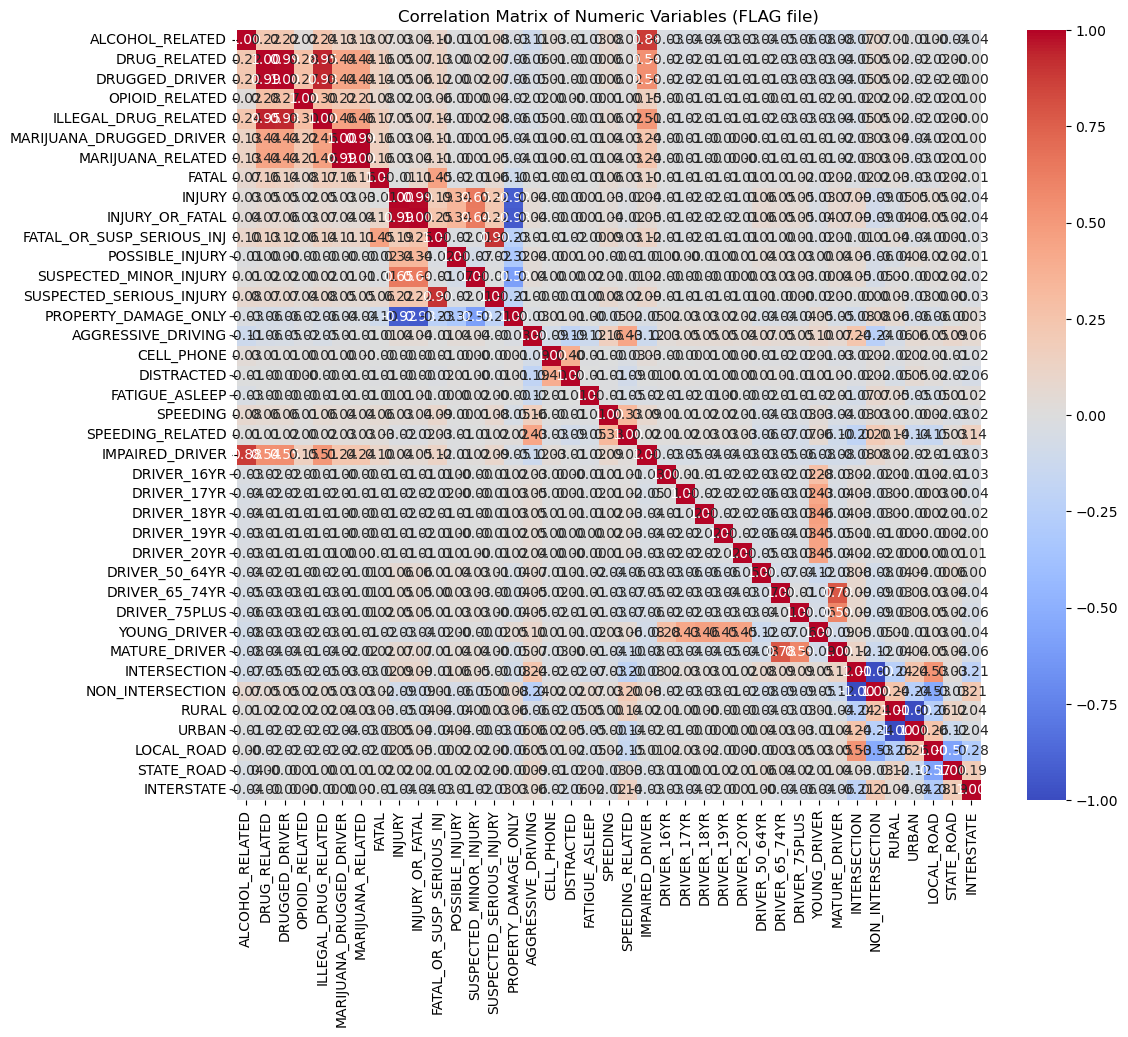

C:\Users\jason\anaconda3\envs\DeepL\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Variance Inflation Factor (VIF) for numeric features (FLAG file):
                      Feature         VIF
0             ALCOHOL_RELATED    9.069447
1                DRUG_RELATED   53.709742
2              DRUGGED_DRIVER   47.379703
3              OPIOID_RELATED    1.138181
4        ILLEGAL_DRUG_RELATED   10.456653
5    MARIJUANA_DRUGGED_DRIVER   93.427026
6           MARIJUANA_RELATED   93.339756
7                       FATAL    6.531388
8                      INJURY  131.587295
9             INJURY_OR_FATAL  164.100421
10  FATAL_OR_SUSP_SERIOUS_INJ   48.896378
11            POSSIBLE_INJURY    1.431084
12     SUSPECTED_MINOR_INJURY    2.239830
13   SUSPECTED_SERIOUS_INJURY   39.450794
14       PROPERTY_DAMAGE_ONLY    7.536645
15         AGGRESSIVE_DRIVING    1.557607
16                 CELL_PHONE    1.189733
17                 DISTRACTED    1.237395
18             FATIGUE_ASLEEP    1.024430
19                   SPEEDING    1.156241
20           SPEEDING_RELATED    1.584232
21       

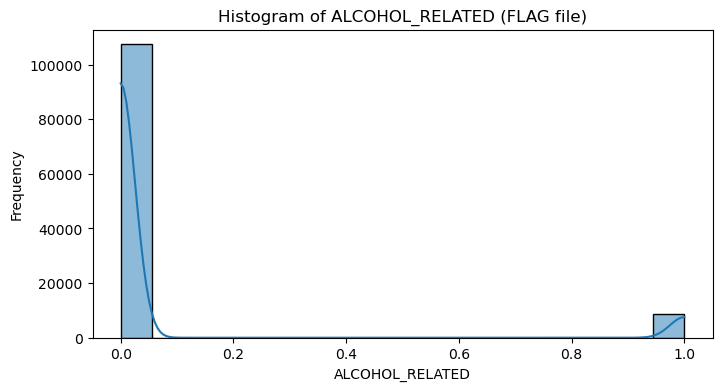

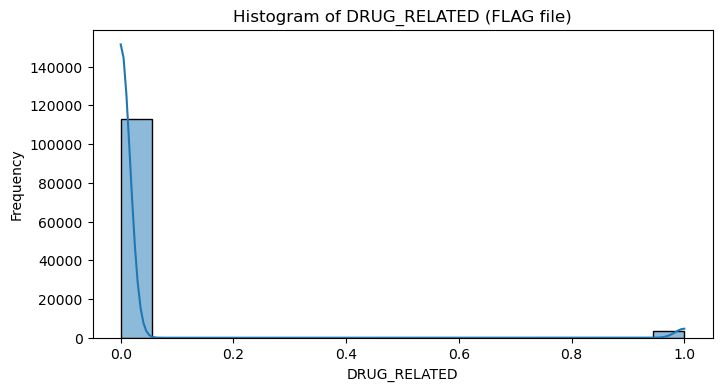

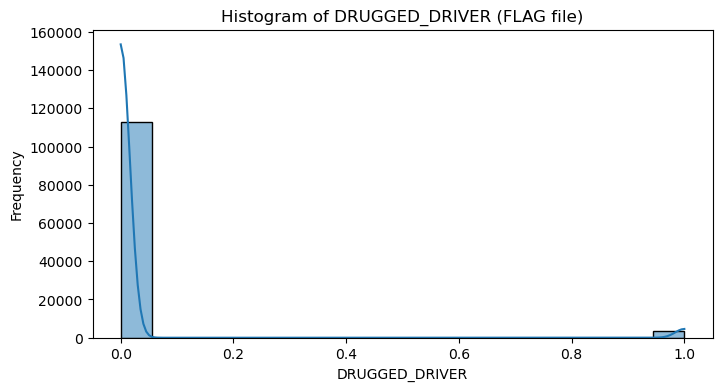

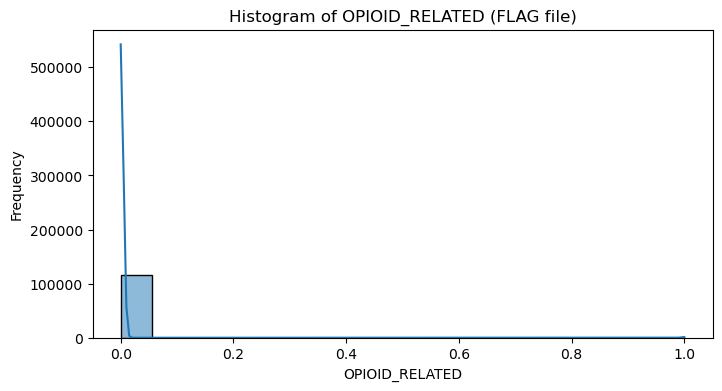

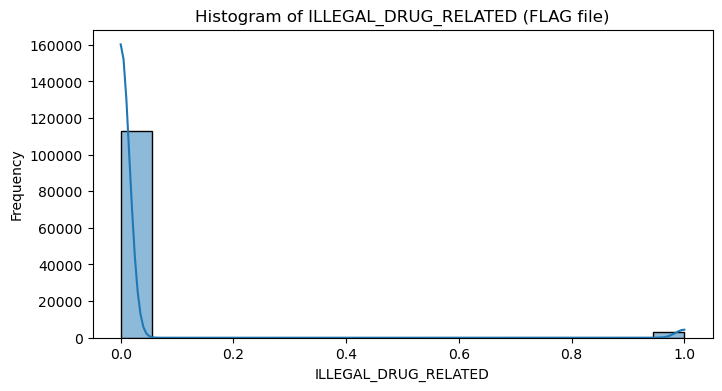

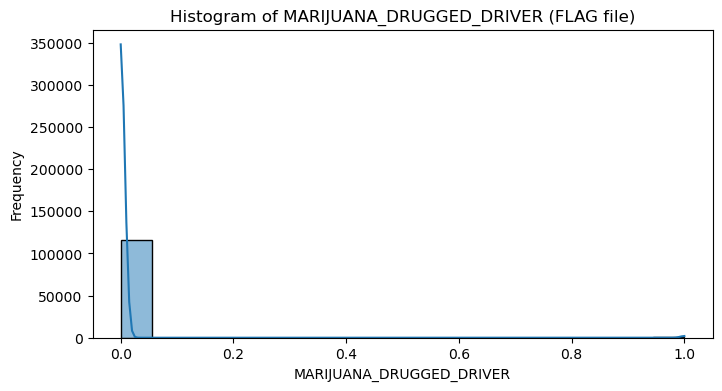

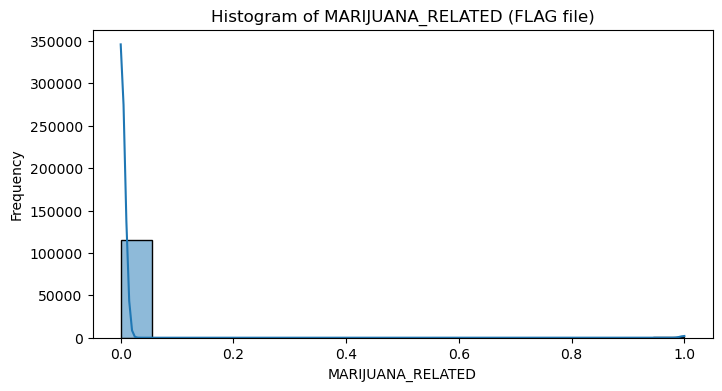

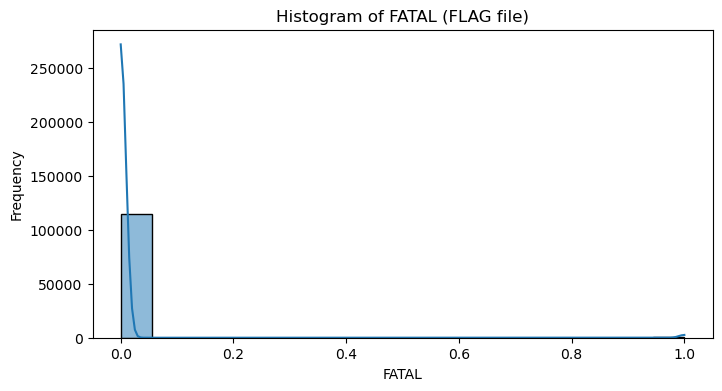

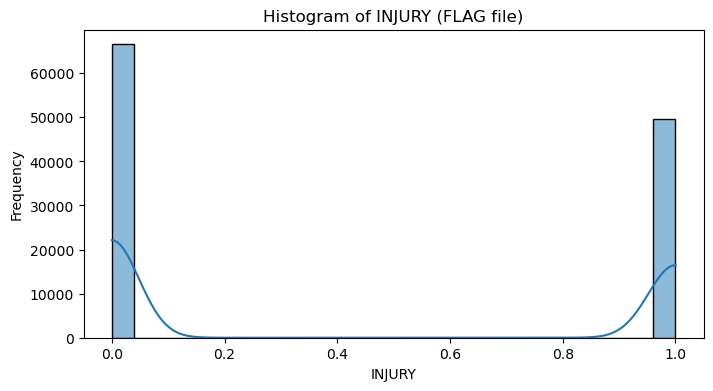

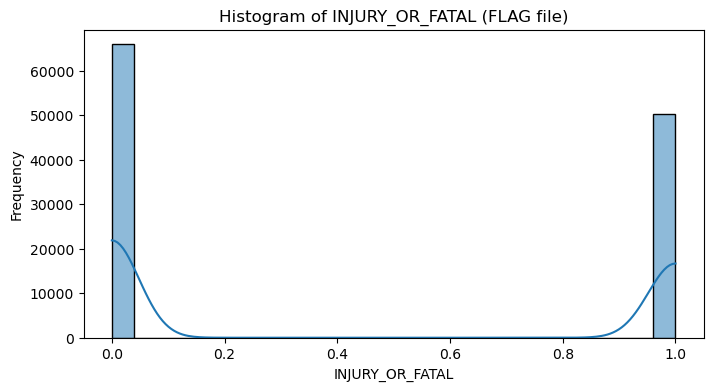

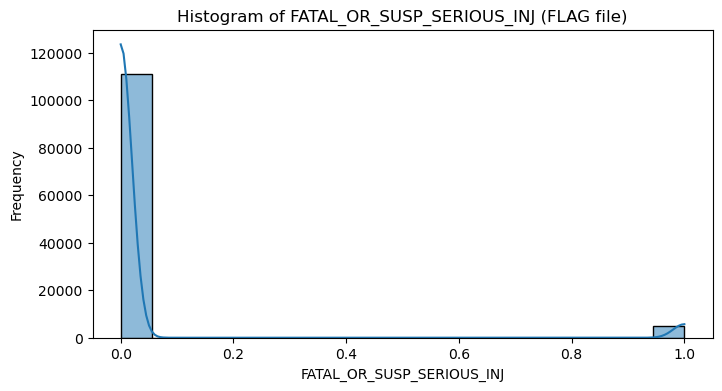

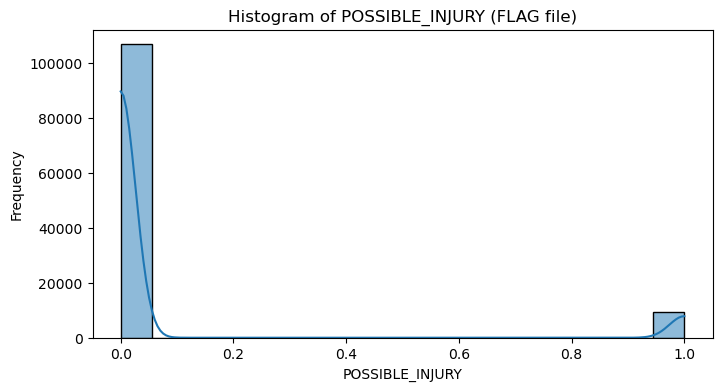

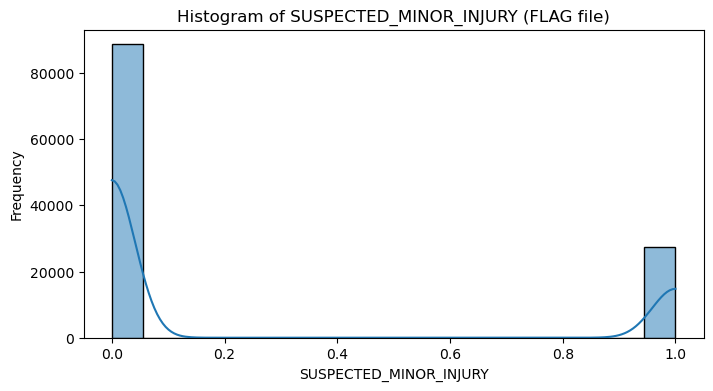

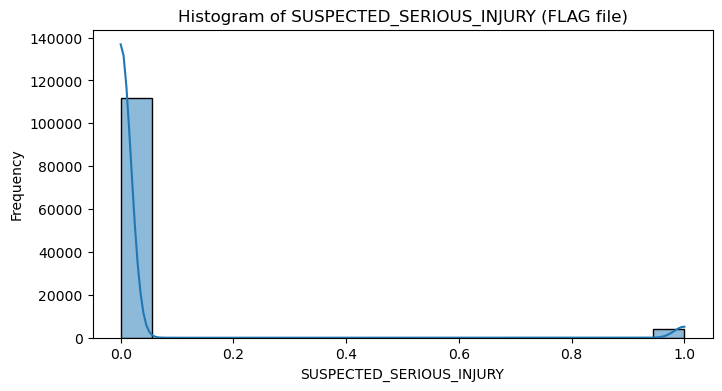

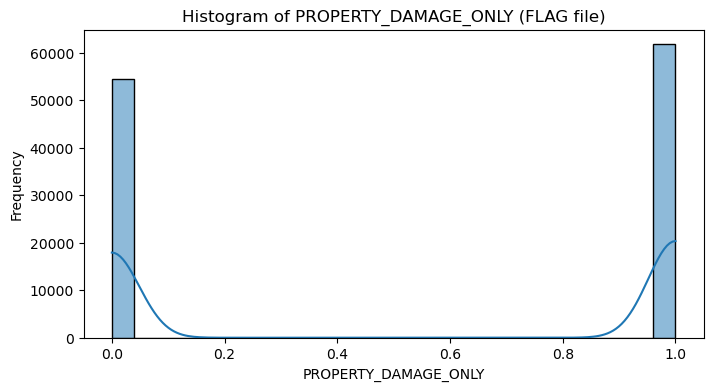

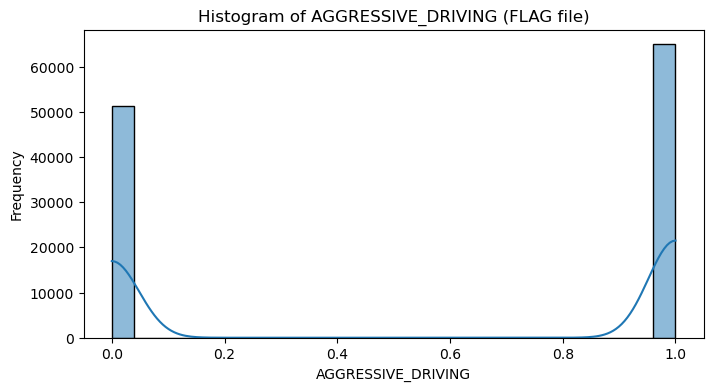

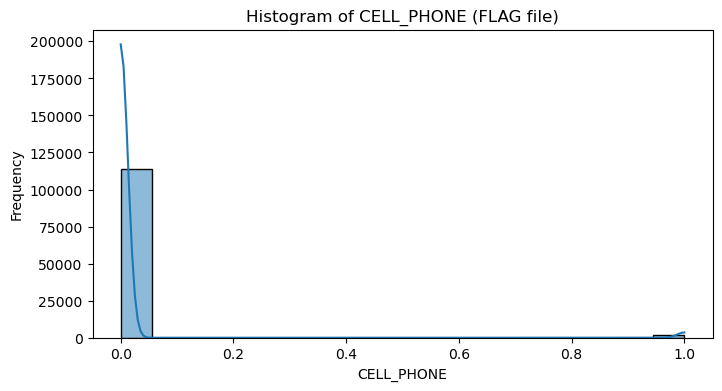

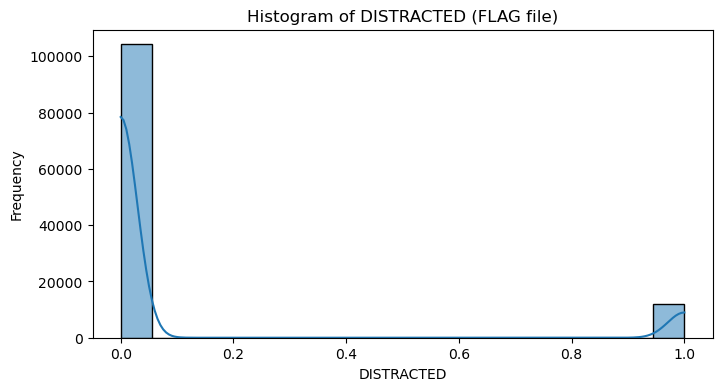

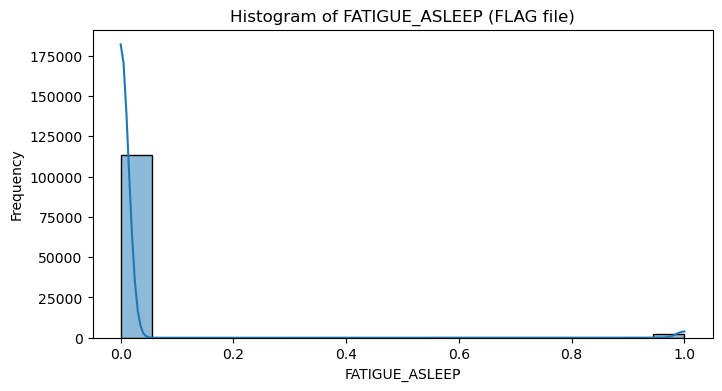

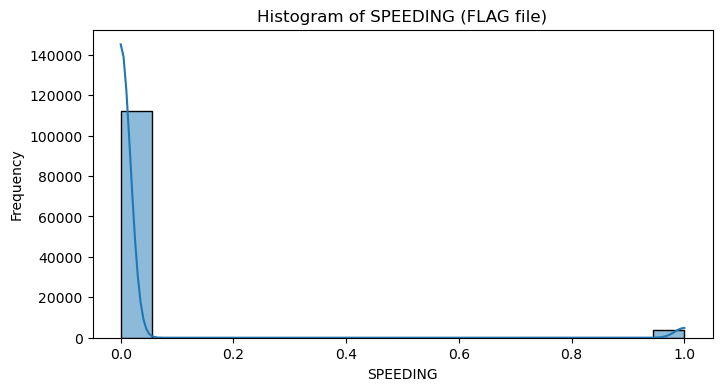

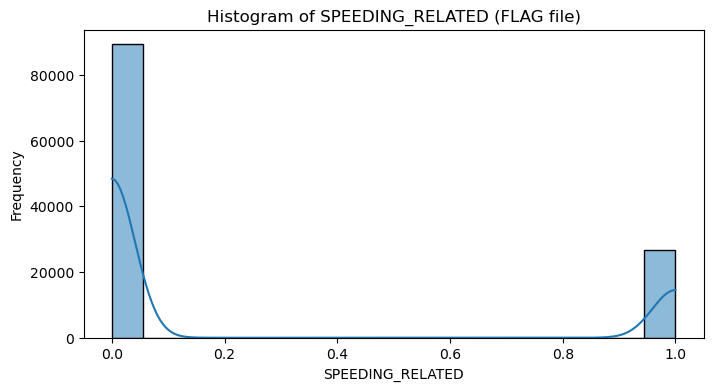

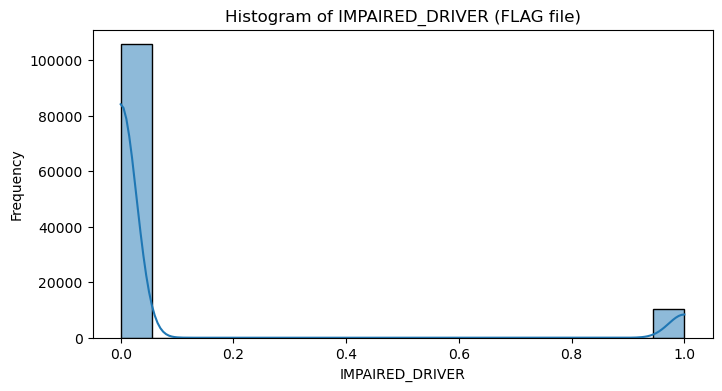

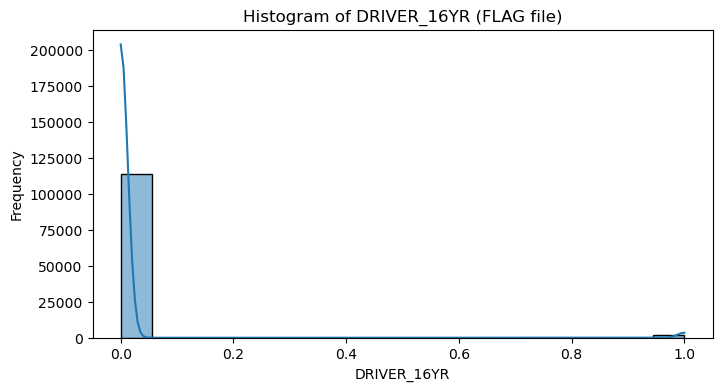

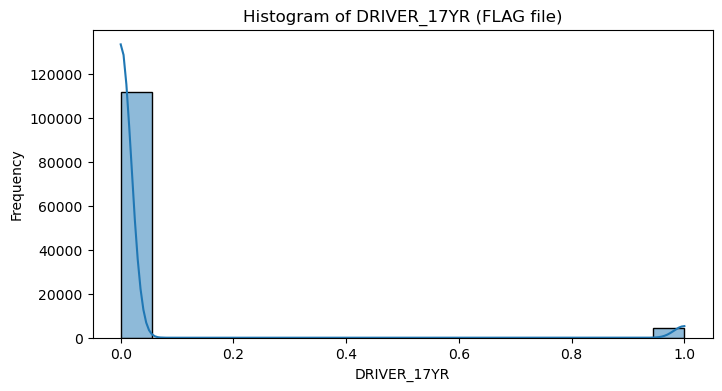

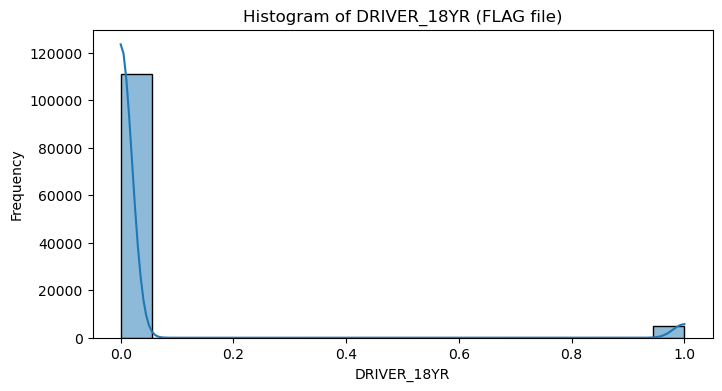

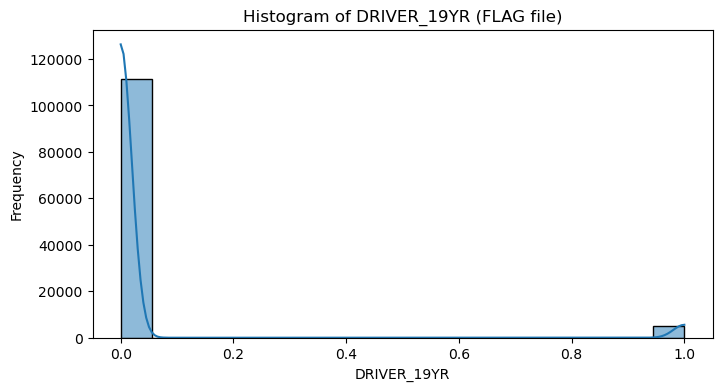

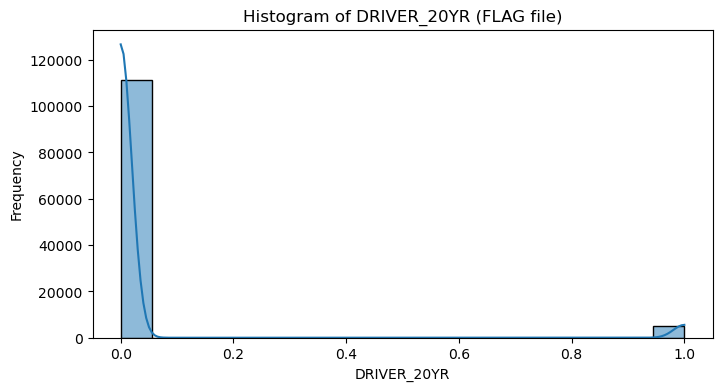

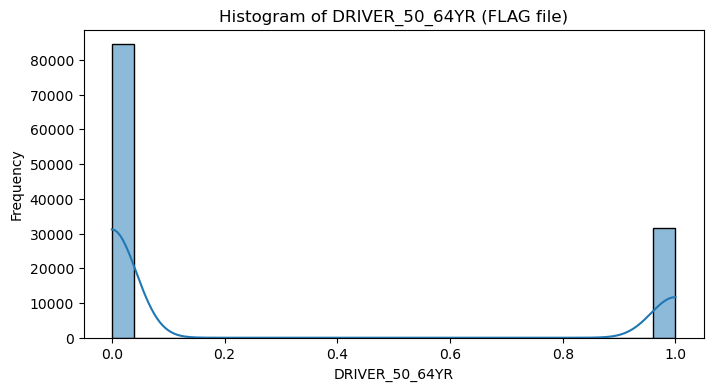

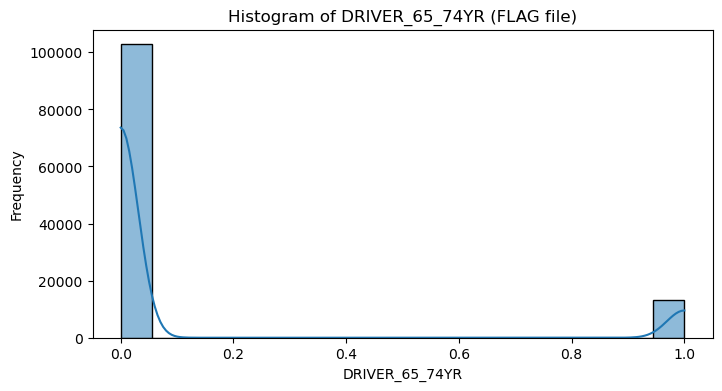

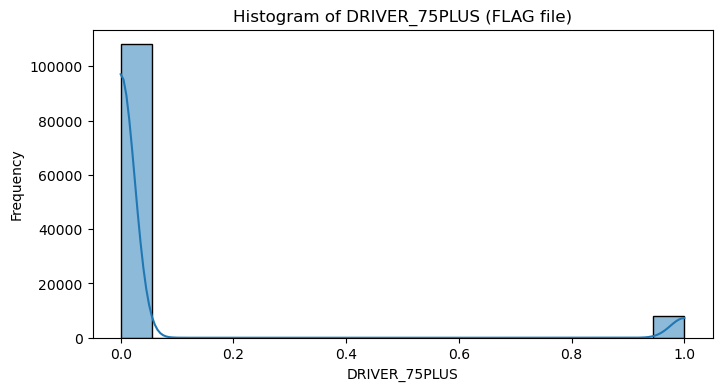

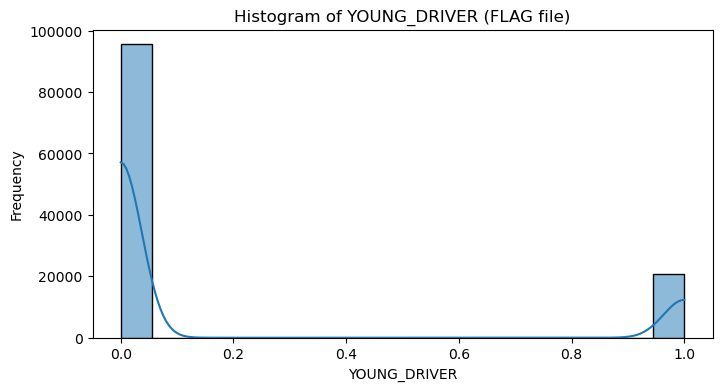

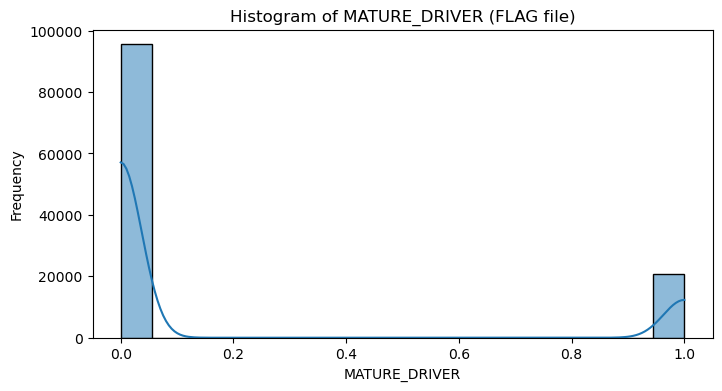

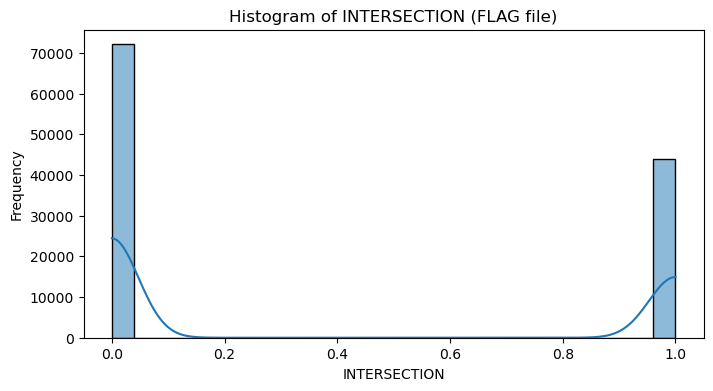

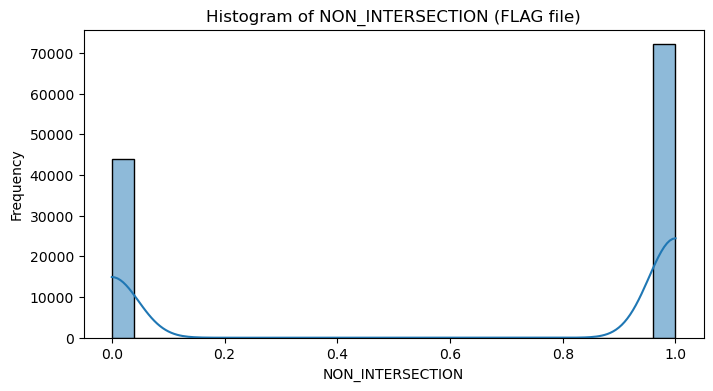

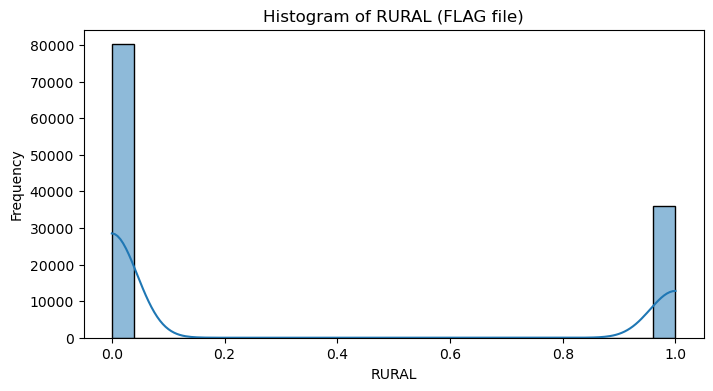

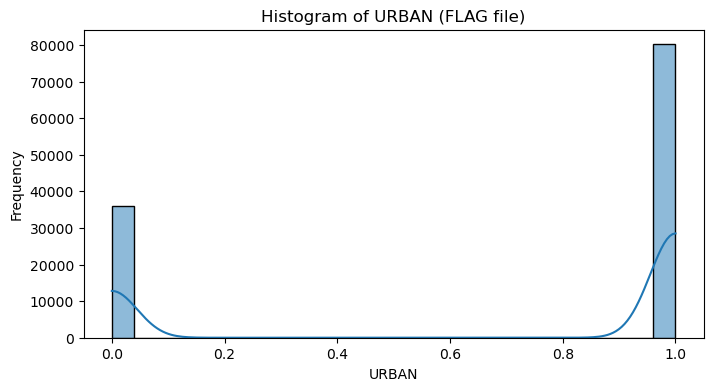

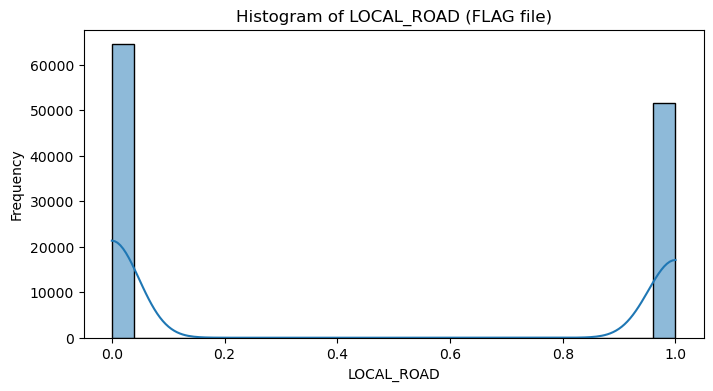

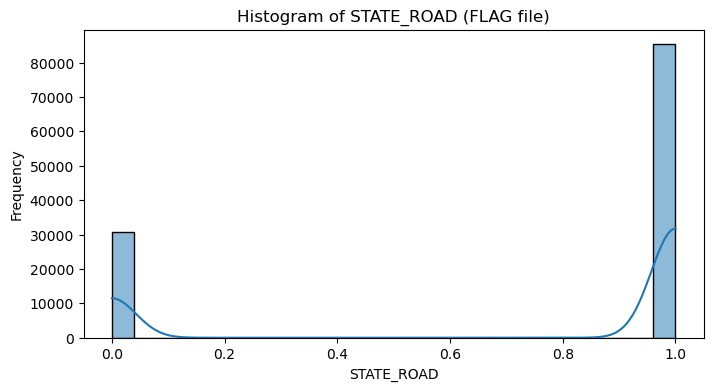

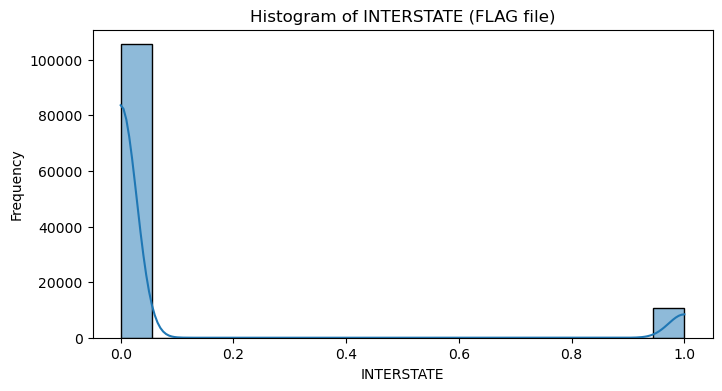


Distribution for 'AGGRESSIVE_DRIVING':
AGGRESSIVE_DRIVING
1    55.91
0    44.09
Name: count, dtype: float64


C:\Users\jason\AppData\Local\Temp\ipykernel_22248\2909666435.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="pastel")


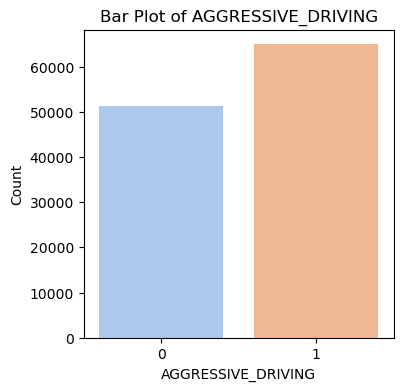


Distribution for 'ALCOHOL_RELATED':
ALCOHOL_RELATED
0    92.5
1     7.5
Name: count, dtype: float64


C:\Users\jason\AppData\Local\Temp\ipykernel_22248\2909666435.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="pastel")


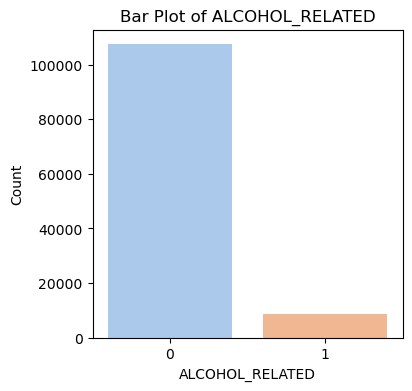

C:\Users\jason\AppData\Local\Temp\ipykernel_22248\2909666435.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="pastel")



Distribution for 'DRUGGED_DRIVER':
DRUGGED_DRIVER
0    97.1
1     2.9
Name: count, dtype: float64


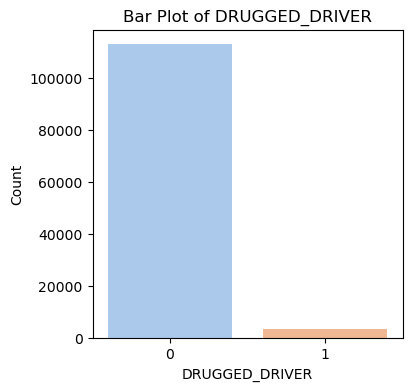


Distribution for 'DRUG_RELATED':
DRUG_RELATED
0    97.03
1     2.97
Name: count, dtype: float64


C:\Users\jason\AppData\Local\Temp\ipykernel_22248\2909666435.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="pastel")


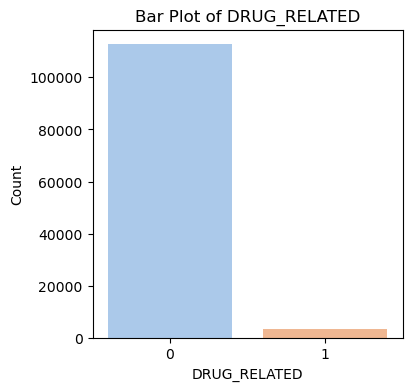


Distribution for 'OPIOID_RELATED':
OPIOID_RELATED
0    99.76
1     0.24
Name: count, dtype: float64


C:\Users\jason\AppData\Local\Temp\ipykernel_22248\2909666435.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="pastel")


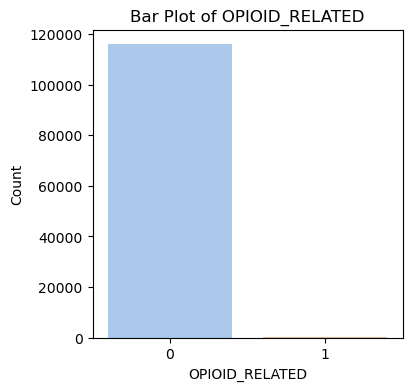


No column name formatting issues detected (FLAG file).

Potential Bias Check (FLAG file):
OPIOID_RELATED distribution (%):
OPIOID_RELATED
0    99.76
1     0.24
Name: proportion, dtype: float64

Planned Cleaning Steps:
- Missing Values: Impute or recode placeholders if needed (e.g., recode -1/9999 to NaN or an appropriate default).
- Duplicates: Remove duplicate rows.
- Outliers: Investigate columns with high outlier counts (e.g., in CRN, WET_ROAD, YOUNG_DRIVER) to decide whether to cap or remove extreme values.
- Collinearity: Review features with high VIF values; consider combining or dropping highly correlated features.
- Data Imbalance: Binary columns with severe imbalance may require resampling or weighting adjustments.
- Formatting: Ensure column names are trimmed and standardized; if additional text fields are present, trim whitespace and standardize capitalization.
- Type Conversions: Confirm that date/time, numeric, and categorical columns have the correct data types.
- Linkag

In [97]:
# Additional Common Analyses (Example on FLAG file DataFrame)

# Outlier Detection (IQR Method) for numeric columns in df_flag
numeric_cols_flag = df_flag.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns in FLAG file:", numeric_cols_flag)

def detect_outliers(col, df):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    return outlier_count, lower_bound, upper_bound

outlier_summary_flag = {}
for col in numeric_cols_flag:
    count, lb, ub = detect_outliers(col, df_flag)
    outlier_summary_flag[col] = {"Outlier Count": count, "Lower Bound": lb, "Upper Bound": ub}
print("\nOutlier Summary for FLAG file:")
print(pd.DataFrame(outlier_summary_flag).T)

# Plot boxplots for numeric columns in FLAG file
for col in numeric_cols_flag:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_flag[col])
    plt.title(f"Boxplot of {col} (FLAG file)")
    plt.show()

# Correlation Matrix and VIF Calculation for FLAG file
df_vif_flag = df_flag[numeric_cols_flag].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(12, 10))
corr_matrix_flag = df_flag[numeric_cols_flag].corr()
sns.heatmap(corr_matrix_flag, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Variables (FLAG file)")
plt.show()

vif_data_flag = pd.DataFrame()
vif_data_flag["Feature"] = numeric_cols_flag
vif_data_flag["VIF"] = [variance_inflation_factor(df_vif_flag.values, i) for i in range(len(numeric_cols_flag))]
print("\nVariance Inflation Factor (VIF) for numeric features (FLAG file):")
print(vif_data_flag)

# Distribution Analysis for Numeric Columns (FLAG file)
for col in numeric_cols_flag:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_flag[col], kde=True)
    plt.title(f"Histogram of {col} (FLAG file)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Analyze binary column distributions in FLAG file
binary_columns = ['AGGRESSIVE_DRIVING', 'ALCOHOL_RELATED', 'ANGLE_CRASH', 'ATV',
                  'DRUGGED_DRIVER', 'DRUG_RELATED', 'OPIOID_RELATED']
def analyze_binary_distribution(col, df):
    counts = df[col].value_counts()
    total = counts.sum()
    distribution = (counts / total * 100).round(2)
    print(f"\nDistribution for '{col}':")
    print(distribution)
    plt.figure(figsize=(4, 4))
    sns.barplot(x=counts.index, y=counts.values, palette="pastel")
    plt.title(f"Bar Plot of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

for col in binary_columns:
    if col in df_flag.columns:
        analyze_binary_distribution(col, df_flag)

# Check column name formatting issues (applied to FLAG file)
def check_column_name_format(col_name):
    if col_name != col_name.strip():
        return f"Column '{col_name}' has leading/trailing whitespace."
    if re.search(r"[^a-zA-Z0-9_]", col_name):
        return f"Column '{col_name}' contains non-alphanumeric characters."
    return None

format_issues = [check_column_name_format(col) for col in df_flag.columns if check_column_name_format(col) is not None]
if format_issues:
    print("\nColumn Name Formatting Issues (FLAG file):")
    for issue in format_issues:
        print(issue)
else:
    print("\nNo column name formatting issues detected (FLAG file).")

# Potential Bias Check (FLAG file): For example, check the distribution of 'OPIOID_RELATED'
print("\nPotential Bias Check (FLAG file):")
if 'OPIOID_RELATED' in df_flag.columns:
    opioid_distribution = df_flag['OPIOID_RELATED'].value_counts(normalize=True) * 100
    print("OPIOID_RELATED distribution (%):")
    print(opioid_distribution.round(2))
    if opioid_distribution.min() < 10:
        print("Warning: One class in 'OPIOID_RELATED' is underrepresented, which may indicate sampling bias.")
else:
    print("No 'OPIOID_RELATED' column found to check for bias.")

# Summary of Planned Data Cleaning Steps
cleaning_steps = {
    "Missing Values": "Impute or recode placeholders if needed (e.g., recode -1/9999 to NaN or an appropriate default).",
    "Duplicates": "Remove duplicate rows.",
    "Outliers": "Investigate columns with high outlier counts (e.g., in CRN, WET_ROAD, YOUNG_DRIVER) to decide whether to cap or remove extreme values.",
    "Collinearity": "Review features with high VIF values; consider combining or dropping highly correlated features.",
    "Data Imbalance": "Binary columns with severe imbalance may require resampling or weighting adjustments.",
    "Formatting": "Ensure column names are trimmed and standardized; if additional text fields are present, trim whitespace and standardize capitalization.",
    "Type Conversions": "Confirm that date/time, numeric, and categorical columns have the correct data types.",
    "Linkage": "Verify that linking columns (e.g., CRN) correctly reference valid entries from CRASH files.",
    "Bias Considerations": "Note potential sampling or measurement biases (e.g., low representation in key binary outcomes) for later model adjustments."
}
print("\nPlanned Cleaning Steps:")
for step, detail in cleaning_steps.items():
    print(f"- {step}: {detail}")


--- Additional Analyses for CRASH File ---

Numeric columns in CRASH file: ['CRASH_MONTH', 'CRASH_YEAR', 'DAY_OF_WEEK', 'HOUR_OF_DAY', 'COUNTY', 'MUNICIPALITY', 'DISTRICT', 'DEC_LAT', 'DEC_LONG', 'MAX_SEVERITY_LEVEL', 'COLLISION_TYPE', 'RELATION_TO_ROAD', 'ROAD_CONDITION', 'ILLUMINATION', 'URBAN_RURAL', 'DRIVER_COUNT_16YR', 'DRIVER_COUNT_17YR', 'DRIVER_COUNT_18YR', 'DRIVER_COUNT_19YR', 'DRIVER_COUNT_20YR', 'DRIVER_COUNT_50_64YR', 'DRIVER_COUNT_65_74YR', 'DRIVER_COUNT_75PLUS', 'FATAL_COUNT', 'INJURY_COUNT', 'TOT_INJ_COUNT', 'VEHICLE_COUNT', 'TOTAL_UNITS', 'AUTOMOBILE_COUNT', 'BICYCLE_COUNT', 'BUS_COUNT', 'COMM_VEH_COUNT', 'HEAVY_TRUCK_COUNT', 'MOTORCYCLE_COUNT', 'SMALL_TRUCK_COUNT', 'SUV_COUNT', 'VAN_COUNT', 'PERSON_COUNT']

Outlier Summary for CRASH file:
                      Outlier Count  Lower Bound  Upper Bound
CRASH_MONTH                     0.0      -5.0000      19.0000
CRASH_YEAR                      0.0    2022.0000    2022.0000
DAY_OF_WEEK                     0.0      -4.000

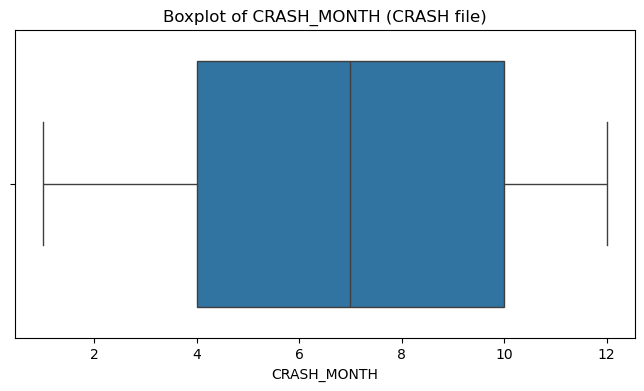

Skipping boxplot for CRASH_YEAR due to lack of variation.


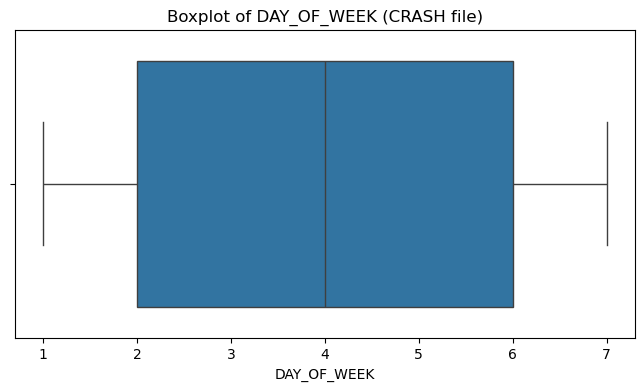

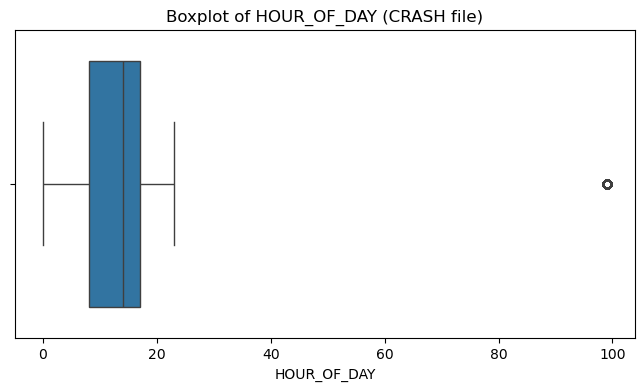

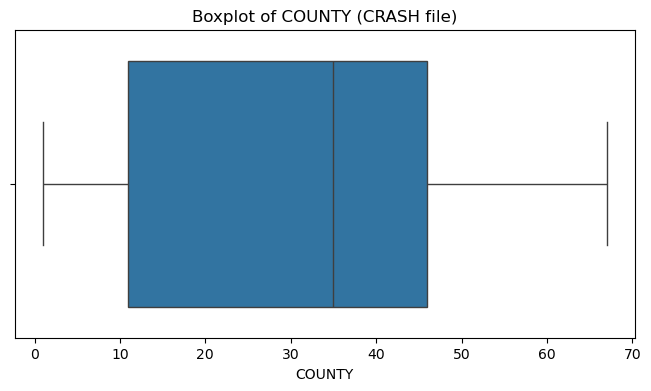

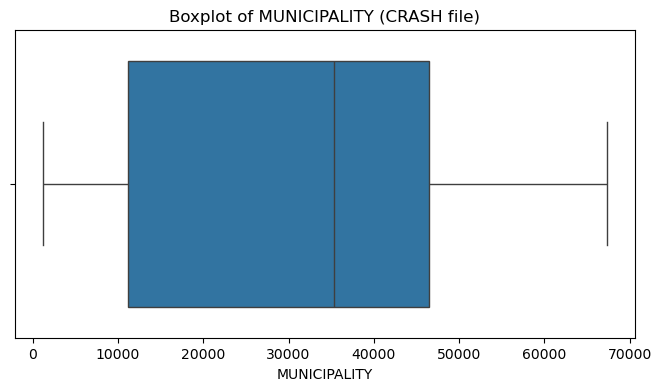

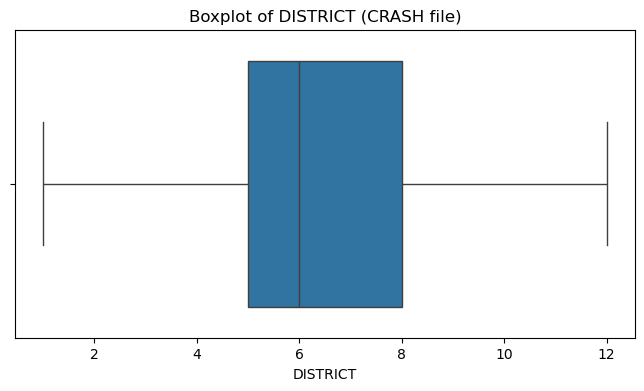

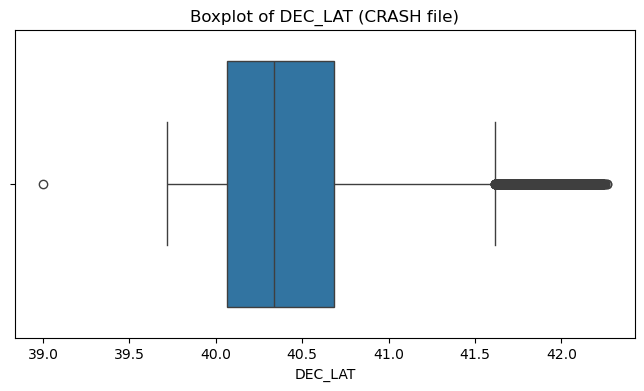

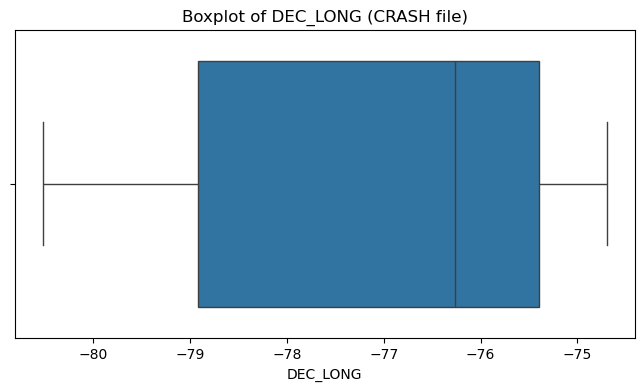

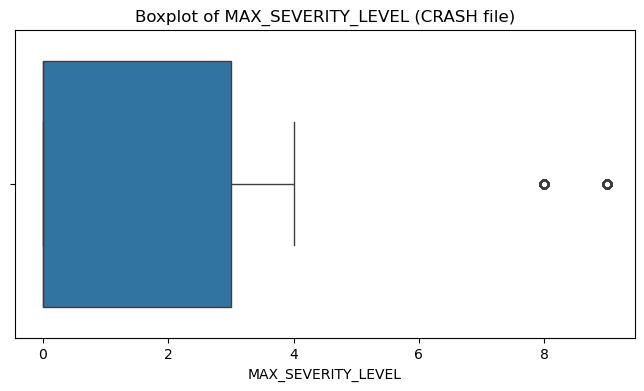

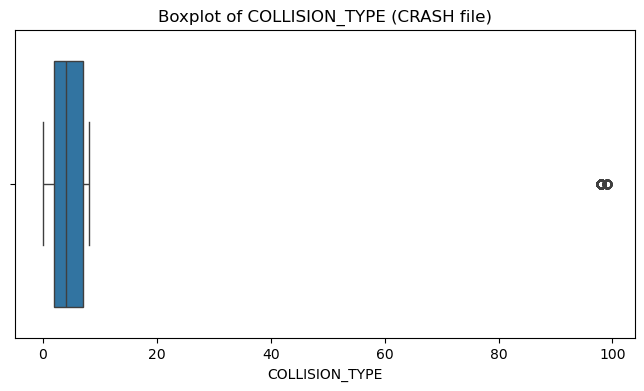

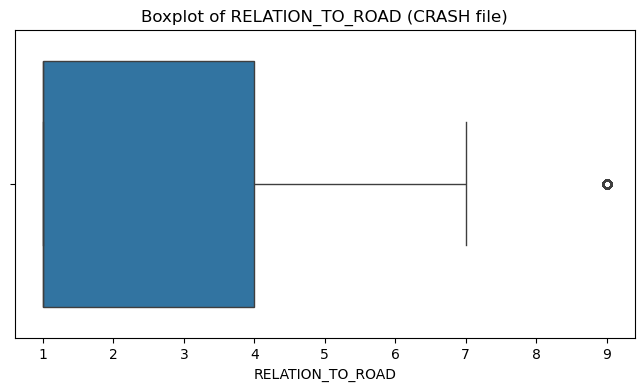

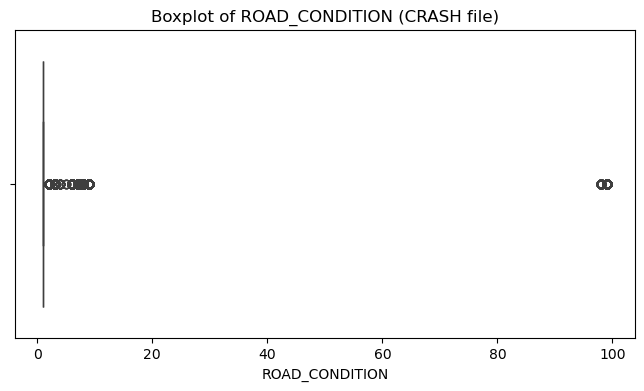

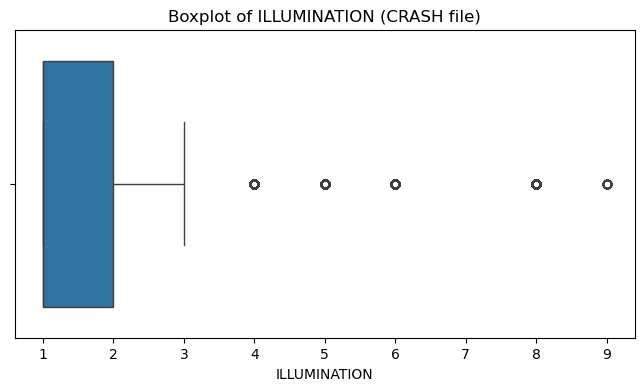

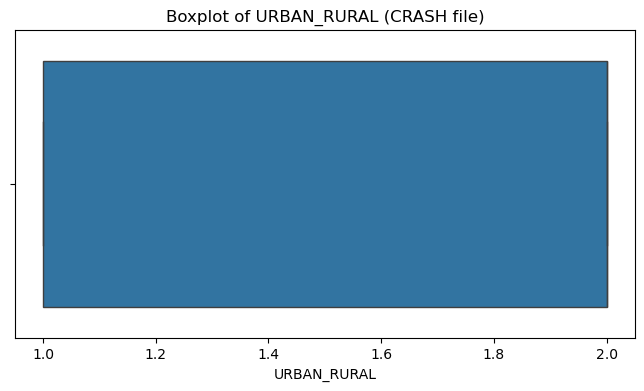

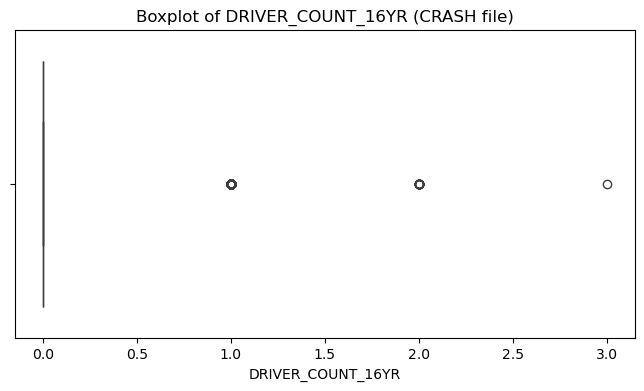

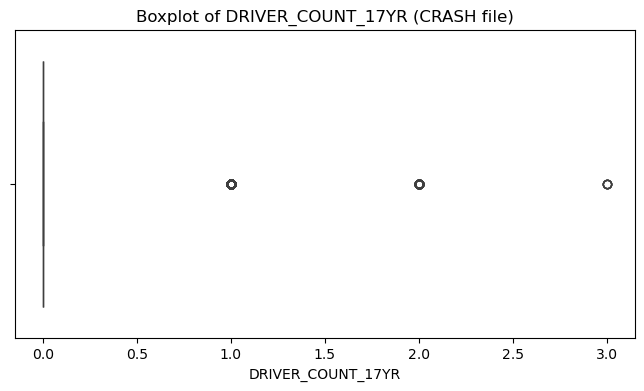

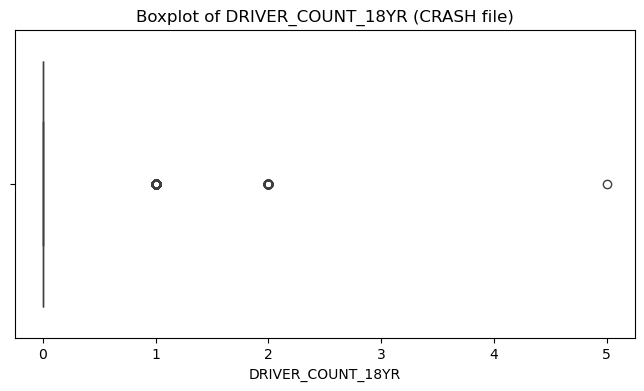

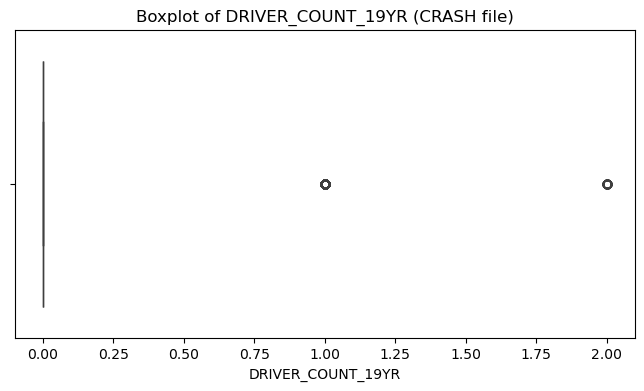

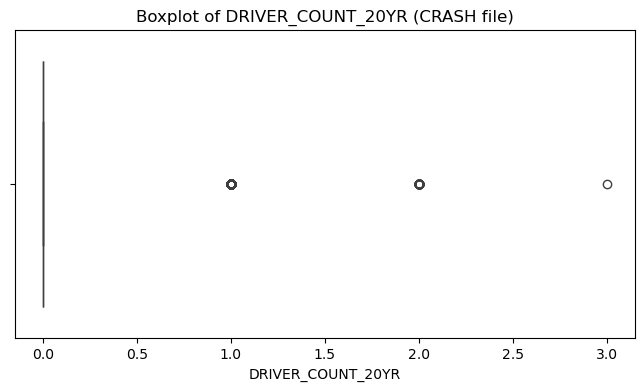

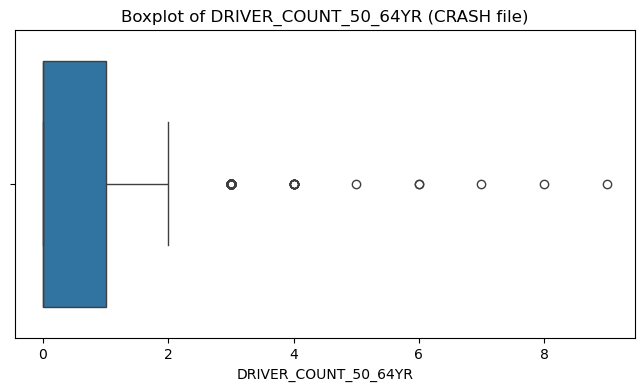

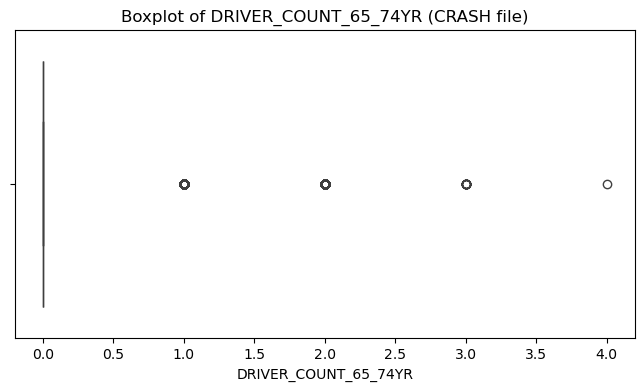

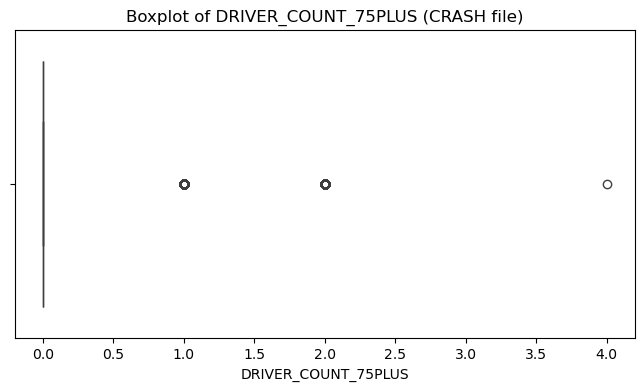

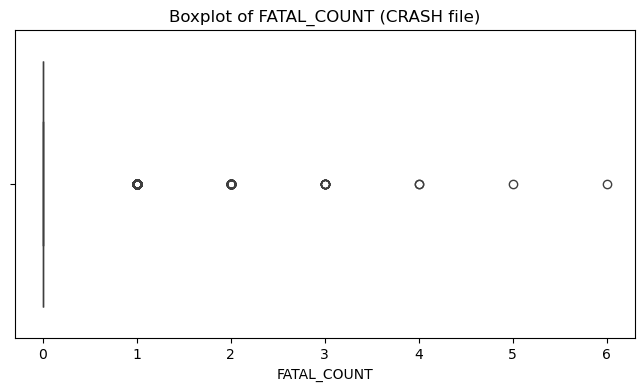

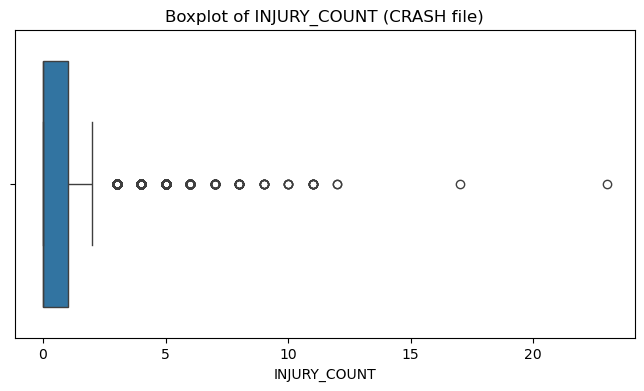

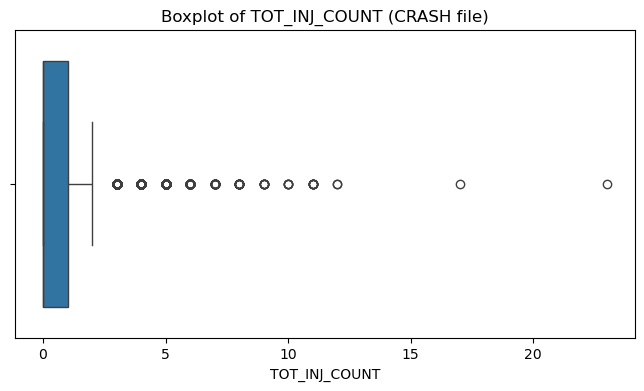

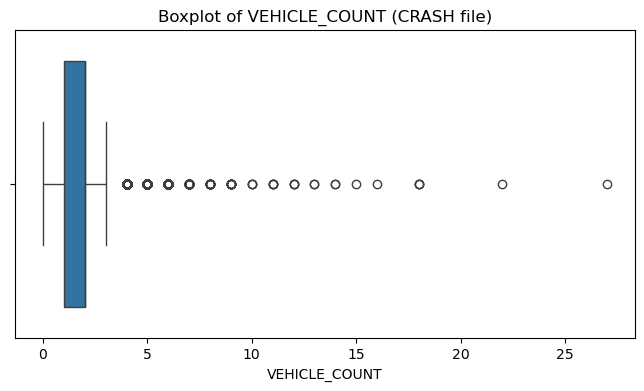

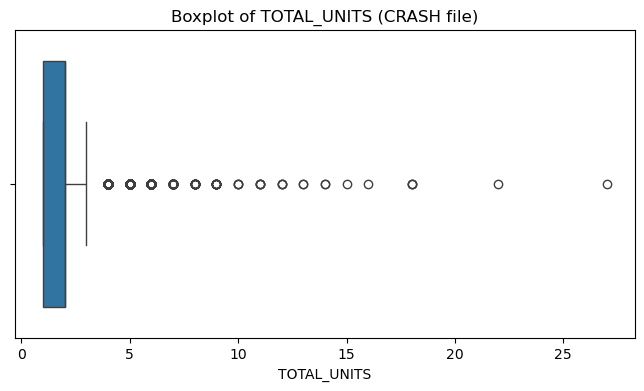

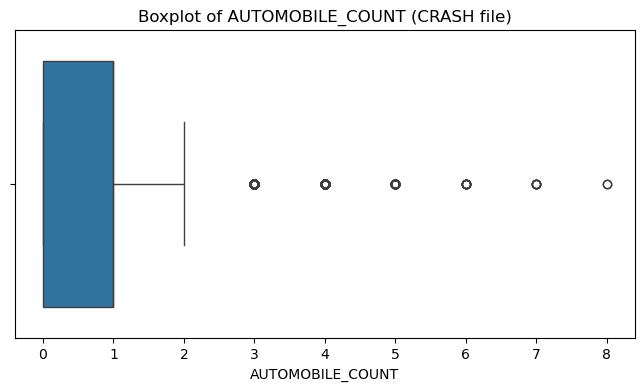

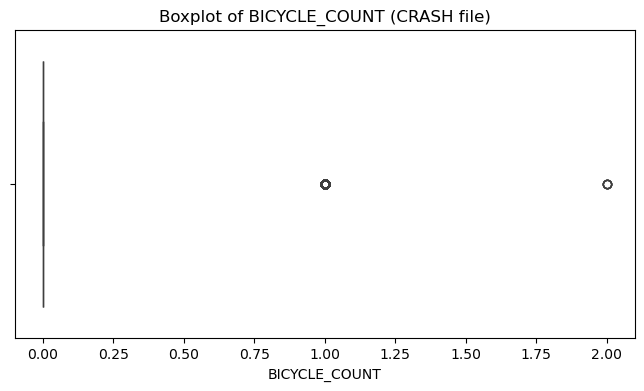

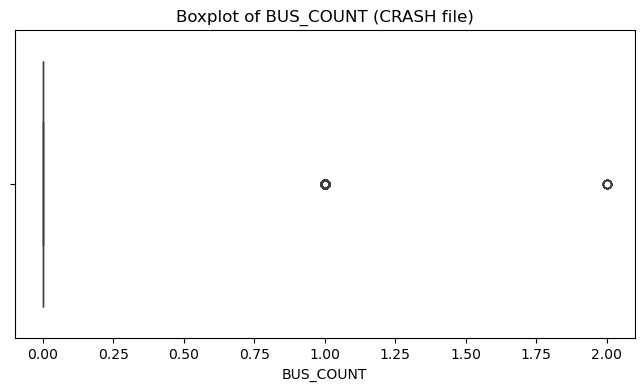

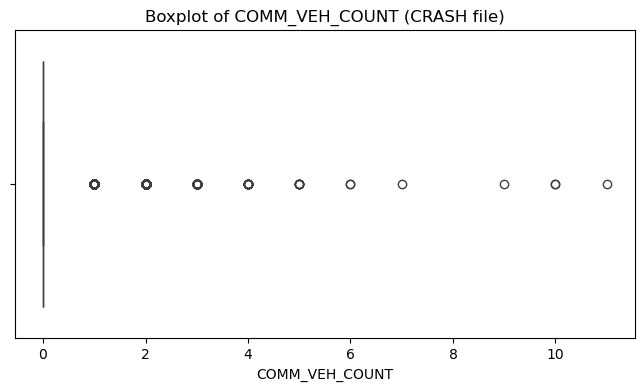

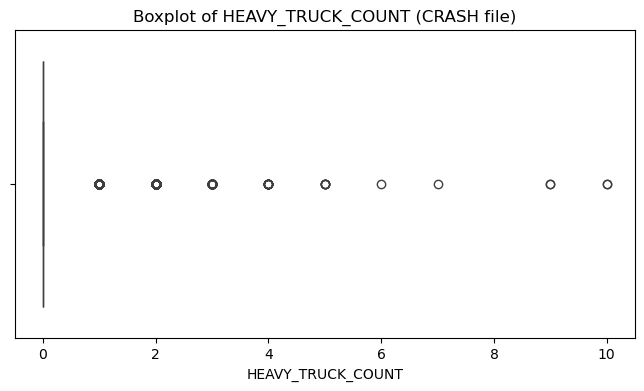

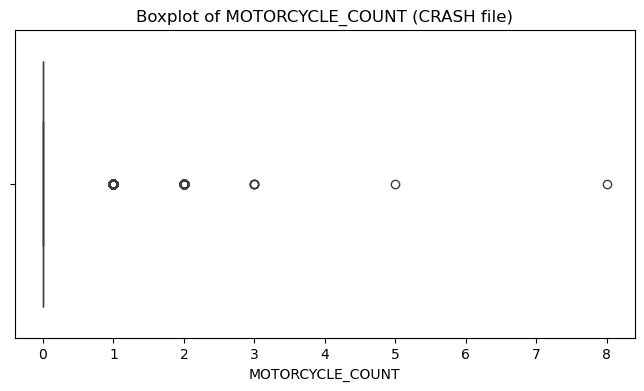

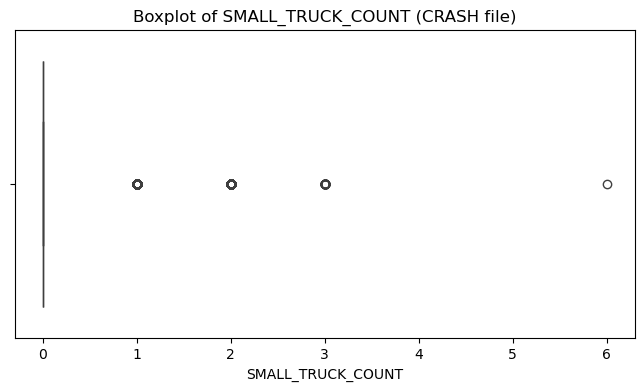

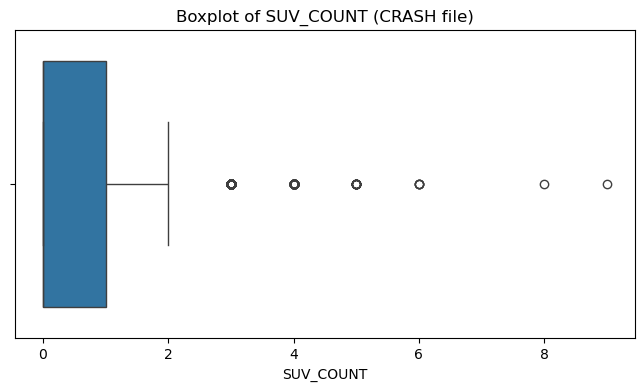

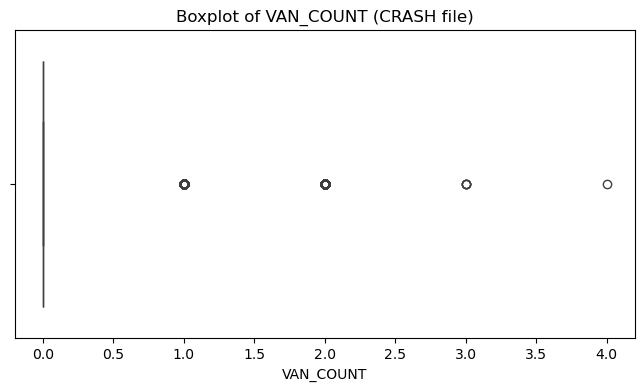

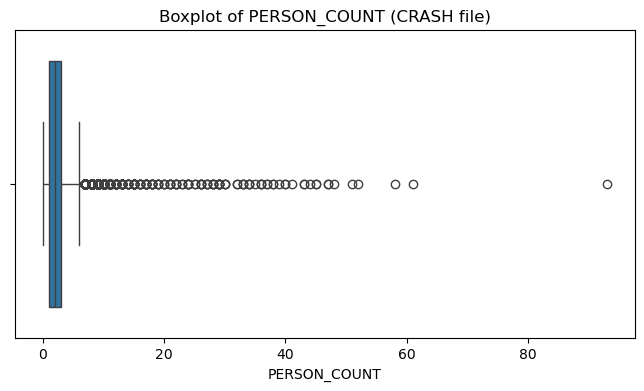

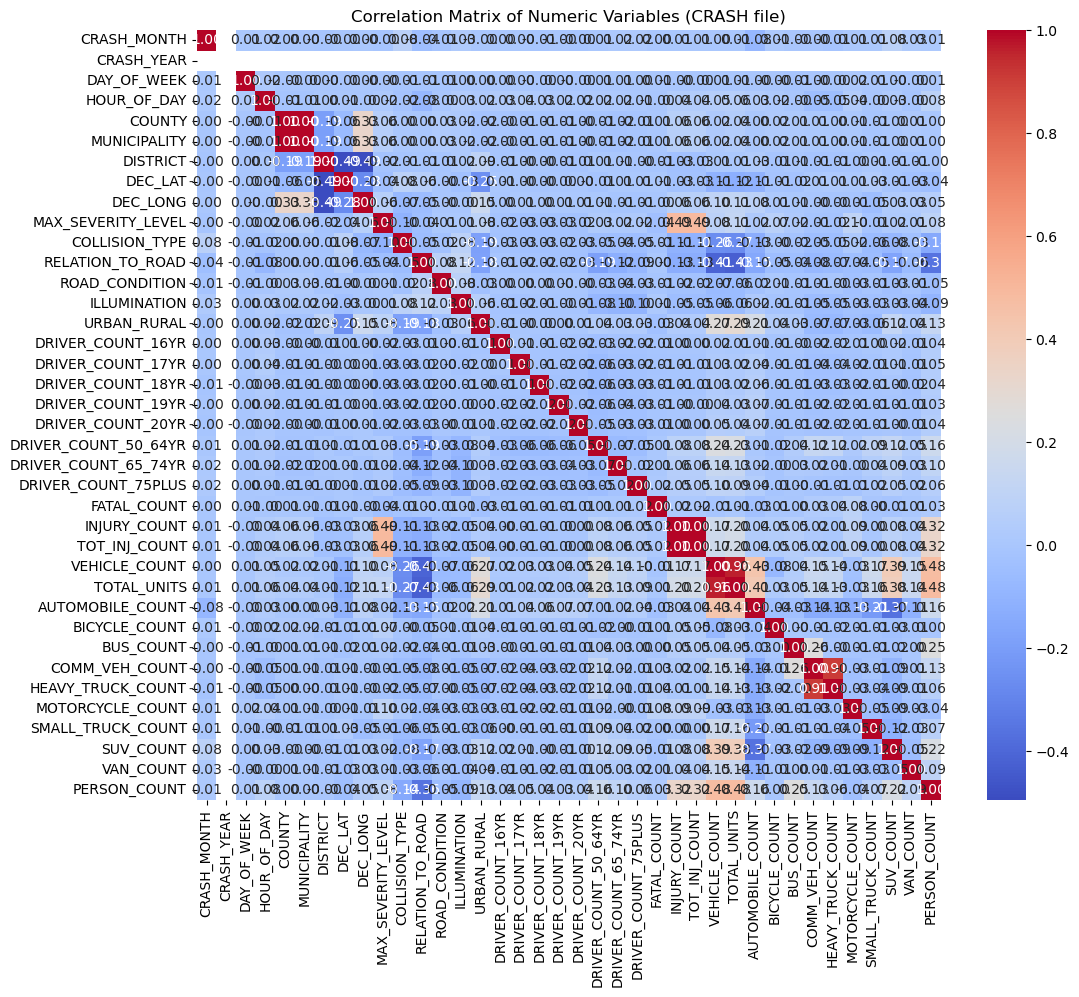


Variance Inflation Factor (VIF) for numeric features (CRASH file):
                 Feature           VIF
0            CRASH_MONTH      1.021118
1             CRASH_YEAR   9664.567637
2            DAY_OF_WEEK      1.001415
3            HOUR_OF_DAY      1.025580
4                 COUNTY  60889.149612
5           MUNICIPALITY  60867.701819
6               DISTRICT      3.067502
7                DEC_LAT      2.554367
8               DEC_LONG      2.659418
9     MAX_SEVERITY_LEVEL      1.380511
10        COLLISION_TYPE      1.183460
11      RELATION_TO_ROAD      1.401009
12        ROAD_CONDITION      1.019399
13          ILLUMINATION      1.076229
14           URBAN_RURAL      1.288617
15     DRIVER_COUNT_16YR      1.011736
16     DRIVER_COUNT_17YR      1.024217
17     DRIVER_COUNT_18YR      1.023003
18     DRIVER_COUNT_19YR      1.022440
19     DRIVER_COUNT_20YR      1.022991
20  DRIVER_COUNT_50_64YR      1.155523
21  DRIVER_COUNT_65_74YR      1.073644
22   DRIVER_COUNT_75PLUS      1.048

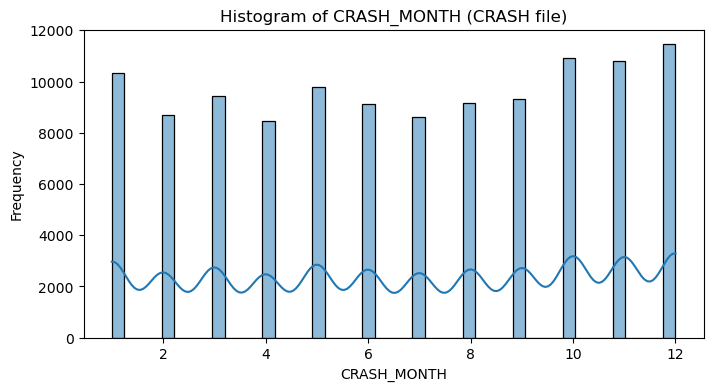

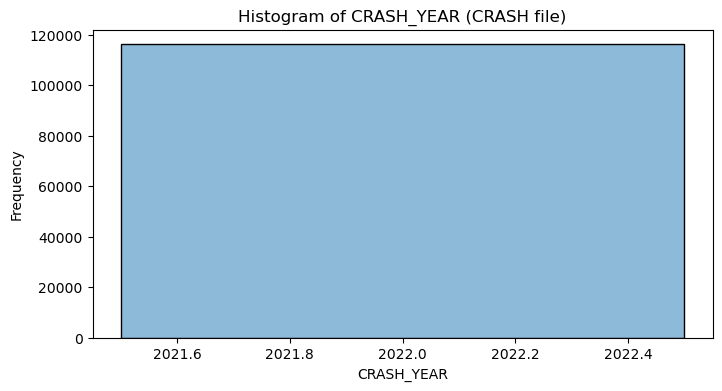

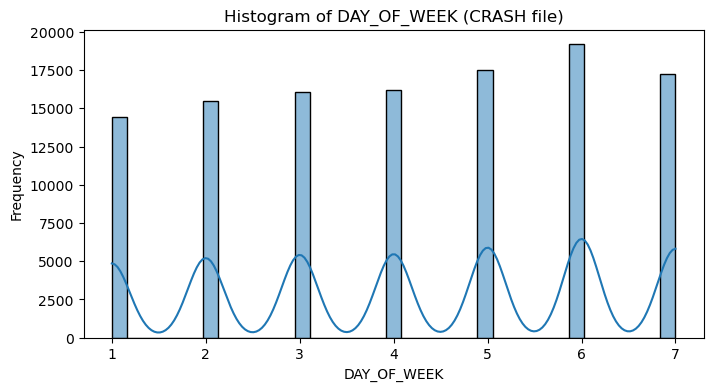

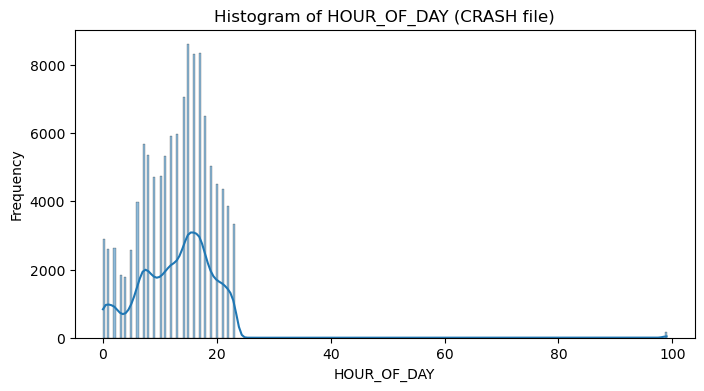

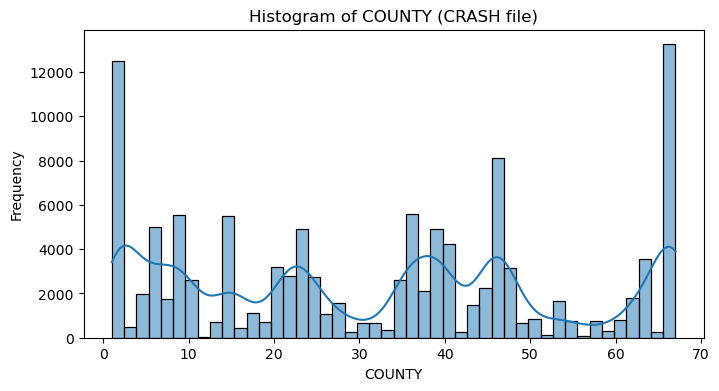

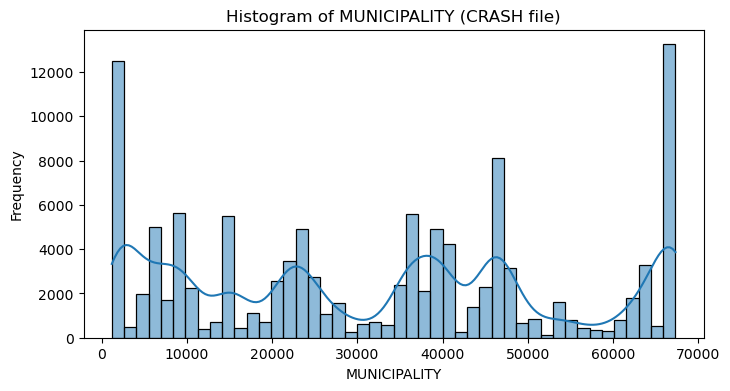

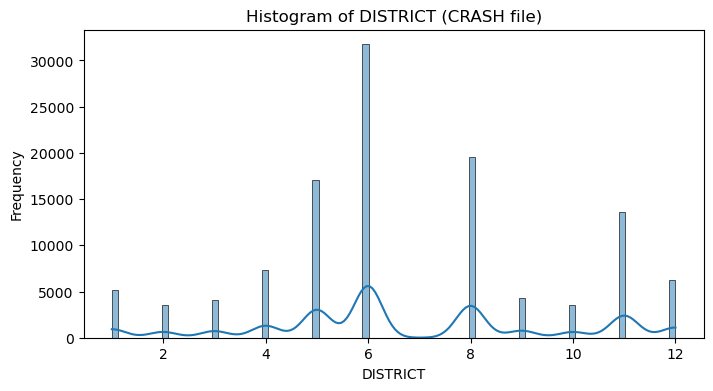

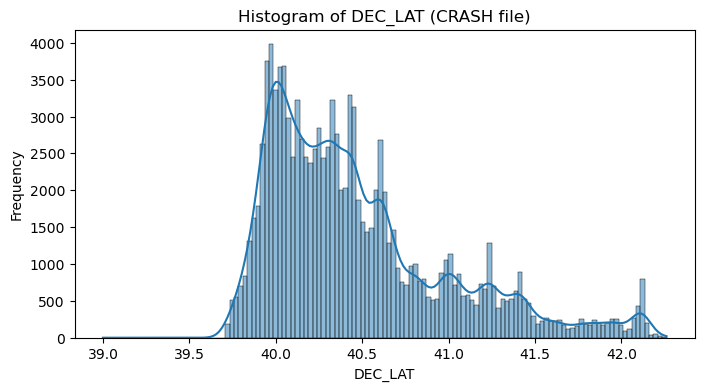

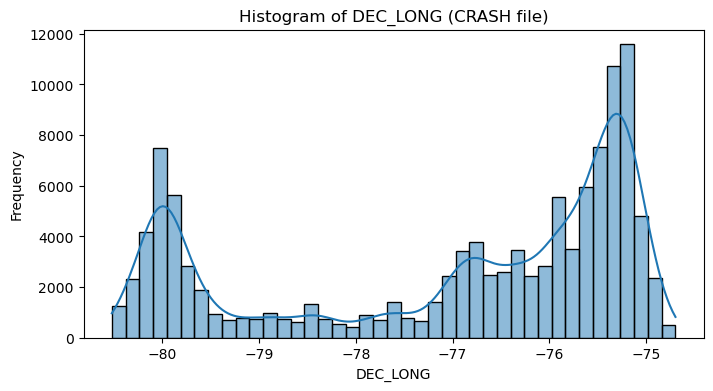

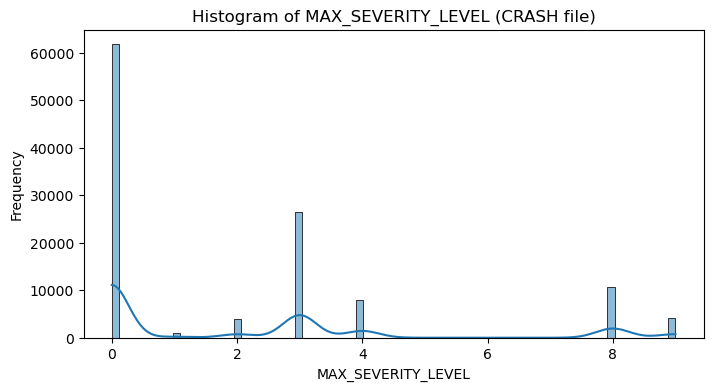

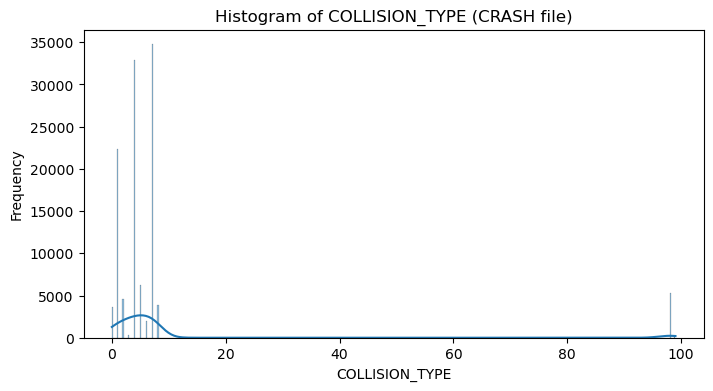

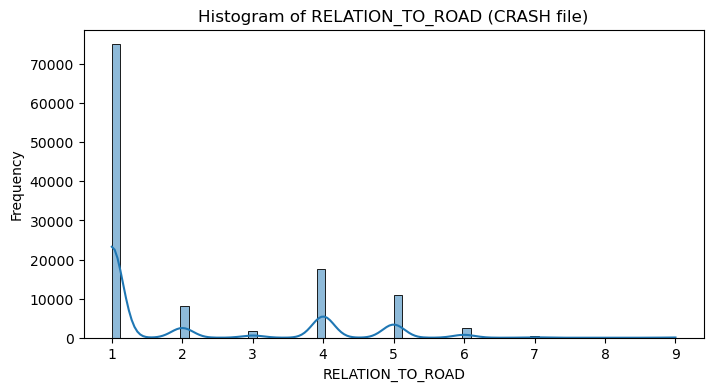

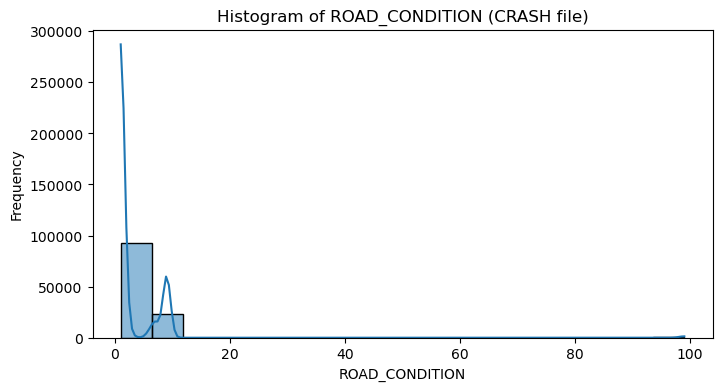

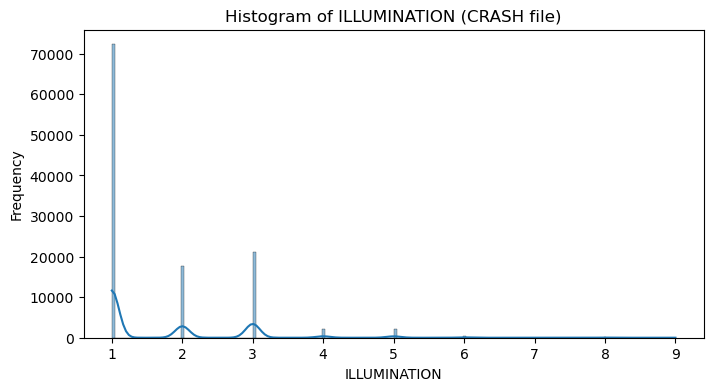

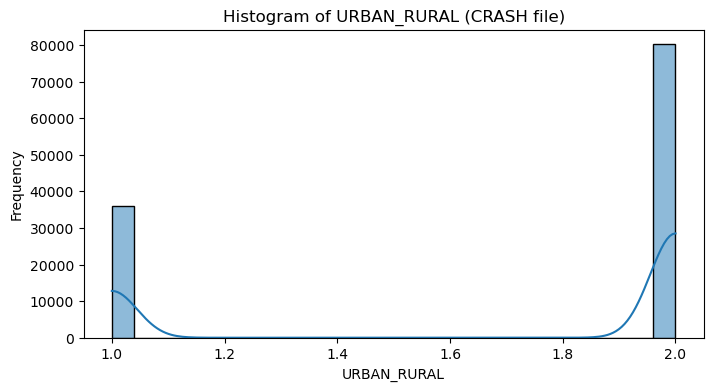

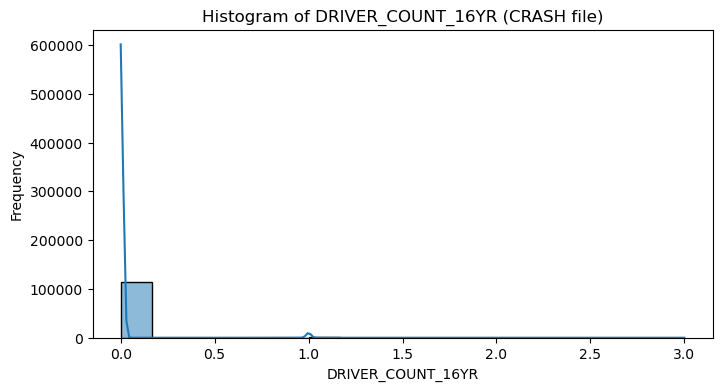

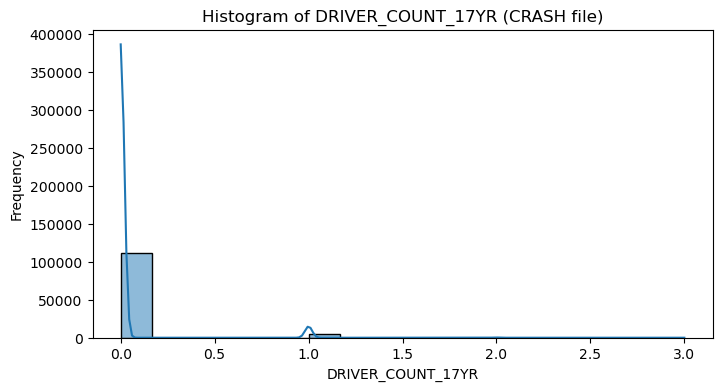

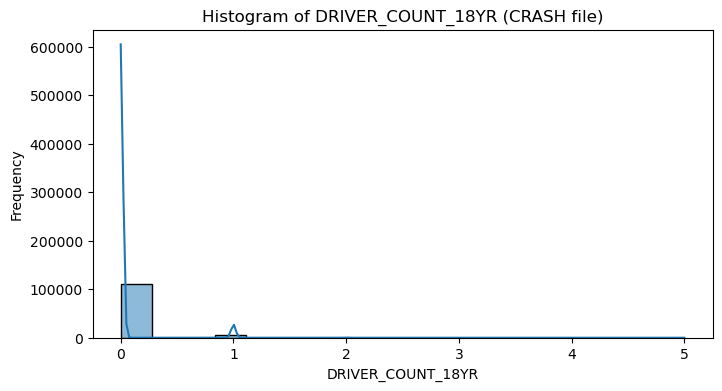

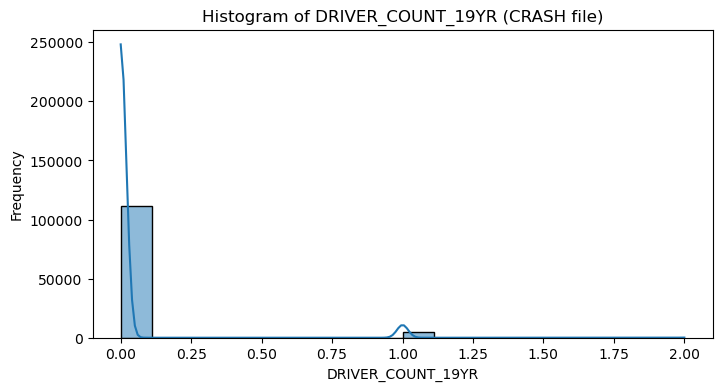

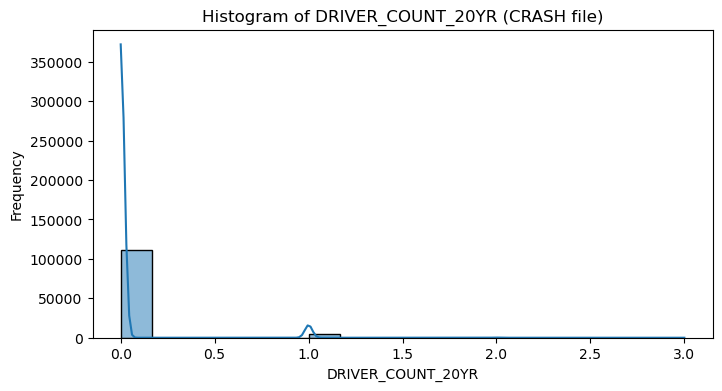

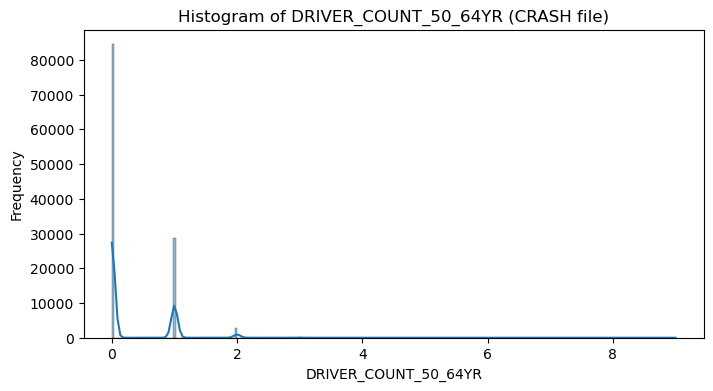

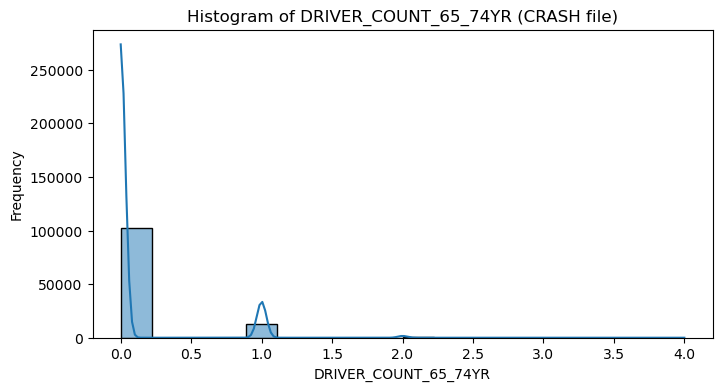

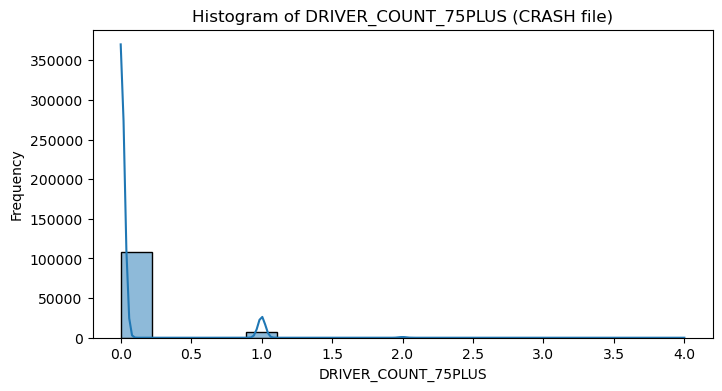

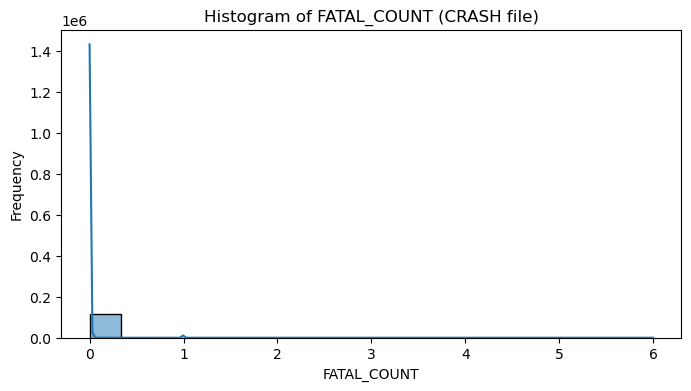

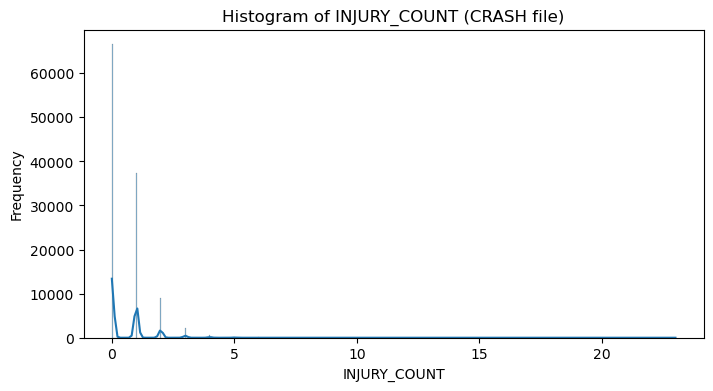

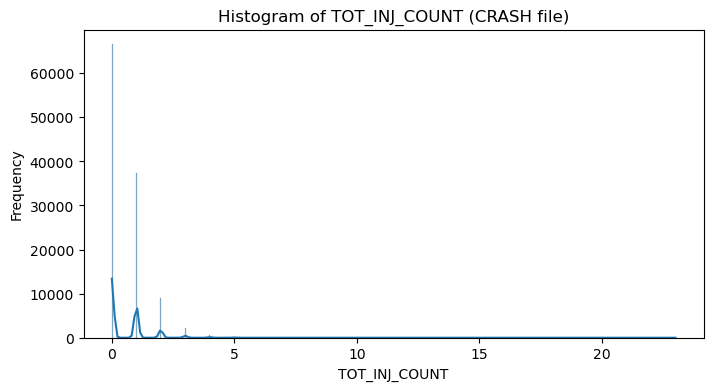

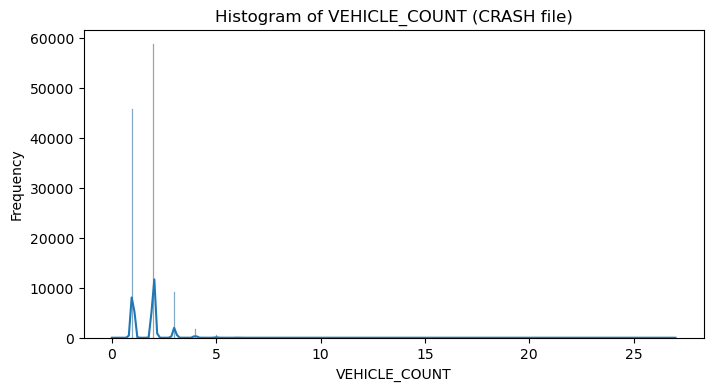

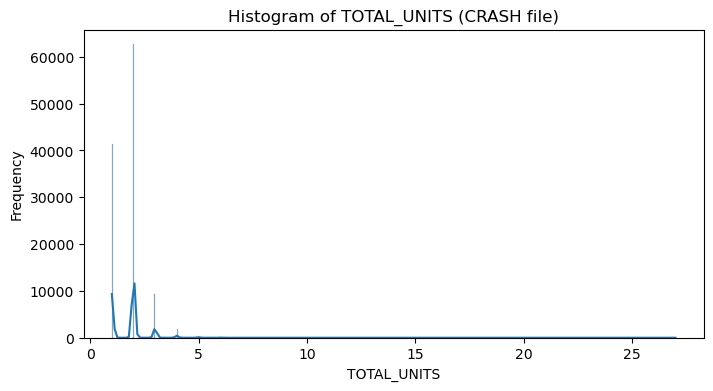

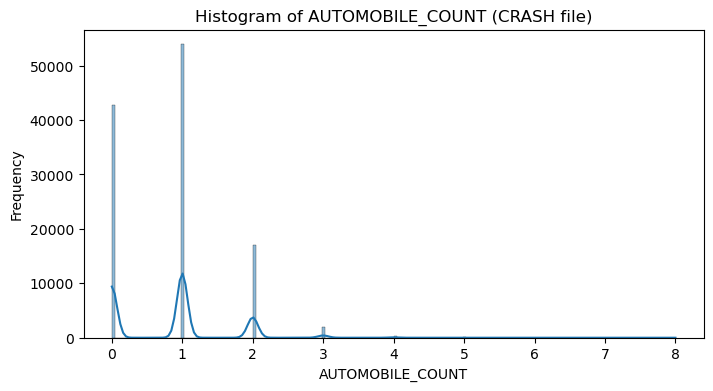

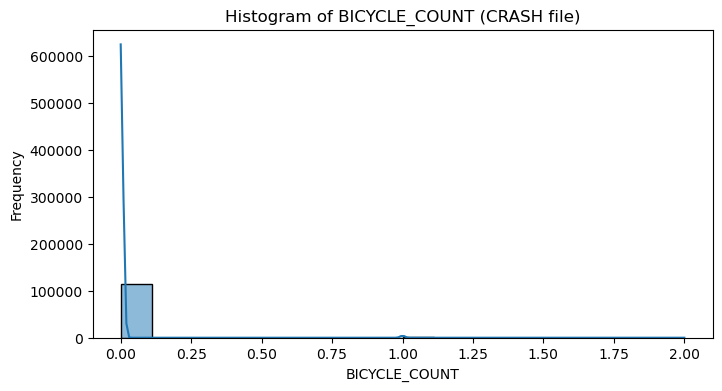

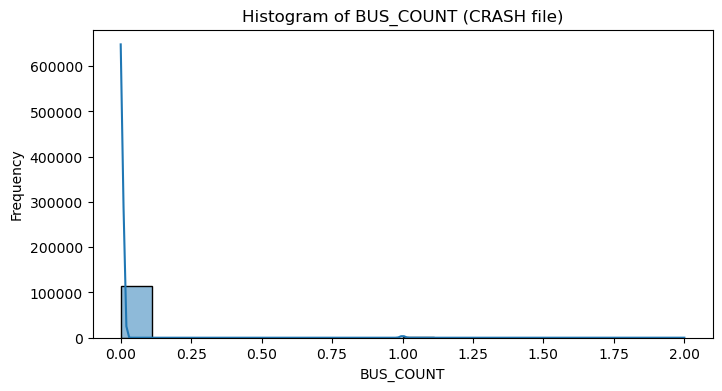

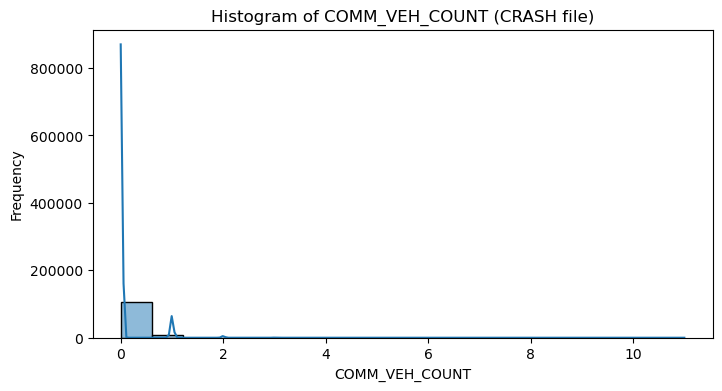

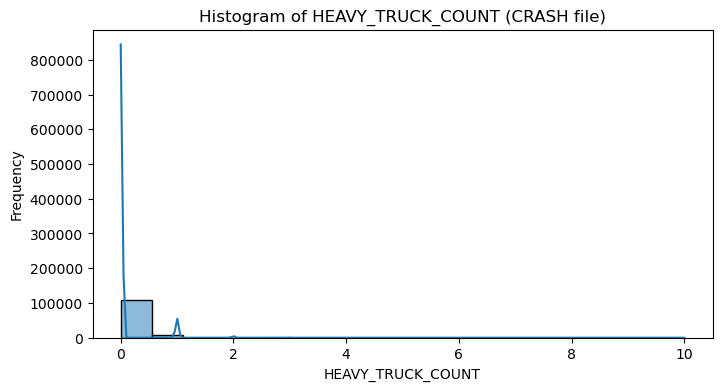

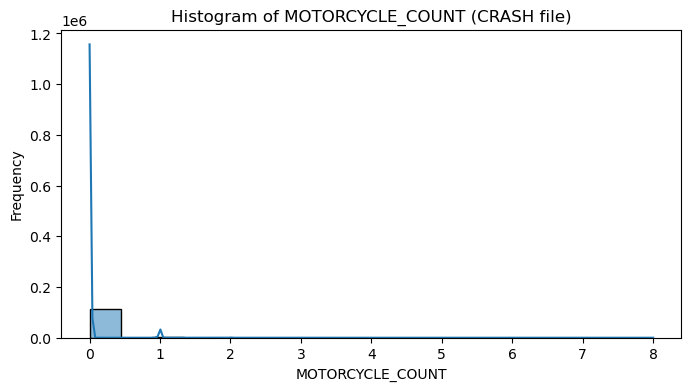

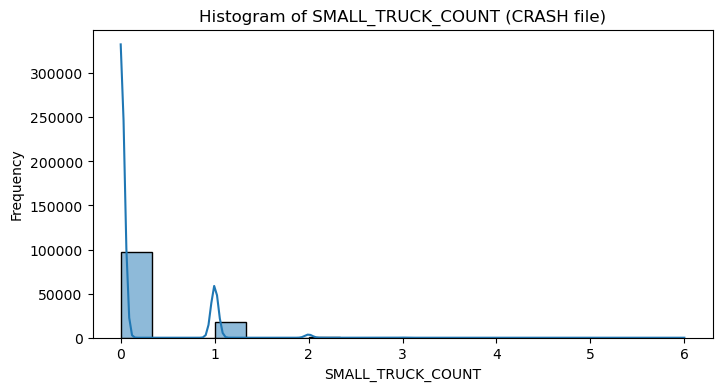

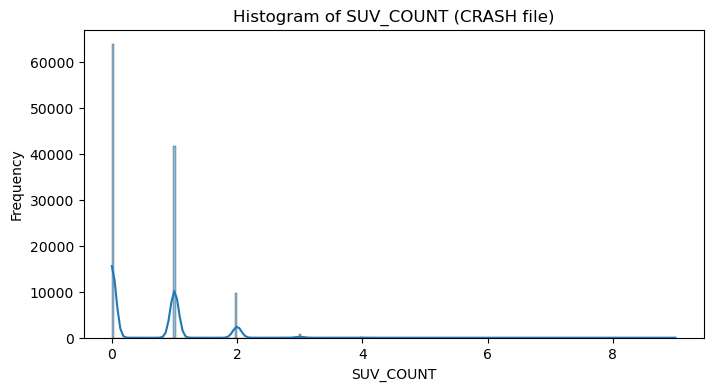

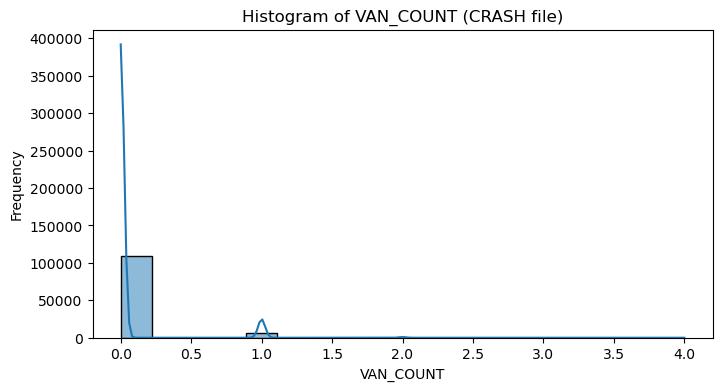

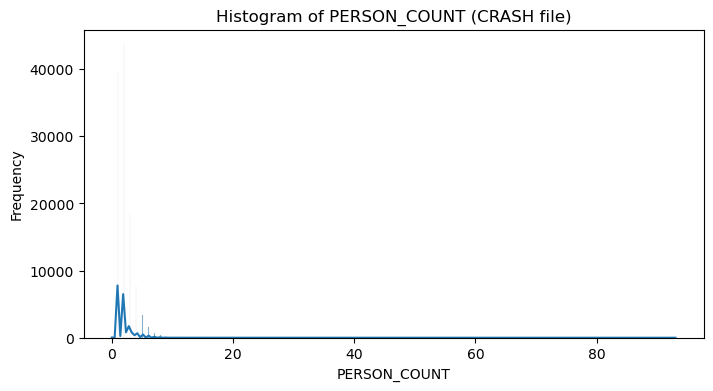


Distribution for 'INTERSECTION_RELATED' (CRASH file):
INTERSECTION_RELATED
N    96.68
Y     3.32
Name: count, dtype: float64


C:\Users\jason\AppData\Local\Temp\ipykernel_22248\2740714259.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="pastel")


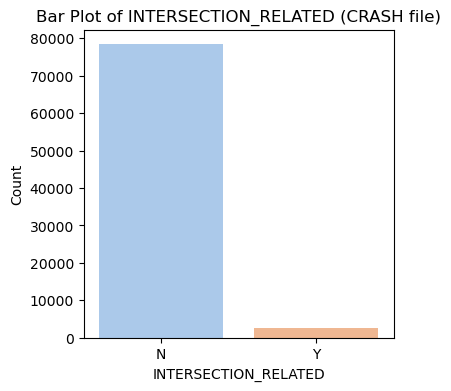


No column name formatting issues detected (CRASH file).

Potential Bias Check (CRASH file):
FATAL_COUNT distribution (%):
FATAL_COUNT
0    99.06
1     0.88
2     0.05
3     0.01
4     0.00
6     0.00
5     0.00
Name: proportion, dtype: float64


In [98]:
# Additional Analyses for CRASH File
print("\n--- Additional Analyses for CRASH File ---")
numeric_cols_crash = df_crash.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns in CRASH file:", numeric_cols_crash)

# Outlier Detection for CRASH file
outlier_summary_crash = {}
for col in numeric_cols_crash:
    count, lb, ub = detect_outliers(col, df_crash)
    outlier_summary_crash[col] = {"Outlier Count": count, "Lower Bound": lb, "Upper Bound": ub}
print("\nOutlier Summary for CRASH file:")
print(pd.DataFrame(outlier_summary_crash).T)

# Boxplots for CRASH file (only if column has >1 unique value)
for col in numeric_cols_crash:
    col_data = df_crash[col].dropna()
    if col_data.nunique() > 1:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=col_data)
        plt.title(f"Boxplot of {col} (CRASH file)")
        plt.show()
    else:
        print(f"Skipping boxplot for {col} due to lack of variation.")

# Correlation Matrix and VIF Calculation for CRASH file
df_vif_crash = df_crash[numeric_cols_crash].replace([np.inf, -np.inf], np.nan).dropna()
plt.figure(figsize=(12, 10))
corr_matrix_crash = df_crash[numeric_cols_crash].corr()
sns.heatmap(corr_matrix_crash, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Variables (CRASH file)")
plt.show()

if df_vif_crash.shape[0] == 0:
    print("VIF cannot be computed: No data available after cleaning numeric columns in CRASH file.")
else:
    vif_data_crash = pd.DataFrame()
    vif_data_crash["Feature"] = numeric_cols_crash
    vif_data_crash["VIF"] = [variance_inflation_factor(df_vif_crash.values, i) for i in range(len(numeric_cols_crash))]
    print("\nVariance Inflation Factor (VIF) for numeric features (CRASH file):")
    print(vif_data_crash)

# Histograms for CRASH file
for col in numeric_cols_crash:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_crash[col], kde=True)
    plt.title(f"Histogram of {col} (CRASH file)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Analyze binary distributions for CRASH file (example: adjust list as needed)
binary_columns_crash = ['INTERSECTION_RELATED']  # Example; update as appropriate
def analyze_binary_distribution_crash(col, df):
    counts = df[col].value_counts()
    total = counts.sum()
    distribution = (counts / total * 100).round(2)
    print(f"\nDistribution for '{col}' (CRASH file):")
    print(distribution)
    plt.figure(figsize=(4, 4))
    sns.barplot(x=counts.index, y=counts.values, palette="pastel")
    plt.title(f"Bar Plot of {col} (CRASH file)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()
for col in binary_columns_crash:
    if col in df_crash.columns:
        analyze_binary_distribution_crash(col, df_crash)

# Check column name formatting for CRASH file
format_issues_crash = [check_column_name_format(col) for col in df_crash.columns if check_column_name_format(col) is not None]
if format_issues_crash:
    print("\nColumn Name Formatting Issues (CRASH file):")
    for issue in format_issues_crash:
        print(issue)
else:
    print("\nNo column name formatting issues detected (CRASH file).")

# Potential Bias Check for CRASH file (example: using 'FATAL_COUNT' if available)
print("\nPotential Bias Check (CRASH file):")
if 'FATAL_COUNT' in df_crash.columns:
    fatal_distribution = df_crash['FATAL_COUNT'].value_counts(normalize=True) * 100
    print("FATAL_COUNT distribution (%):")
    print(fatal_distribution.round(2))
else:
    print("No 'FATAL_COUNT' column found to check for bias.")


--- Additional Analyses for PERSON File ---

Numeric columns in PERSON file: ['AGE', 'INJ_SEVERITY', 'PERSON_TYPE', 'SEAT_POSITION', 'RESTRAINT_HELMET', 'DVR_PED_CONDITION', 'VULNERABLE_ROAD_USER', 'INJ_SEVERITY_NUM']

Outlier Summary for PERSON file:
                      Outlier Count  Lower Bound  Upper Bound
AGE                             0.0        -26.0        102.0
INJ_SEVERITY                23426.0         -4.5          7.5
PERSON_TYPE                  5398.0         -0.5          3.5
SEAT_POSITION               64822.0          1.0          1.0
RESTRAINT_HELMET            83145.0          3.0          3.0
DVR_PED_CONDITION           27787.0          0.0          0.0
VULNERABLE_ROAD_USER         4146.0          0.0          0.0
INJ_SEVERITY_NUM            23426.0         -4.5          7.5


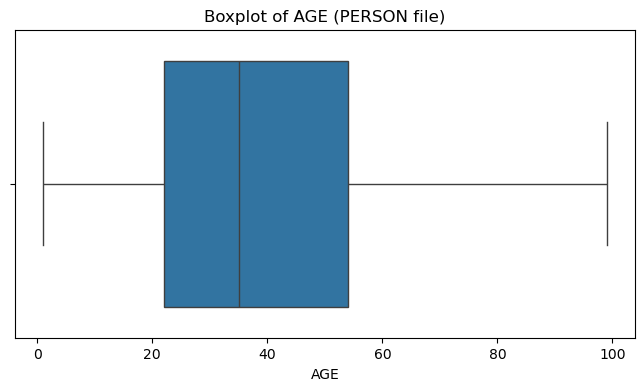

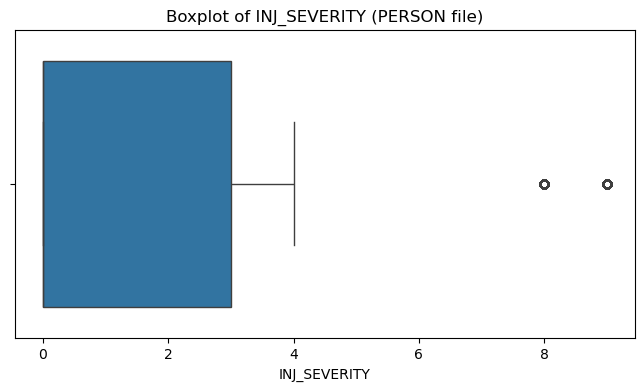

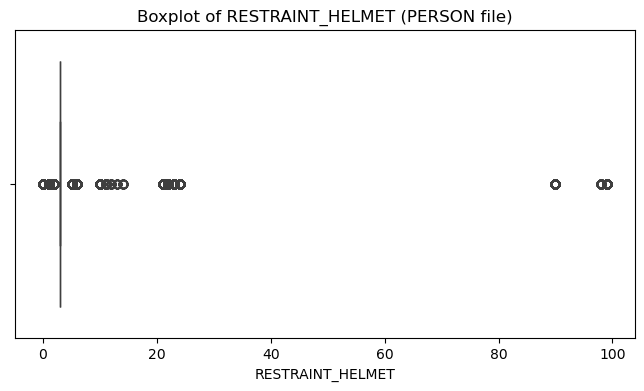

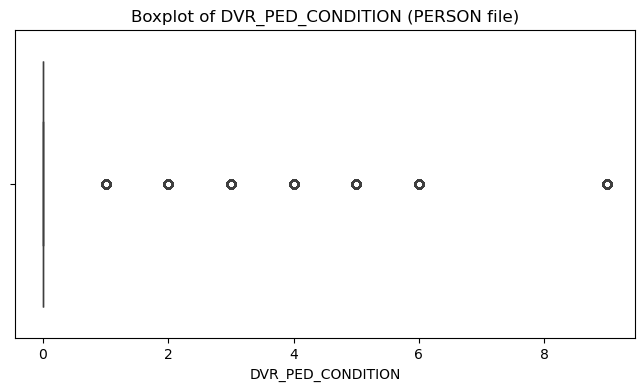

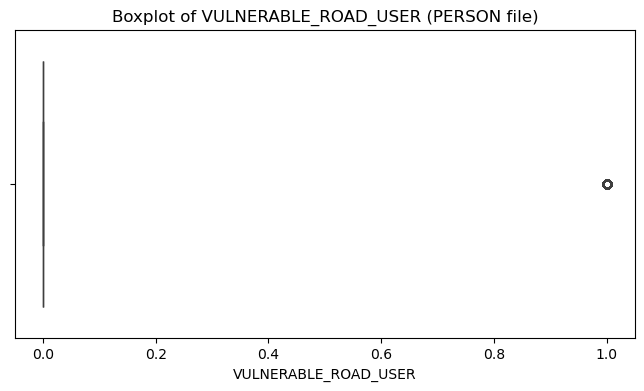

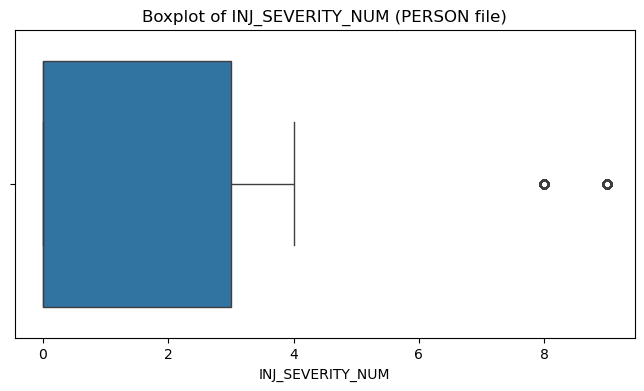

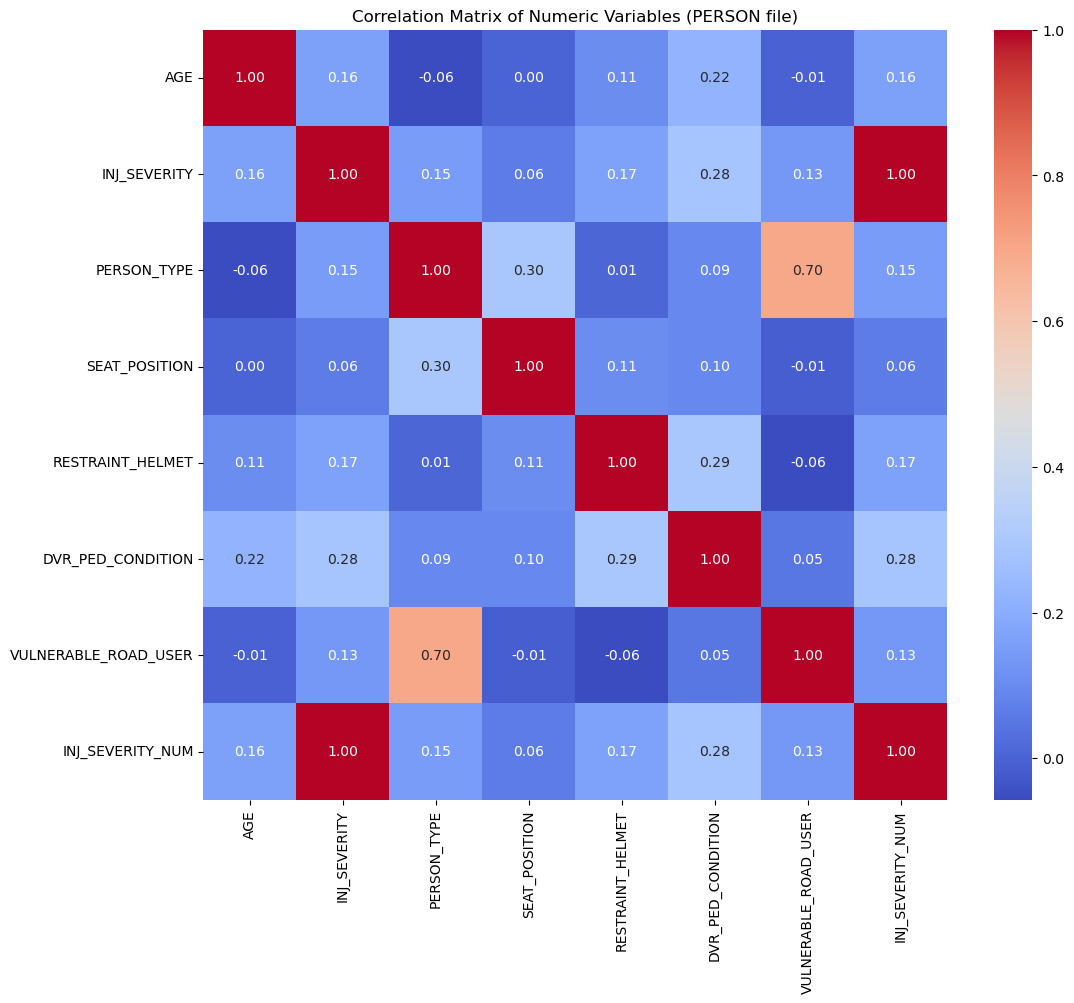

C:\Users\jason\anaconda3\envs\DeepL\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Variance Inflation Factor (VIF) for numeric features (PERSON file):
                Feature       VIF
0                   AGE  2.736379
1          INJ_SEVERITY       inf
2           PERSON_TYPE  3.911315
3         SEAT_POSITION  1.294716
4      RESTRAINT_HELMET  1.357221
5     DVR_PED_CONDITION  1.284541
6  VULNERABLE_ROAD_USER  1.729940
7      INJ_SEVERITY_NUM       inf


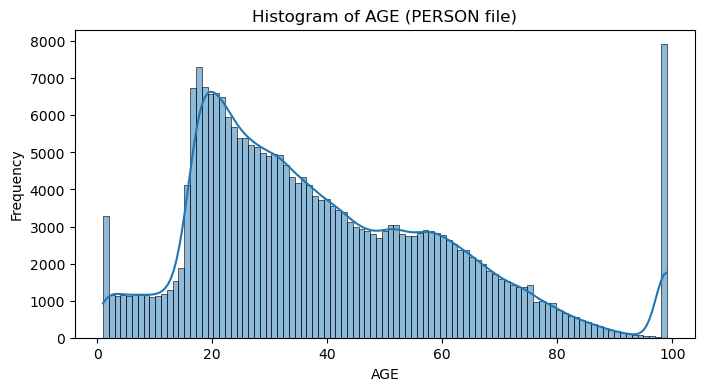

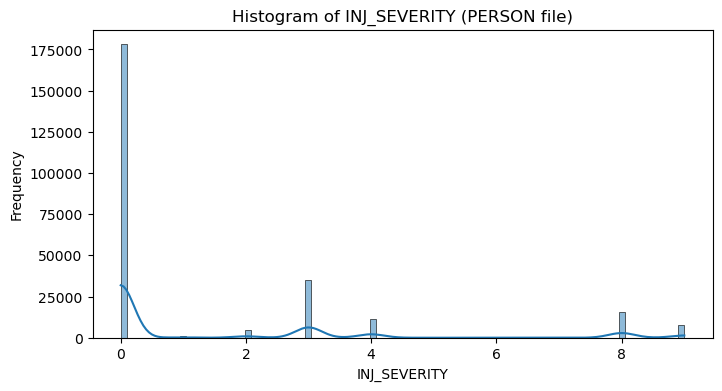

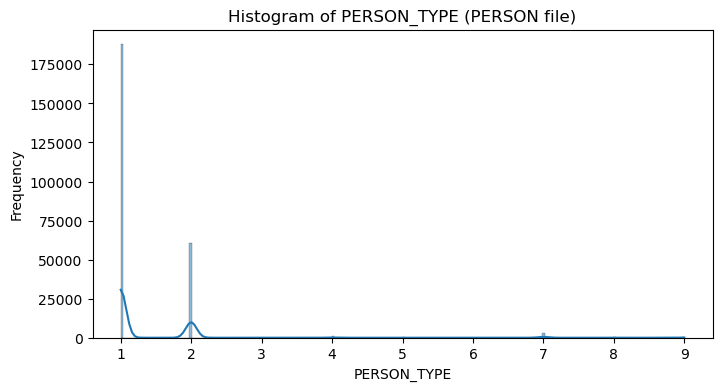

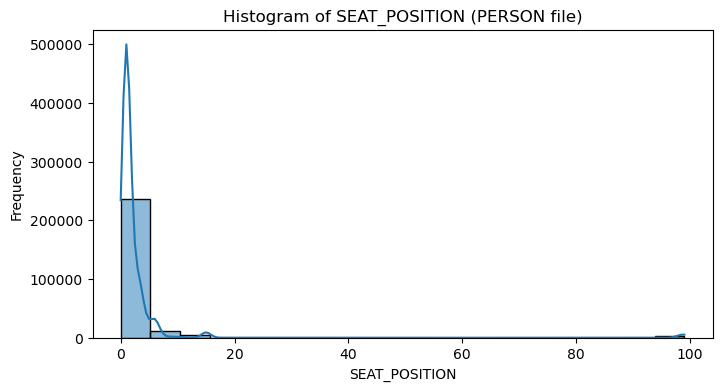

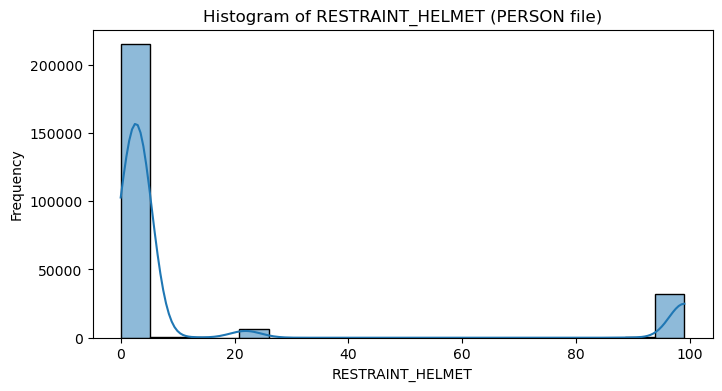

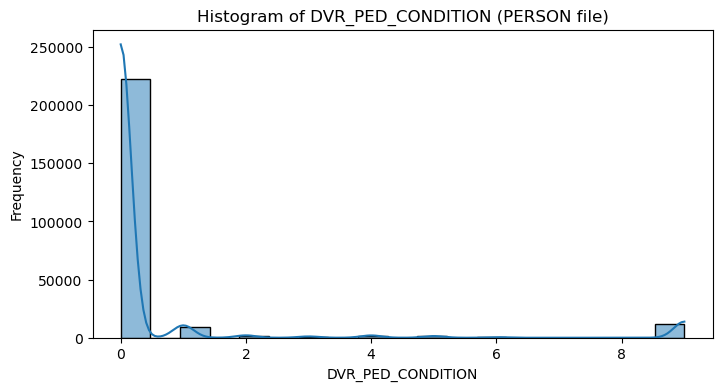

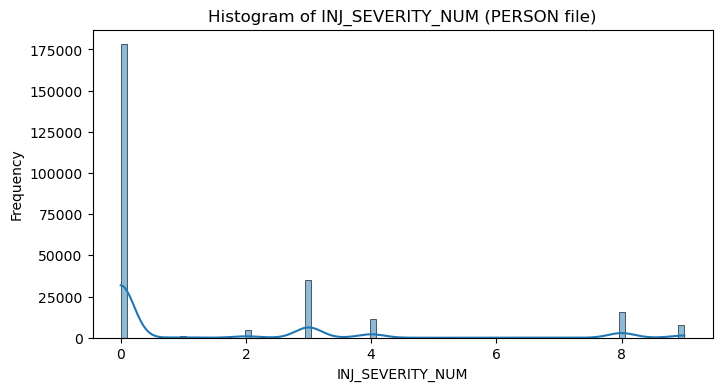


Distribution for 'SEX' (PERSON file):
SEX
M    55.66
F    42.23
U     2.12
Name: count, dtype: float64


C:\Users\jason\AppData\Local\Temp\ipykernel_22248\188639498.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="pastel")


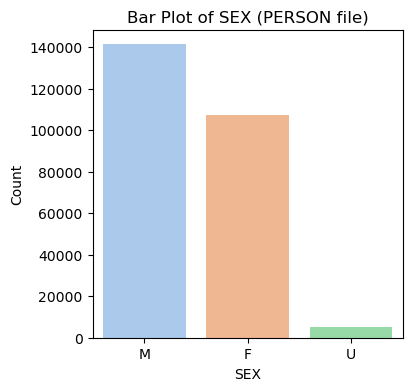


No column name formatting issues detected (PERSON file).

Potential Bias Check (PERSON file):
AGE distribution (%):
AGE
99    3.06
18    2.88
19    2.67
17    2.65
21    2.60
      ... 
93    0.03
94    0.02
95    0.02
96    0.01
97    0.01
Name: proportion, Length: 99, dtype: float64


In [99]:
# Additional Analyses for PERSON File
print("\n--- Additional Analyses for PERSON File ---")
numeric_cols_person = df_person.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns in PERSON file:", numeric_cols_person)

# Outlier Detection for PERSON file
outlier_summary_person = {}
for col in numeric_cols_person:
    count, lb, ub = detect_outliers(col, df_person)
    outlier_summary_person[col] = {"Outlier Count": count, "Lower Bound": lb, "Upper Bound": ub}
print("\nOutlier Summary for PERSON file:")
print(pd.DataFrame(outlier_summary_person).T)

# Boxplots for PERSON file (only if column has >1 unique value)
for col in numeric_cols_person:
    col_data = df_person[col].dropna()
    if col_data.nunique() > 1:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=col_data)
        plt.title(f"Boxplot of {col} (PERSON file)")
        plt.show()
    else:
        print(f"Skipping boxplot for {col} due to lack of variation.")

# Correlation Matrix and VIF Calculation for PERSON file
df_vif_person = df_person[numeric_cols_person].replace([np.inf, -np.inf], np.nan).dropna()
plt.figure(figsize=(12, 10))
corr_matrix_person = df_person[numeric_cols_person].corr()
sns.heatmap(corr_matrix_person, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Variables (PERSON file)")
plt.show()

if df_vif_person.shape[0] == 0:
    print("VIF cannot be computed: No data available after cleaning numeric columns in PERSON file.")
else:
    vif_data_person = pd.DataFrame()
    vif_data_person["Feature"] = numeric_cols_person
    vif_data_person["VIF"] = [variance_inflation_factor(df_vif_person.values, i) for i in range(len(numeric_cols_person))]
    print("\nVariance Inflation Factor (VIF) for numeric features (PERSON file):")
    print(vif_data_person)

# Histograms for PERSON file
for col in numeric_cols_person:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_person[col], kde=True)
    plt.title(f"Histogram of {col} (PERSON file)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Analyze binary distributions for PERSON file (example: 'SEX' if applicable)
binary_columns_person = ['SEX']  # Adjust as needed
def analyze_binary_distribution_person(col, df):
    counts = df[col].value_counts()
    total = counts.sum()
    distribution = (counts / total * 100).round(2)
    print(f"\nDistribution for '{col}' (PERSON file):")
    print(distribution)
    plt.figure(figsize=(4, 4))
    sns.barplot(x=counts.index, y=counts.values, palette="pastel")
    plt.title(f"Bar Plot of {col} (PERSON file)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()
for col in binary_columns_person:
    if col in df_person.columns:
        analyze_binary_distribution_person(col, df_person)

# Check column name formatting for PERSON file
format_issues_person = [check_column_name_format(col) for col in df_person.columns if check_column_name_format(col) is not None]
if format_issues_person:
    print("\nColumn Name Formatting Issues (PERSON file):")
    for issue in format_issues_person:
        print(issue)
else:
    print("\nNo column name formatting issues detected (PERSON file).")

# Potential Bias Check for PERSON file (example: using 'AGE')
print("\nPotential Bias Check (PERSON file):")
if 'AGE' in df_person.columns:
    age_distribution = df_person['AGE'].value_counts(normalize=True) * 100
    print("AGE distribution (%):")
    print(age_distribution.round(2))
else:
    print("No 'AGE' column found to check for bias.")


--- Additional Analyses for VEHICLE File ---

Numeric columns in VEHICLE file: ['VEH_TYPE', 'BODY_TYPE', 'MODEL_YR', 'VEH_ROLE', 'VEH_MOVEMENT', 'TRAVEL_SPD', 'UNIT_TYPE', 'TRAVEL_SPD_NUM']

Outlier Summary for VEHICLE file:
                Outlier Count  Lower Bound  Upper Bound
VEH_TYPE               6288.0         -6.5         13.5
BODY_TYPE                 0.0        -66.5        121.5
MODEL_YR               1419.0       1993.0       2033.0
VEH_ROLE                  0.0         -0.5          3.5
VEH_MOVEMENT           5775.0        -15.5         28.5
TRAVEL_SPD                0.0      -1461.0       2475.0
UNIT_TYPE             22450.0          1.0          1.0
TRAVEL_SPD_NUM            0.0      -1461.0       2475.0


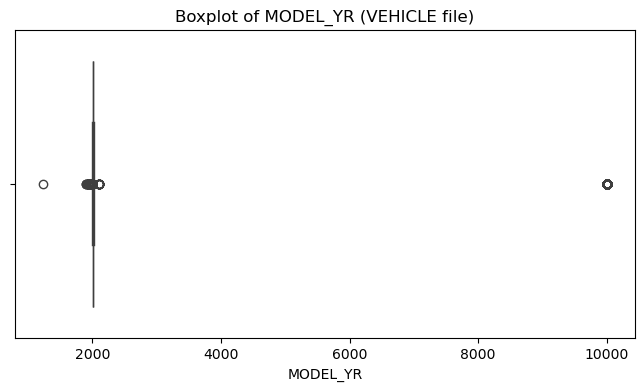

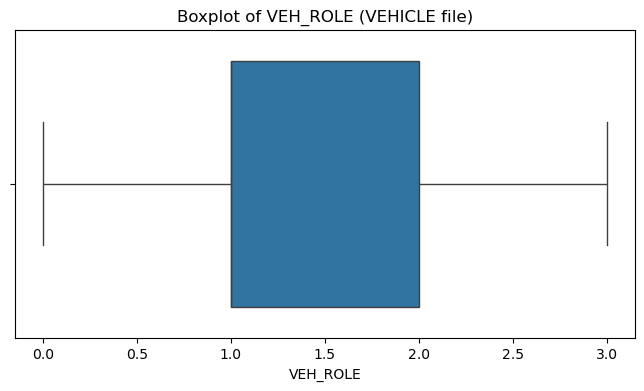

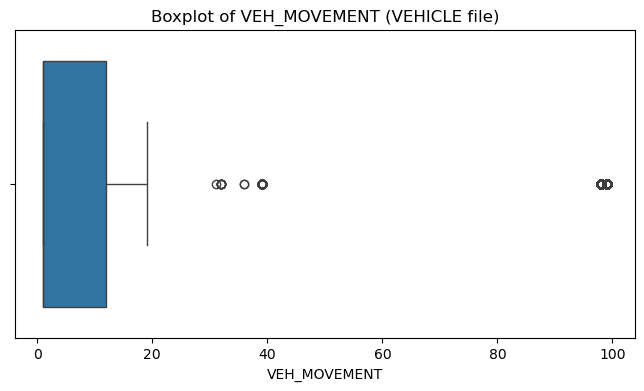

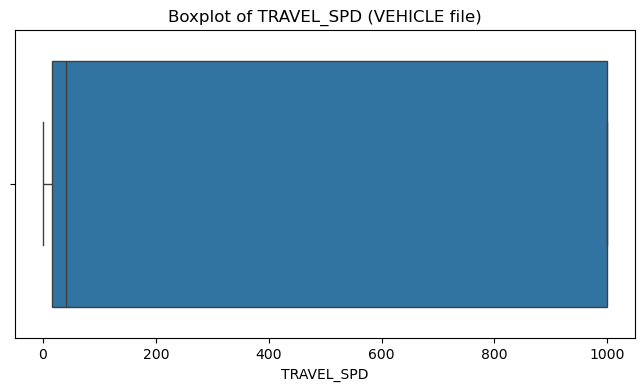

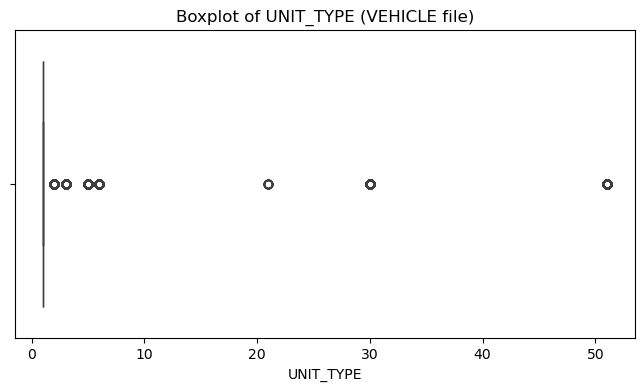

C:\Users\jason\anaconda3\envs\DeepL\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Variance Inflation Factor (VIF) for numeric features (VEHICLE file):
          Feature       VIF
0        VEH_TYPE  4.067004
1       BODY_TYPE  2.915407
2        MODEL_YR  8.696219
3        VEH_ROLE  5.078010
4    VEH_MOVEMENT  1.378838
5      TRAVEL_SPD       inf
6       UNIT_TYPE  2.660360
7  TRAVEL_SPD_NUM       inf


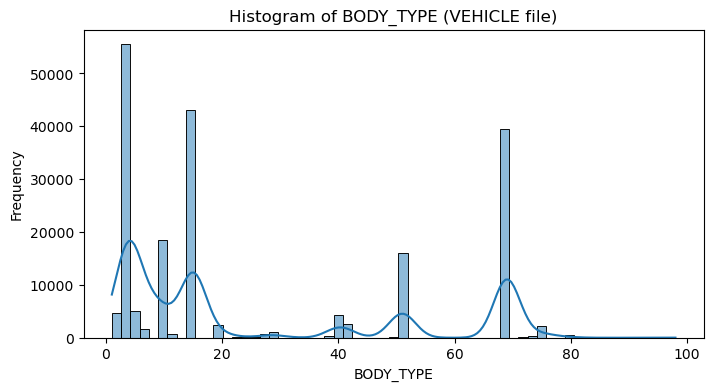

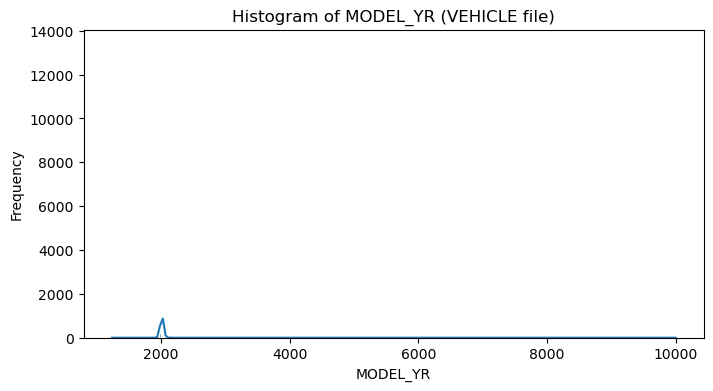

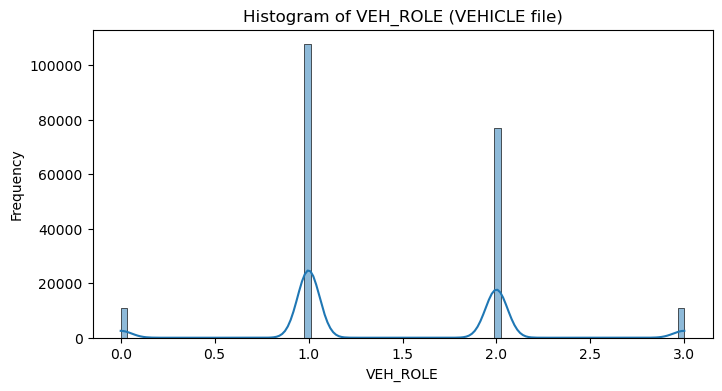

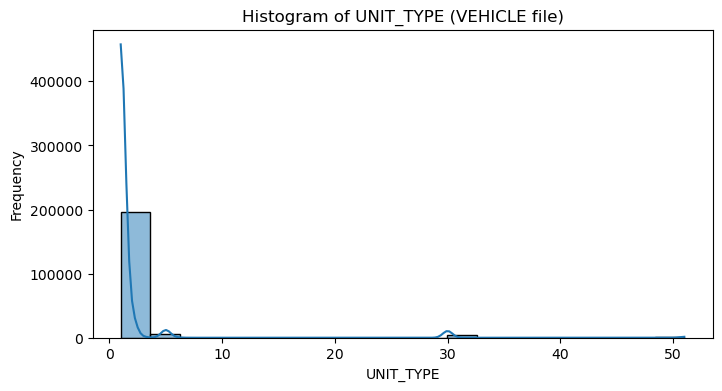


No column name formatting issues detected (VEHICLE file).

Potential Bias Check (VEHICLE file):
No 'PEOPLE_IN_UNIT' column found to check for bias.


In [100]:
# Additional Analyses for VEHICLE File
print("\n--- Additional Analyses for VEHICLE File ---")
numeric_cols_vehicle = df_vehicle.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns in VEHICLE file:", numeric_cols_vehicle)

# Outlier Detection for VEHICLE file
outlier_summary_vehicle = {}
for col in numeric_cols_vehicle:
    count, lb, ub = detect_outliers(col, df_vehicle)
    outlier_summary_vehicle[col] = {"Outlier Count": count, "Lower Bound": lb, "Upper Bound": ub}
print("\nOutlier Summary for VEHICLE file:")
print(pd.DataFrame(outlier_summary_vehicle).T)

# Boxplots for VEHICLE file (only if column has >1 unique value)
for col in numeric_cols_vehicle:
    col_data = df_vehicle[col].dropna()
    if col_data.nunique() > 1:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=col_data)
        plt.title(f"Boxplot of {col} (VEHICLE file)")
        plt.show()
    else:
        print(f"Skipping boxplot for {col} due to lack of variation.")

# Correlation Matrix and VIF Calculation for VEHICLE file
df_vif_vehicle = df_vehicle[numeric_cols_vehicle].replace([np.inf, -np.inf], np.nan).dropna()
plt.figure(figsize=(12, 10))
corr_matrix_vehicle = df_vehicle[numeric_cols_vehicle].corr()
sns.heatmap(corr_matrix_vehicle, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Variables (VEHICLE file)")
plt.show()

if df_vif_vehicle.shape[0] == 0:
    print("VIF cannot be computed: No data available after cleaning numeric columns in VEHICLE file.")
else:
    vif_data_vehicle = pd.DataFrame()
    vif_data_vehicle["Feature"] = numeric_cols_vehicle
    vif_data_vehicle["VIF"] = [variance_inflation_factor(df_vif_vehicle.values, i) for i in range(len(numeric_cols_vehicle))]
    print("\nVariance Inflation Factor (VIF) for numeric features (VEHICLE file):")
    print(vif_data_vehicle)

# Histograms for VEHICLE file
for col in numeric_cols_vehicle:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_vehicle[col], kde=True)
    plt.title(f"Histogram of {col} (VEHICLE file)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Analyze binary distributions for VEHICLE file (if applicable)
binary_columns_vehicle = []  # Add any VEHICLE binary fields if applicable
def analyze_binary_distribution_vehicle(col, df):
    counts = df[col].value_counts()
    total = counts.sum()
    distribution = (counts / total * 100).round(2)
    print(f"\nDistribution for '{col}' (VEHICLE file):")
    print(distribution)
    plt.figure(figsize=(4, 4))
    sns.barplot(x=counts.index, y=counts.values, palette="pastel")
    plt.title(f"Bar Plot of {col} (VEHICLE file)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()
for col in binary_columns_vehicle:
    if col in df_vehicle.columns:
        analyze_binary_distribution_vehicle(col, df_vehicle)

# Check column name formatting for VEHICLE file
format_issues_vehicle = [check_column_name_format(col) for col in df_vehicle.columns if check_column_name_format(col) is not None]
if format_issues_vehicle:
    print("\nColumn Name Formatting Issues (VEHICLE file):")
    for issue in format_issues_vehicle:
        print(issue)
else:
    print("\nNo column name formatting issues detected (VEHICLE file).")

# Potential Bias Check for VEHICLE file (example: using 'PEOPLE_IN_UNIT' if available)
print("\nPotential Bias Check (VEHICLE file):")
if 'PEOPLE_IN_UNIT' in df_vehicle.columns:
    people_distribution = df_vehicle['PEOPLE_IN_UNIT'].value_counts(normalize=True) * 100
    print("PEOPLE_IN_UNIT distribution (%):")
    print(people_distribution.round(2))
else:
    print("No 'PEOPLE_IN_UNIT' column found to check for bias.")